In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import gensim
import glob2
from itertools import chain
import os
import numpy as np
import itertools
import cPickle as pickle
from  scipy.stats import rankdata
import copy
from openpyxl import Workbook
from openpyxl.compat import range
from openpyxl.utils import get_column_letter
from openpyxl import load_workbook
import pandas as pd
from scipy.stats import hmean
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize


2018-03-21 14:48:57,279 : INFO : 'pattern' package not found; tag filters are not available for English


In [3]:
# ignores everything except english alphabet and  
def only_alphabet(text):
    return ''.join(i for i in text if (ord(i)<123 and ord(i)>96) or (ord(i)<91 and ord(i)>64) or ord(i)==32) 

In [4]:
full_filenames = []
x= ['LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt','LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt' ,'LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt']
for glob_filenames in x:
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        full_filenames.append(filename)
            
filenames = []
x= ['LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt','LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt' ,'LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt']
for glob_filenames in x:
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        filenames.append(os.path.basename(filename))

en_stop = set(get_stop_words('en'))
ps = PorterStemmer()

# "yield" for each file return token list  i.e list of lists
def files_to_tokens(glob_filenames):
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        f = open(filename)
        # read the whole file as lowercase string
        string = only_alphabet(f.read()).lower()
        tokens = []
        # tokenize that string
        for word in word_tokenize(string):
            if word not in en_stop:
                tokens.append(ps.stem(word))

        yield tokens
        f.close()


        
# yields token list for files specific to courts; needed for creating dictionaries
class texts:
    def DCDRC(self):
        return files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt')
    def NCDRC(self):
        return files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt')
    def SCDRC(self):
        return files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt')
    def DelhiHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt')
    def JharkhandHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt')
    def JodhpurHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt')
    def KolkataHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt')
    def SupremeCourt(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt')

# yields bow for each file - tuples id,fq ; needed to train models   
class my_corpus:    
    def DCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/*.txt'):
            yield dictionary.doc2bow(text)
    def NCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt'):
            yield dictionary.doc2bow(text)            
    def SCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def DelhiHC(self):
        for text in files_to_tokens('LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def JharkhandHC(self):
        for text in files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def JodhpurHC(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def KolkataHC(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def SupremeCourt(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt'):
            yield dictionary.doc2bow(text)
    def everything(self):
        return chain(self.DCDRC(), self.NCDRC(), self.SCDRC(), self.DelhiHC(),
                     self.JharkhandHC(), self.JodhpurHC(), self.KolkataHC(), self.SupremeCourt())
        
        

In [5]:
#################################### laod the dictinary
dictionary = corpora.Dictionary.load('stem100_dictionary')

2018-03-21 14:49:28,680 : INFO : loading Dictionary object from stem100_dictionary
2018-03-21 14:49:28,921 : INFO : loaded stem100_dictionary


In [6]:
######################################## load BOW
corpus = corpora.MmCorpus('stem100.mm')

2018-03-21 14:49:29,723 : INFO : loaded corpus index from stem100.mm.index
2018-03-21 14:49:29,724 : INFO : initializing corpus reader from stem100.mm
2018-03-21 14:49:29,769 : INFO : accepted corpus with 351985 documents, 40069 features, 92572684 non-zero entries


In [7]:
%%time
from gensim.models import ldamodel
lda_model = ldamodel.LdaModel(corpus, num_topics=200, alpha = 'auto', id2word = dictionary, passes =3,  minimum_probability =0.0)

2018-03-21 14:49:29,777 : INFO : using autotuned alpha, starting with [0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000000000000001, 0.0050000

2018-03-21 14:51:29,477 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 14:51:35,069 : INFO : topic #154 (0.005): 0.017*"complaint" + 0.016*"joint" + 0.014*"memo" + 0.012*"complain" + 0.011*"polici" + 0.011*"parti" + 0.010*"dispos" + 0.009*"term" + 0.009*"consum" + 0.009*"henc"
2018-03-21 14:51:35,070 : INFO : topic #109 (0.005): 0.022*"op" + 0.017*"complain" + 0.014*"oppon" + 0.014*"siddappa" + 0.013*"polici" + 0.013*"deceas" + 0.011*"dr" + 0.010*"insur" + 0.009*"fact" + 0.009*"part"
2018-03-21 14:51:35,071 : INFO : topic #51 (0.008): 0.062*"complain" + 0.026*"opposit" + 0.025*"parti" + 0.017*"amount" + 0.016*"complaint" + 0.015*"rs" + 0.012*"op" + 0.010*"file" + 0.010*"date" + 0.009*"order"
2018-03-21 14:51:35,072 : INFO : topic #26 (0.008): 0.048*"complain" + 0.033*"oppon" + 0.019*"date" + 0.018*"complaint" + 0.018*"amount" + 0.015*"op" + 0.014*"rs" + 0.012*"said" + 0.010*"file" + 0.010*"interest"
2018-03-21 14:51:35,073 : INFO : topic #5 (0.

2018-03-21 14:52:45,933 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 14:52:51,020 : INFO : topic #145 (0.005): 0.029*"tax" + 0.018*"complain" + 0.015*"produc" + 0.014*"dharwad" + 0.012*"ele" + 0.012*"depart" + 0.011*"order" + 0.010*"crop" + 0.010*"op" + 0.009*"st"
2018-03-21 14:52:51,021 : INFO : topic #184 (0.005): 0.022*"produc" + 0.019*"complain" + 0.016*"dharwad" + 0.016*"op" + 0.015*"joshi" + 0.011*"decad" + 0.010*"compens" + 0.009*"kvkrishna" + 0.008*"forum" + 0.008*"ceil"
2018-03-21 14:52:51,022 : INFO : topic #162 (0.009): 0.107*"respond" + 0.064*"complain" + 0.028*"rs" + 0.014*"exp" + 0.011*"amount" + 0.010*"document" + 0.010*"complaint" + 0.010*"point" + 0.009*"servic" + 0.008*"r"
2018-03-21 14:52:51,023 : INFO : topic #115 (0.009): 0.038*"complain" + 0.016*"op" + 0.014*"complaint" + 0.012*"rs" + 0.012*"respond" + 0.011*"date" + 0.010*"amount" + 0.009*"file" + 0.009*"forum" + 0.008*"order"
2018-03-21 14:52:51,024 : INFO : topic #154

2018-03-21 14:54:03,093 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 14:54:07,869 : INFO : topic #94 (0.005): 0.030*"csi" + 0.029*"complain" + 0.021*"collaps" + 0.014*"derelict" + 0.014*"bulg" + 0.013*"op" + 0.012*"parti" + 0.012*"produc" + 0.011*"henc" + 0.011*"slide"
2018-03-21 14:54:07,870 : INFO : topic #14 (0.005): 0.029*"complain" + 0.023*"produc" + 0.018*"shekhargouda" + 0.018*"dharwad" + 0.015*"extent" + 0.015*"smtmanjula" + 0.014*"joinder" + 0.012*"declar" + 0.011*"import" + 0.011*"non"
2018-03-21 14:54:07,871 : INFO : topic #115 (0.011): 0.036*"complain" + 0.021*"udupi" + 0.014*"complaint" + 0.010*"parti" + 0.010*"date" + 0.009*"file" + 0.009*"rs" + 0.009*"point" + 0.008*"forum" + 0.008*"thecomplain"
2018-03-21 14:54:07,875 : INFO : topic #109 (0.016): 0.071*"hanag" + 0.023*"op" + 0.016*"exr" + 0.016*"sri" + 0.014*"complain" + 0.013*"occ" + 0.011*"naidu" + 0.010*"deceas" + 0.010*"insur" + 0.010*"bellari"
2018-03-21 14:54:07,876 : IN

2018-03-21 14:55:17,432 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 14:55:22,002 : INFO : topic #176 (0.005): 0.039*"english" + 0.038*"languag" + 0.027*"mistak" + 0.026*"complain" + 0.015*"yallappa" + 0.014*"yield" + 0.014*"insur" + 0.012*"op" + 0.012*"complaint" + 0.011*"actual"
2018-03-21 14:55:22,003 : INFO : topic #145 (0.005): 0.082*"tax" + 0.043*"chanc" + 0.024*"santosh" + 0.021*"incom" + 0.020*"dthaveri" + 0.016*"villag" + 0.015*"complain" + 0.014*"bangalor" + 0.014*"order" + 0.014*"gangavva"
2018-03-21 14:55:22,004 : INFO : topic #115 (0.014): 0.033*"complain" + 0.014*"complaint" + 0.014*"thecomplain" + 0.011*"parti" + 0.010*"order" + 0.010*"date" + 0.009*"rs" + 0.009*"file" + 0.008*"llb" + 0.008*"point"
2018-03-21 14:55:22,005 : INFO : topic #109 (0.022): 0.047*"hanag" + 0.022*"op" + 0.015*"sri" + 0.013*"complain" + 0.011*"exr" + 0.010*"naidu" + 0.008*"occ" + 0.008*"deceas" + 0.008*"insur" + 0.008*"investig"
2018-03-21 14:55:22,006 

2018-03-21 14:56:27,745 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 14:56:31,805 : INFO : topic #176 (0.005): 0.053*"mysorebi" + 0.028*"mistak" + 0.024*"complain" + 0.024*"english" + 0.020*"mention" + 0.018*"languag" + 0.013*"honbl" + 0.012*"produc" + 0.012*"smtyvuma" + 0.011*"actual"
2018-03-21 14:56:31,806 : INFO : topic #94 (0.005): 0.052*"groov" + 0.027*"deterior" + 0.020*"sira" + 0.019*"central" + 0.018*"complain" + 0.016*"slide" + 0.015*"csi" + 0.015*"masjid" + 0.015*"sc" + 0.013*"govern"
2018-03-21 14:56:31,807 : INFO : topic #115 (0.021): 0.028*"thecomplain" + 0.027*"complain" + 0.014*"complaint" + 0.011*"date" + 0.011*"parti" + 0.011*"order" + 0.008*"file" + 0.008*"thedat" + 0.008*"rs" + 0.007*"point"
2018-03-21 14:56:31,809 : INFO : topic #109 (0.029): 0.029*"hanag" + 0.016*"exc" + 0.016*"exr" + 0.015*"op" + 0.014*"sri" + 0.012*"complain" + 0.008*"investig" + 0.008*"dno" + 0.007*"occ" + 0.007*"report"
2018-03-21 14:56:31,810 : INFO

2018-03-21 14:58:27,893 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 14:58:31,617 : INFO : topic #94 (0.005): 0.092*"groov" + 0.035*"central" + 0.029*"deterior" + 0.020*"complain" + 0.017*"masjid" + 0.014*"furnac" + 0.014*"sira" + 0.014*"decis" + 0.013*"csi" + 0.013*"collaps"
2018-03-21 14:58:31,619 : INFO : topic #11 (0.005): 0.081*"kgf" + 0.039*"beml" + 0.039*"robertsonpet" + 0.033*"jayashre" + 0.031*"complain" + 0.024*"order" + 0.023*"nagr" + 0.016*"complaint" + 0.013*"henc" + 0.012*"op"
2018-03-21 14:58:31,620 : INFO : topic #167 (0.024): 0.200*"parti" + 0.199*"opposit" + 0.044*"complain" + 0.015*"date" + 0.010*"order" + 0.010*"rs" + 0.009*"complaint" + 0.007*"servic" + 0.006*"day" + 0.005*"oppositeparti"
2018-03-21 14:58:31,621 : INFO : topic #109 (0.036): 0.018*"hanag" + 0.014*"sri" + 0.013*"complain" + 0.010*"exc" + 0.010*"op" + 0.010*"exr" + 0.008*"dno" + 0.008*"investig" + 0.006*"msc" + 0.006*"complaintd"
2018-03-21 14:58:31,622 : IN

2018-03-21 14:59:39,962 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 14:59:43,608 : INFO : topic #149 (0.005): 0.199*"debtor" + 0.092*"coffe" + 0.015*"order" + 0.014*"henc" + 0.014*"op" + 0.011*"honbl" + 0.010*"fall" + 0.010*"paid" + 0.010*"complain" + 0.010*"level"
2018-03-21 14:59:43,609 : INFO : topic #11 (0.005): 0.058*"jnhavanur" + 0.034*"complain" + 0.028*"kgf" + 0.022*"order" + 0.022*"copi" + 0.020*"beml" + 0.019*"srijnhavanur" + 0.018*"honabl" + 0.017*"complaint" + 0.014*"srihmshivalingappa"
2018-03-21 14:59:43,610 : INFO : topic #167 (0.033): 0.211*"opposit" + 0.204*"parti" + 0.046*"complain" + 0.013*"date" + 0.010*"rs" + 0.009*"complaint" + 0.008*"order" + 0.007*"servic" + 0.007*"oppositeparti" + 0.006*"copi"
2018-03-21 14:59:43,612 : INFO : topic #109 (0.046): 0.013*"complain" + 0.011*"hereund" + 0.010*"opinsur" + 0.009*"conduct" + 0.009*"hanag" + 0.009*"sri" + 0.008*"dr" + 0.008*"followingo" + 0.007*"annexurea" + 0.007*"answer"
20

2018-03-21 15:00:52,255 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:00:55,682 : INFO : topic #149 (0.005): 0.198*"debtor" + 0.098*"coffe" + 0.022*"rm" + 0.013*"henc" + 0.013*"order" + 0.011*"op" + 0.011*"eano" + 0.009*"complain" + 0.009*"petitionerdecre" + 0.009*"honbl"
2018-03-21 15:00:55,683 : INFO : topic #23 (0.005): 0.052*"yield" + 0.044*"conduct" + 0.043*"actual" + 0.037*"shortag" + 0.023*"henc" + 0.021*"statist" + 0.021*"experi" + 0.021*"depart" + 0.020*"complain" + 0.018*"report"
2018-03-21 15:00:55,684 : INFO : topic #167 (0.051): 0.214*"parti" + 0.212*"opposit" + 0.048*"complain" + 0.013*"date" + 0.009*"oppositeparti" + 0.009*"rs" + 0.008*"copi" + 0.008*"servic" + 0.008*"complaint" + 0.007*"order"
2018-03-21 15:00:55,685 : INFO : topic #109 (0.052): 0.013*"complain" + 0.008*"hereund" + 0.008*"conduct" + 0.007*"opinsur" + 0.007*"sri" + 0.006*"hanag" + 0.006*"exa" + 0.006*"dr" + 0.006*"dno" + 0.006*"answer"
2018-03-21 15:00:55,686

2018-03-21 15:01:55,023 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:01:58,314 : INFO : topic #180 (0.005): 0.151*"chamarajanagar" + 0.049*"ss" + 0.045*"individu" + 0.042*"rd" + 0.033*"bengal" + 0.025*"complain" + 0.022*"arewheth" + 0.016*"syndic" + 0.015*"complaint" + 0.015*"ucshivaram"
2018-03-21 15:01:58,316 : INFO : topic #23 (0.005): 0.069*"actual" + 0.068*"conduct" + 0.053*"shortag" + 0.041*"yield" + 0.023*"henc" + 0.021*"depart" + 0.020*"complain" + 0.020*"report" + 0.019*"experi" + 0.018*"area"
2018-03-21 15:01:58,317 : INFO : topic #115 (0.060): 0.041*"thecomplain" + 0.038*"oppositeparti" + 0.032*"complain" + 0.012*"sd" + 0.012*"parti" + 0.012*"date" + 0.011*"complaint" + 0.010*"mark" + 0.009*"copi" + 0.008*"toth"
2018-03-21 15:01:58,318 : INFO : topic #167 (0.074): 0.218*"parti" + 0.215*"opposit" + 0.050*"complain" + 0.013*"date" + 0.012*"oppositeparti" + 0.011*"copi" + 0.009*"rs" + 0.008*"servic" + 0.008*"complaint" + 0.006*"not

2018-03-21 15:03:06,473 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:03:09,781 : INFO : topic #84 (0.005): 0.039*"op" + 0.031*"produc" + 0.022*"yield" + 0.020*"complain" + 0.019*"insur" + 0.018*"fall" + 0.018*"crop" + 0.014*"henc" + 0.014*"vss" + 0.013*"observ"
2018-03-21 15:03:09,782 : INFO : topic #65 (0.005): 0.138*"attest" + 0.041*"zero" + 0.018*"complain" + 0.016*"yield" + 0.013*"crop" + 0.013*"henc" + 0.012*"produc" + 0.012*"level" + 0.012*"actual" + 0.011*"copi"
2018-03-21 15:03:09,783 : INFO : topic #167 (0.077): 0.222*"parti" + 0.216*"opposit" + 0.050*"complain" + 0.012*"oppositeparti" + 0.012*"date" + 0.011*"copi" + 0.009*"rs" + 0.008*"servic" + 0.007*"complaint" + 0.006*"order"
2018-03-21 15:03:09,784 : INFO : topic #115 (0.081): 0.044*"thecomplain" + 0.031*"complain" + 0.030*"oppositeparti" + 0.014*"mark" + 0.011*"parti" + 0.011*"complaint" + 0.011*"date" + 0.009*"sd" + 0.008*"file" + 0.008*"forum"
2018-03-21 15:03:09,786 : INF

2018-03-21 15:05:11,631 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:05:15,304 : INFO : topic #65 (0.005): 0.083*"attest" + 0.028*"zero" + 0.022*"gorakhpur" + 0.018*"gumla" + 0.014*"complain" + 0.011*"pakur" + 0.010*"minz" + 0.009*"certif" + 0.009*"erq" + 0.009*"henc"
2018-03-21 15:05:15,305 : INFO : topic #84 (0.005): 0.036*"op" + 0.032*"fall" + 0.025*"produc" + 0.021*"vss" + 0.020*"yield" + 0.019*"complain" + 0.017*"insur" + 0.013*"mayurbhanj" + 0.013*"actual" + 0.013*"crop"
2018-03-21 15:05:15,306 : INFO : topic #167 (0.086): 0.231*"parti" + 0.223*"opposit" + 0.050*"complain" + 0.013*"oppositeparti" + 0.012*"date" + 0.010*"copi" + 0.008*"rs" + 0.008*"servic" + 0.007*"complaint" + 0.006*"order"
2018-03-21 15:05:15,307 : INFO : topic #115 (0.095): 0.046*"thecomplain" + 0.030*"complain" + 0.030*"oppositeparti" + 0.011*"parti" + 0.011*"mark" + 0.011*"date" + 0.010*"complaint" + 0.010*"sd" + 0.008*"file" + 0.008*"forum"
2018-03-21 15:05:15,3

2018-03-21 15:06:28,533 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:06:31,702 : INFO : topic #65 (0.005): 0.087*"attest" + 0.032*"bishnu" + 0.028*"soren" + 0.026*"zero" + 0.017*"gorakhpur" + 0.015*"raha" + 0.014*"complain" + 0.013*"gumla" + 0.009*"nayagarh" + 0.009*"certif"
2018-03-21 15:06:31,703 : INFO : topic #84 (0.006): 0.062*"sksahu" + 0.029*"scmisra" + 0.028*"seal" + 0.027*"op" + 0.027*"cesu" + 0.024*"henc" + 0.024*"short" + 0.024*"fall" + 0.019*"complain" + 0.018*"learn"
2018-03-21 15:06:31,704 : INFO : topic #109 (0.094): 0.044*"moti" + 0.021*"angul" + 0.013*"aizawl" + 0.013*"sahu" + 0.011*"complain" + 0.010*"pradhan" + 0.007*"annex" + 0.007*"cuttack" + 0.007*"dave" + 0.007*"dr"
2018-03-21 15:06:31,705 : INFO : topic #115 (0.109): 0.046*"thecomplain" + 0.030*"complain" + 0.026*"oppositeparti" + 0.012*"date" + 0.011*"parti" + 0.009*"mark" + 0.009*"complaint" + 0.009*"sd" + 0.008*"file" + 0.008*"forum"
2018-03-21 15:06:31,707 : INF

2018-03-21 15:07:33,216 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:07:36,282 : INFO : topic #65 (0.005): 0.179*"murshidabad" + 0.052*"attest" + 0.050*"dinajpur" + 0.032*"raiganj" + 0.023*"cooch" + 0.020*"zero" + 0.015*"bishnu" + 0.011*"complain" + 0.010*"sibsankar" + 0.010*"soren"
2018-03-21 15:07:36,283 : INFO : topic #84 (0.006): 0.071*"barman" + 0.049*"sksahu" + 0.027*"op" + 0.025*"seal" + 0.024*"fall" + 0.023*"scmisra" + 0.022*"henc" + 0.021*"short" + 0.020*"cesu" + 0.017*"complain"
2018-03-21 15:07:36,285 : INFO : topic #109 (0.104): 0.026*"moti" + 0.016*"fortnightli" + 0.013*"angul" + 0.012*"sahu" + 0.010*"complain" + 0.009*"wither" + 0.008*"pradhan" + 0.008*"agril" + 0.008*"flexibl" + 0.008*"oct"
2018-03-21 15:07:36,285 : INFO : topic #115 (0.113): 0.045*"thecomplain" + 0.029*"complain" + 0.023*"oppositeparti" + 0.012*"sd" + 0.011*"date" + 0.011*"parti" + 0.008*"complaint" + 0.008*"file" + 0.008*"mark" + 0.008*"forum"
2018-03-21 1

2018-03-21 15:08:46,501 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:08:49,481 : INFO : topic #28 (0.006): 0.288*"bhavan" + 0.082*"oppon" + 0.045*"manag" + 0.039*"bhavnagar" + 0.031*"sahkari" + 0.024*"complain" + 0.022*"bank" + 0.019*"gener" + 0.019*"complaint" + 0.011*"sanstha"
2018-03-21 15:08:49,482 : INFO : topic #84 (0.006): 0.076*"barman" + 0.042*"sksahu" + 0.030*"fall" + 0.027*"op" + 0.023*"seal" + 0.021*"short" + 0.021*"ghosal" + 0.021*"henc" + 0.019*"scmisra" + 0.018*"annexd"
2018-03-21 15:08:49,483 : INFO : topic #109 (0.115): 0.021*"wv" + 0.019*"moti" + 0.012*"opinsur" + 0.012*"saha" + 0.012*"fortnightli" + 0.010*"complain" + 0.009*"sahu" + 0.009*"angul" + 0.008*"opw" + 0.008*"dr"
2018-03-21 15:08:49,484 : INFO : topic #115 (0.132): 0.045*"thecomplain" + 0.028*"complain" + 0.017*"oppositeparti" + 0.013*"date" + 0.011*"parti" + 0.010*"sd" + 0.008*"file" + 0.008*"lawyer" + 0.007*"complaint" + 0.007*"forum"
2018-03-21 15:08:49,485 

2018-03-21 15:10:06,007 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:10:09,051 : INFO : topic #28 (0.005): 0.286*"bhavan" + 0.078*"oppon" + 0.044*"manag" + 0.037*"bhavnagar" + 0.029*"sahkari" + 0.024*"complain" + 0.022*"bank" + 0.019*"gener" + 0.019*"complaint" + 0.016*"lenient"
2018-03-21 15:10:09,053 : INFO : topic #84 (0.006): 0.118*"barman" + 0.042*"fall" + 0.032*"sksahu" + 0.028*"cchandigarh" + 0.026*"op" + 0.020*"short" + 0.019*"ghosal" + 0.019*"seal" + 0.019*"henc" + 0.016*"complain"
2018-03-21 15:10:09,054 : INFO : topic #109 (0.135): 0.024*"kaur" + 0.015*"wv" + 0.013*"mohali" + 0.012*"drmr" + 0.012*"opinsur" + 0.011*"forumii" + 0.011*"moti" + 0.009*"complain" + 0.009*"rb" + 0.009*"saha"
2018-03-21 15:10:09,055 : INFO : topic #115 (0.161): 0.046*"thecomplain" + 0.027*"complain" + 0.017*"date" + 0.016*"sd" + 0.016*"oppositeparti" + 0.011*"parti" + 0.009*"complaint" + 0.007*"file" + 0.007*"ofth" + 0.007*"textdoc"
2018-03-21 15:10:09,

2018-03-21 15:12:20,232 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:12:23,226 : INFO : topic #28 (0.005): 0.267*"bhavan" + 0.072*"oppon" + 0.042*"manag" + 0.034*"bhavnagar" + 0.031*"sahkari" + 0.026*"lenient" + 0.023*"complain" + 0.022*"bank" + 0.020*"gener" + 0.019*"complaint"
2018-03-21 15:12:23,227 : INFO : topic #84 (0.006): 0.109*"barman" + 0.047*"fall" + 0.031*"cchandigarh" + 0.029*"sksahu" + 0.026*"short" + 0.026*"op" + 0.020*"seal" + 0.018*"henc" + 0.018*"ghosal" + 0.017*"setia"
2018-03-21 15:12:23,228 : INFO : topic #15 (0.151): 0.053*"thecomplain" + 0.029*"complain" + 0.014*"ofth" + 0.011*"date" + 0.009*"inth" + 0.008*"iti" + 0.008*"written" + 0.008*"issu" + 0.007*"byth" + 0.007*"theinsur"
2018-03-21 15:12:23,230 : INFO : topic #115 (0.198): 0.046*"thecomplain" + 0.028*"complain" + 0.017*"date" + 0.015*"oppositeparti" + 0.013*"sd" + 0.011*"parti" + 0.010*"complaint" + 0.009*"file" + 0.008*"textdoc" + 0.007*"presid"
2018-03-21 15

2018-03-21 15:13:38,309 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:13:41,247 : INFO : topic #28 (0.005): 0.242*"bhavan" + 0.075*"lenient" + 0.063*"oppon" + 0.039*"manag" + 0.031*"sahkari" + 0.030*"bhavnagar" + 0.022*"complain" + 0.021*"bank" + 0.018*"complaint" + 0.018*"delhidevelop"
2018-03-21 15:13:41,248 : INFO : topic #84 (0.005): 0.099*"barman" + 0.061*"fall" + 0.040*"short" + 0.028*"cchandigarh" + 0.026*"sksahu" + 0.025*"op" + 0.021*"seal" + 0.019*"setia" + 0.018*"henc" + 0.016*"ghosal"
2018-03-21 15:13:41,250 : INFO : topic #15 (0.175): 0.052*"thecomplain" + 0.029*"complain" + 0.013*"ofth" + 0.011*"date" + 0.009*"written" + 0.009*"inth" + 0.008*"iti" + 0.007*"issu" + 0.007*"alongwith" + 0.007*"theinsur"
2018-03-21 15:13:41,251 : INFO : topic #115 (0.238): 0.044*"thecomplain" + 0.029*"complain" + 0.017*"date" + 0.012*"yamuna" + 0.011*"oppositeparti" + 0.010*"complaint" + 0.010*"parti" + 0.010*"file" + 0.009*"sd" + 0.008*"textdoc"
2

2018-03-21 15:14:55,090 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:14:58,021 : INFO : topic #28 (0.005): 0.176*"bhavan" + 0.106*"pyar" + 0.054*"lenient" + 0.044*"oppon" + 0.035*"manag" + 0.033*"forumfatehabad" + 0.022*"marka" + 0.022*"sahkari" + 0.022*"complain" + 0.021*"bhavnagar"
2018-03-21 15:14:58,023 : INFO : topic #84 (0.005): 0.088*"fall" + 0.074*"barman" + 0.054*"short" + 0.025*"setia" + 0.024*"op" + 0.023*"cchandigarh" + 0.020*"sksahu" + 0.018*"seal" + 0.017*"henc" + 0.016*"learn"
2018-03-21 15:14:58,024 : INFO : topic #15 (0.186): 0.052*"thecomplain" + 0.030*"complain" + 0.014*"ofth" + 0.012*"date" + 0.009*"alongwith" + 0.008*"inth" + 0.008*"written" + 0.008*"iti" + 0.007*"toth" + 0.007*"theinsur"
2018-03-21 15:14:58,026 : INFO : topic #115 (0.282): 0.043*"thecomplain" + 0.030*"complain" + 0.018*"date" + 0.013*"rohtak" + 0.012*"oppositeparti" + 0.012*"complaint" + 0.011*"parti" + 0.010*"file" + 0.010*"dateof" + 0.008*"textdoc"


2018-03-21 15:16:13,672 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:16:21,270 : INFO : topic #28 (0.005): 0.160*"bhavan" + 0.123*"pyar" + 0.051*"lenient" + 0.036*"oppon" + 0.033*"manag" + 0.027*"forumfatehabad" + 0.021*"opsboard" + 0.021*"complain" + 0.020*"complaint" + 0.019*"marka"
2018-03-21 15:16:21,271 : INFO : topic #84 (0.006): 0.162*"fall" + 0.073*"cbbarowalia" + 0.039*"short" + 0.035*"pabnasharma" + 0.032*"barman" + 0.027*"op" + 0.024*"learn" + 0.022*"atdharamshala" + 0.021*"henc" + 0.016*"complain"
2018-03-21 15:16:21,273 : INFO : topic #15 (0.220): 0.053*"thecomplain" + 0.030*"complain" + 0.014*"ofth" + 0.011*"date" + 0.009*"inth" + 0.008*"alongwith" + 0.008*"theinsur" + 0.008*"iti" + 0.007*"toth" + 0.007*"byth"
2018-03-21 15:16:21,274 : INFO : topic #115 (0.332): 0.044*"thecomplain" + 0.030*"complain" + 0.017*"date" + 0.013*"complaint" + 0.013*"oppositeparti" + 0.011*"parti" + 0.009*"file" + 0.008*"dateof" + 0.008*"rohtak" + 0

2018-03-21 15:17:45,673 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:17:54,333 : INFO : topic #28 (0.006): 0.308*"exbtr" + 0.059*"bsmangat" + 0.041*"presidentrawail" + 0.038*"bsmangatpresid" + 0.030*"bhavan" + 0.026*"opsboard" + 0.026*"pyar" + 0.021*"exbtcwa" + 0.020*"manag" + 0.020*"complain"
2018-03-21 15:17:54,335 : INFO : topic #84 (0.006): 0.199*"fall" + 0.055*"cbbarowalia" + 0.042*"short" + 0.038*"onion" + 0.026*"pabnasharma" + 0.024*"barman" + 0.022*"op" + 0.022*"learn" + 0.020*"henc" + 0.016*"atdharamshala"
2018-03-21 15:17:54,336 : INFO : topic #15 (0.245): 0.053*"thecomplain" + 0.030*"complain" + 0.015*"ofth" + 0.014*"alongwith" + 0.011*"date" + 0.009*"record" + 0.008*"inth" + 0.008*"theinsur" + 0.007*"byth" + 0.007*"toth"
2018-03-21 15:17:54,337 : INFO : topic #115 (0.372): 0.044*"thecomplain" + 0.031*"complain" + 0.018*"date" + 0.013*"oppositeparti" + 0.013*"complaint" + 0.011*"parti" + 0.011*"dateof" + 0.010*"file" + 0.008*"to

2018-03-21 15:20:39,460 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:20:42,381 : INFO : topic #28 (0.006): 0.259*"exbtr" + 0.050*"bsmangat" + 0.036*"tenderedaffidavit" + 0.035*"presidentrawail" + 0.032*"bsmangatpresid" + 0.032*"sudhasharma" + 0.028*"resham" + 0.027*"marka" + 0.026*"bhavan" + 0.023*"opsboard"
2018-03-21 15:20:42,382 : INFO : topic #84 (0.006): 0.278*"fall" + 0.060*"short" + 0.039*"cbbarowalia" + 0.028*"onion" + 0.024*"learn" + 0.021*"op" + 0.019*"pabnasharma" + 0.018*"barman" + 0.016*"henc" + 0.015*"complain"
2018-03-21 15:20:42,383 : INFO : topic #15 (0.247): 0.052*"thecomplain" + 0.030*"complain" + 0.015*"ofth" + 0.014*"alongwith" + 0.011*"date" + 0.009*"inth" + 0.008*"record" + 0.008*"theinsur" + 0.008*"dateof" + 0.007*"byth"
2018-03-21 15:20:42,384 : INFO : topic #115 (0.395): 0.043*"thecomplain" + 0.031*"complain" + 0.018*"date" + 0.013*"complaint" + 0.013*"oppositeparti" + 0.012*"dateof" + 0.011*"parti" + 0.010*"file"

2018-03-21 15:22:23,308 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:22:26,098 : INFO : topic #28 (0.006): 0.188*"exbtr" + 0.146*"opsboard" + 0.042*"tenderedaffidavit" + 0.036*"bsmangat" + 0.025*"presidentrawail" + 0.023*"bsmangatpresid" + 0.023*"sudhasharma" + 0.023*"marka" + 0.022*"bhavan" + 0.021*"resham"
2018-03-21 15:22:26,099 : INFO : topic #84 (0.006): 0.326*"fall" + 0.094*"short" + 0.027*"cbbarowalia" + 0.019*"op" + 0.019*"onion" + 0.019*"learn" + 0.017*"shb" + 0.017*"henc" + 0.014*"complain" + 0.013*"pabnasharma"
2018-03-21 15:22:26,100 : INFO : topic #15 (0.281): 0.052*"thecomplain" + 0.031*"complain" + 0.016*"alongwith" + 0.015*"ofth" + 0.011*"date" + 0.010*"record" + 0.008*"inth" + 0.008*"iti" + 0.007*"theinsur" + 0.007*"byth"
2018-03-21 15:22:26,101 : INFO : topic #115 (0.433): 0.044*"thecomplain" + 0.032*"complain" + 0.018*"date" + 0.014*"complaint" + 0.012*"oppositeparti" + 0.011*"parti" + 0.011*"dateof" + 0.009*"file" + 0.0

2018-03-21 15:23:59,920 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:24:04,955 : INFO : topic #28 (0.006): 0.463*"opsboard" + 0.056*"theopsboard" + 0.051*"exbtr" + 0.021*"disttmoga" + 0.020*"complain" + 0.020*"mallah" + 0.019*"shjschawla" + 0.016*"complaint" + 0.015*"tenderedaffidavit" + 0.014*"resham"
2018-03-21 15:24:04,956 : INFO : topic #84 (0.006): 0.419*"fall" + 0.088*"short" + 0.019*"learn" + 0.017*"cbbarowalia" + 0.016*"henc" + 0.015*"op" + 0.015*"shb" + 0.013*"complain" + 0.013*"setia" + 0.012*"onion"
2018-03-21 15:24:04,957 : INFO : topic #15 (0.277): 0.053*"thecomplain" + 0.031*"complain" + 0.017*"alongwith" + 0.015*"ofth" + 0.011*"date" + 0.009*"record" + 0.008*"inth" + 0.008*"iti" + 0.007*"byth" + 0.007*"toth"
2018-03-21 15:24:04,959 : INFO : topic #115 (0.477): 0.043*"thecomplain" + 0.032*"complain" + 0.018*"date" + 0.016*"bathinda" + 0.014*"complaint" + 0.012*"parti" + 0.011*"oppositeparti" + 0.010*"file" + 0.009*"copi" + 0.

2018-03-21 15:25:47,897 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:25:50,633 : INFO : topic #28 (0.006): 0.455*"opsboard" + 0.056*"theopsboard" + 0.050*"exbtr" + 0.021*"disttmoga" + 0.020*"complain" + 0.019*"resham" + 0.019*"mallah" + 0.019*"shjschawla" + 0.016*"complaint" + 0.014*"tenderedaffidavit"
2018-03-21 15:25:50,634 : INFO : topic #84 (0.006): 0.465*"fall" + 0.114*"short" + 0.019*"learn" + 0.013*"op" + 0.011*"henc" + 0.011*"setia" + 0.011*"complain" + 0.011*"shb" + 0.010*"cbbarowalia" + 0.010*"villag"
2018-03-21 15:25:50,635 : INFO : topic #15 (0.279): 0.051*"thecomplain" + 0.029*"complain" + 0.016*"ofth" + 0.015*"alongwith" + 0.010*"date" + 0.009*"record" + 0.009*"inth" + 0.008*"byth" + 0.007*"copi" + 0.007*"iti"
2018-03-21 15:25:50,636 : INFO : topic #115 (0.492): 0.040*"thecomplain" + 0.031*"complain" + 0.028*"bathinda" + 0.018*"date" + 0.014*"complaint" + 0.012*"parti" + 0.011*"oppositeparti" + 0.010*"copi" + 0.010*"file" + 0

2018-03-21 15:27:54,888 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:27:57,794 : INFO : topic #28 (0.006): 0.450*"opsboard" + 0.055*"theopsboard" + 0.050*"exbtr" + 0.021*"resham" + 0.021*"disttmoga" + 0.020*"complain" + 0.019*"mallah" + 0.019*"shjschawla" + 0.016*"complaint" + 0.014*"tenderedaffidavit"
2018-03-21 15:27:57,796 : INFO : topic #84 (0.006): 0.491*"fall" + 0.120*"short" + 0.016*"learn" + 0.012*"op" + 0.011*"villag" + 0.011*"henc" + 0.010*"complain" + 0.008*"setia" + 0.008*"shb" + 0.008*"cbbarowalia"
2018-03-21 15:27:57,797 : INFO : topic #167 (0.307): 0.272*"parti" + 0.259*"opposit" + 0.052*"complain" + 0.019*"oppositeparti" + 0.014*"theopposit" + 0.012*"date" + 0.010*"complaint" + 0.008*"copi" + 0.006*"file" + 0.006*"issu"
2018-03-21 15:27:57,799 : INFO : topic #115 (0.514): 0.041*"thecomplain" + 0.031*"complain" + 0.020*"bathinda" + 0.017*"date" + 0.014*"complaint" + 0.011*"oppositeparti" + 0.011*"parti" + 0.010*"file" + 0.01

2018-03-21 15:31:32,010 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:31:34,774 : INFO : topic #28 (0.006): 0.446*"opsboard" + 0.054*"theopsboard" + 0.049*"exbtr" + 0.021*"resham" + 0.020*"disttmoga" + 0.020*"complain" + 0.019*"mallah" + 0.018*"shjschawla" + 0.016*"complaint" + 0.014*"tenderedaffidavit"
2018-03-21 15:31:34,775 : INFO : topic #84 (0.006): 0.504*"fall" + 0.125*"short" + 0.014*"learn" + 0.011*"op" + 0.011*"henc" + 0.010*"villag" + 0.009*"complain" + 0.007*"setia" + 0.006*"shb" + 0.006*"onion"
2018-03-21 15:31:34,777 : INFO : topic #167 (0.389): 0.264*"parti" + 0.251*"opposit" + 0.052*"complain" + 0.023*"oppositeparti" + 0.016*"theopposit" + 0.011*"date" + 0.010*"complaint" + 0.007*"issu" + 0.007*"copi" + 0.006*"file"
2018-03-21 15:31:34,778 : INFO : topic #115 (0.529): 0.042*"thecomplain" + 0.031*"complain" + 0.016*"date" + 0.015*"bathinda" + 0.014*"complaint" + 0.012*"oppositeparti" + 0.011*"parti" + 0.010*"file" + 0.009*"cop

2018-03-21 15:33:25,857 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:33:28,730 : INFO : topic #28 (0.006): 0.399*"opsboard" + 0.077*"arundelpet" + 0.049*"theopsboard" + 0.044*"exbtr" + 0.019*"complain" + 0.018*"resham" + 0.018*"disttmoga" + 0.017*"mallah" + 0.016*"shjschawla" + 0.015*"complaint"
2018-03-21 15:33:28,732 : INFO : topic #84 (0.006): 0.522*"fall" + 0.127*"short" + 0.015*"onion" + 0.012*"learn" + 0.010*"henc" + 0.010*"op" + 0.010*"villag" + 0.009*"complain" + 0.006*"vss" + 0.005*"submit"
2018-03-21 15:33:28,733 : INFO : topic #167 (0.461): 0.261*"parti" + 0.246*"opposit" + 0.055*"complain" + 0.024*"oppositeparti" + 0.017*"theopposit" + 0.011*"date" + 0.010*"complaint" + 0.008*"issu" + 0.007*"copi" + 0.006*"file"
2018-03-21 15:33:28,735 : INFO : topic #115 (0.530): 0.046*"thecomplain" + 0.032*"complain" + 0.015*"date" + 0.014*"complaint" + 0.013*"oppositeparti" + 0.011*"bathinda" + 0.011*"parti" + 0.010*"file" + 0.009*"copi" + 0

2018-03-21 15:35:08,498 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:35:11,247 : INFO : topic #28 (0.006): 0.391*"opsboard" + 0.078*"arundelpet" + 0.048*"theopsboard" + 0.043*"exbtr" + 0.019*"complain" + 0.018*"resham" + 0.018*"disttmoga" + 0.017*"mallah" + 0.016*"shjschawla" + 0.016*"lenient"
2018-03-21 15:35:11,248 : INFO : topic #103 (0.006): 0.193*"paddi" + 0.112*"groundnut" + 0.068*"villag" + 0.059*"forumsangrur" + 0.054*"crop" + 0.043*"maiz" + 0.029*"syno" + 0.027*"kcc" + 0.019*"complain" + 0.014*"rar"
2018-03-21 15:35:11,249 : INFO : topic #115 (0.460): 0.046*"thecomplain" + 0.033*"complain" + 0.016*"date" + 0.014*"complaint" + 0.013*"oppositeparti" + 0.011*"parti" + 0.010*"file" + 0.009*"bathinda" + 0.009*"sd" + 0.009*"copi"
2018-03-21 15:35:11,251 : INFO : topic #154 (0.544): 0.014*"ofth" + 0.012*"complaint" + 0.010*"advoc" + 0.009*"thecomplain" + 0.008*"complain" + 0.007*"member" + 0.007*"partyno" + 0.006*"exc" + 0.006*"patiala" 

2018-03-21 15:36:27,650 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:36:30,191 : INFO : topic #28 (0.006): 0.387*"opsboard" + 0.077*"arundelpet" + 0.047*"theopsboard" + 0.043*"exbtr" + 0.021*"resham" + 0.019*"lenient" + 0.019*"complain" + 0.018*"disttmoga" + 0.016*"mallah" + 0.016*"shjschawla"
2018-03-21 15:36:30,193 : INFO : topic #103 (0.006): 0.194*"paddi" + 0.101*"groundnut" + 0.064*"villag" + 0.053*"forumsangrur" + 0.050*"crop" + 0.044*"kcc" + 0.039*"maiz" + 0.027*"presidentsd" + 0.026*"syno" + 0.019*"complain"
2018-03-21 15:36:30,194 : INFO : topic #115 (0.329): 0.046*"thecomplain" + 0.033*"complain" + 0.015*"date" + 0.014*"complaint" + 0.012*"oppositeparti" + 0.011*"parti" + 0.010*"file" + 0.009*"sd" + 0.009*"bathinda" + 0.009*"copi"
2018-03-21 15:36:30,195 : INFO : topic #154 (0.408): 0.014*"ofth" + 0.012*"complaint" + 0.009*"advoc" + 0.009*"thecomplain" + 0.008*"complain" + 0.007*"member" + 0.007*"partyno" + 0.006*"present" + 0.00

2018-03-21 15:37:40,194 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:37:43,042 : INFO : topic #28 (0.006): 0.380*"opsboard" + 0.076*"arundelpet" + 0.046*"theopsboard" + 0.042*"exbtr" + 0.022*"lenient" + 0.021*"resham" + 0.019*"complain" + 0.017*"disttmoga" + 0.016*"mallah" + 0.016*"shjschawla"
2018-03-21 15:37:43,043 : INFO : topic #103 (0.006): 0.200*"paddi" + 0.099*"groundnut" + 0.064*"villag" + 0.052*"forumsangrur" + 0.049*"crop" + 0.044*"kcc" + 0.038*"maiz" + 0.027*"presidentsd" + 0.027*"syno" + 0.019*"complain"
2018-03-21 15:37:43,044 : INFO : topic #20 (0.296): 0.066*"member" + 0.054*"forum" + 0.049*"presid" + 0.047*"consum" + 0.047*"complaint" + 0.044*"order" + 0.040*"file" + 0.030*"complain" + 0.029*"district" + 0.027*"disput"
2018-03-21 15:37:43,045 : INFO : topic #154 (0.345): 0.014*"ofth" + 0.013*"complaint" + 0.010*"advoc" + 0.009*"thecomplain" + 0.008*"complain" + 0.007*"member" + 0.007*"partyno" + 0.006*"present" + 0.006*"fil

2018-03-21 15:40:18,729 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:40:21,351 : INFO : topic #28 (0.006): 0.358*"opsboard" + 0.071*"arundelpet" + 0.046*"lenient" + 0.044*"theopsboard" + 0.040*"exbtr" + 0.019*"resham" + 0.019*"complain" + 0.016*"disttmoga" + 0.015*"mallah" + 0.015*"shjschawla"
2018-03-21 15:40:21,352 : INFO : topic #103 (0.006): 0.177*"paddi" + 0.084*"groundnut" + 0.076*"presidentsd" + 0.076*"villag" + 0.044*"kcc" + 0.044*"forumsangrur" + 0.043*"crop" + 0.032*"maiz" + 0.029*"syno" + 0.022*"tahasildar"
2018-03-21 15:40:21,353 : INFO : topic #154 (0.283): 0.013*"ofth" + 0.013*"complaint" + 0.009*"advoc" + 0.009*"thecomplain" + 0.008*"complain" + 0.007*"member" + 0.007*"partyno" + 0.006*"present" + 0.006*"file" + 0.006*"patiala"
2018-03-21 15:40:21,354 : INFO : topic #20 (0.305): 0.067*"member" + 0.056*"forum" + 0.049*"presid" + 0.046*"complaint" + 0.046*"order" + 0.044*"consum" + 0.040*"file" + 0.031*"complain" + 0.028*"pres

2018-03-21 15:42:05,734 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:42:08,258 : INFO : topic #28 (0.006): 0.302*"opsboard" + 0.063*"lenient" + 0.060*"arundelpet" + 0.037*"theopsboard" + 0.033*"exbtr" + 0.028*"sahkari" + 0.020*"leap" + 0.018*"jurist" + 0.017*"bhavnagar" + 0.017*"complain"
2018-03-21 15:42:08,259 : INFO : topic #103 (0.006): 0.186*"paddi" + 0.088*"groundnut" + 0.075*"villag" + 0.069*"presidentsd" + 0.041*"kcc" + 0.040*"crop" + 0.039*"forumsangrur" + 0.037*"maiz" + 0.026*"syno" + 0.019*"tahasildar"
2018-03-21 15:42:08,261 : INFO : topic #154 (0.307): 0.015*"ofth" + 0.012*"advoc" + 0.010*"complaint" + 0.008*"thepetition" + 0.007*"member" + 0.006*"thecomplain" + 0.006*"complain" + 0.006*"district" + 0.006*"file" + 0.005*"present"
2018-03-21 15:42:08,262 : INFO : topic #20 (0.330): 0.066*"member" + 0.057*"forum" + 0.057*"order" + 0.046*"presid" + 0.042*"consum" + 0.042*"complaint" + 0.040*"file" + 0.037*"district" + 0.031*"disp

2018-03-21 15:43:36,442 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:43:39,094 : INFO : topic #28 (0.006): 0.231*"opsboard" + 0.093*"sahkari" + 0.050*"lenient" + 0.046*"arundelpet" + 0.028*"theopsboard" + 0.026*"sanstha" + 0.026*"exbtr" + 0.021*"sardara" + 0.016*"pyar" + 0.016*"leap"
2018-03-21 15:43:39,095 : INFO : topic #103 (0.006): 0.224*"paddi" + 0.099*"villag" + 0.068*"groundnut" + 0.053*"presidentsd" + 0.039*"crop" + 0.037*"maiz" + 0.033*"kcc" + 0.030*"forumsangrur" + 0.024*"tahasildar" + 0.020*"syno"
2018-03-21 15:43:39,096 : INFO : topic #154 (0.289): 0.014*"ofth" + 0.012*"advoc" + 0.010*"complaint" + 0.008*"thepetition" + 0.007*"member" + 0.006*"district" + 0.006*"thecomplain" + 0.006*"patiala" + 0.006*"file" + 0.005*"complain"
2018-03-21 15:43:39,098 : INFO : topic #20 (0.386): 0.072*"forum" + 0.069*"district" + 0.062*"member" + 0.055*"order" + 0.045*"presid" + 0.040*"consum" + 0.040*"complaint" + 0.040*"file" + 0.029*"disput" +

2018-03-21 15:44:55,501 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:44:57,939 : INFO : topic #28 (0.006): 0.160*"sanstha" + 0.094*"opsboard" + 0.081*"kulkarniro" + 0.077*"distahmednagar" + 0.066*"orgoppon" + 0.057*"sahkari" + 0.022*"mrdnadman" + 0.021*"lenient" + 0.019*"arundelpet" + 0.015*"shivlal"
2018-03-21 15:44:57,941 : INFO : topic #103 (0.006): 0.196*"paddi" + 0.093*"villag" + 0.070*"tahasildar" + 0.061*"groundnut" + 0.060*"maiz" + 0.046*"presidentsd" + 0.035*"crop" + 0.030*"kcc" + 0.026*"forumsangrur" + 0.018*"syno"
2018-03-21 15:44:57,943 : INFO : topic #154 (0.284): 0.013*"ofth" + 0.012*"advoc" + 0.010*"complaint" + 0.008*"thepetition" + 0.007*"member" + 0.007*"patiala" + 0.006*"osmanabad" + 0.006*"district" + 0.006*"thecomplain" + 0.006*"file"
2018-03-21 15:44:57,944 : INFO : topic #167 (0.325): 0.253*"parti" + 0.249*"opposit" + 0.061*"complain" + 0.011*"date" + 0.009*"complaint" + 0.009*"issu" + 0.008*"copi" + 0.008*"oppositep

2018-03-21 15:46:17,221 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:46:19,755 : INFO : topic #28 (0.006): 0.283*"sanstha" + 0.073*"sahkari" + 0.069*"opsboard" + 0.059*"kulkarniro" + 0.059*"orgoppon" + 0.057*"distahmednagar" + 0.018*"lenient" + 0.016*"mrdnadman" + 0.016*"jurist" + 0.014*"arundelpet"
2018-03-21 15:46:19,756 : INFO : topic #103 (0.006): 0.200*"paddi" + 0.118*"villag" + 0.071*"tahasildar" + 0.056*"groundnut" + 0.055*"maiz" + 0.042*"presidentsd" + 0.033*"crop" + 0.029*"kcc" + 0.024*"forumsangrur" + 0.017*"farmer"
2018-03-21 15:46:19,757 : INFO : topic #167 (0.273): 0.254*"parti" + 0.248*"opposit" + 0.061*"complain" + 0.011*"date" + 0.009*"complaint" + 0.009*"issu" + 0.008*"copi" + 0.008*"oppositeparti" + 0.006*"servic" + 0.006*"file"
2018-03-21 15:46:19,758 : INFO : topic #154 (0.290): 0.013*"dhanraj" + 0.013*"ofth" + 0.012*"advoc" + 0.010*"complaint" + 0.007*"member" + 0.007*"thepetition" + 0.007*"patiala" + 0.006*"district" 

2018-03-21 15:48:45,984 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:48:48,566 : INFO : topic #28 (0.006): 0.320*"sanstha" + 0.066*"sahkari" + 0.059*"opsboard" + 0.050*"kulkarniro" + 0.050*"orgoppon" + 0.050*"distahmednagar" + 0.030*"pyar" + 0.018*"lenient" + 0.017*"jurist" + 0.015*"shivlal"
2018-03-21 15:48:48,568 : INFO : topic #103 (0.006): 0.177*"paddi" + 0.156*"villag" + 0.068*"tahasildar" + 0.058*"groundnut" + 0.048*"maiz" + 0.036*"presidentsd" + 0.030*"ada" + 0.029*"crop" + 0.026*"kcc" + 0.021*"gunni"
2018-03-21 15:48:48,569 : INFO : topic #167 (0.246): 0.256*"parti" + 0.248*"opposit" + 0.061*"complain" + 0.011*"date" + 0.009*"complaint" + 0.009*"issu" + 0.008*"copi" + 0.008*"oppositeparti" + 0.006*"servic" + 0.006*"file"
2018-03-21 15:48:48,569 : INFO : topic #154 (0.289): 0.014*"advoc" + 0.013*"dhanraj" + 0.012*"ofth" + 0.010*"complaint" + 0.007*"member" + 0.007*"patiala" + 0.006*"theappel" + 0.006*"district" + 0.006*"thepetition"

2018-03-21 15:50:15,322 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:50:17,938 : INFO : topic #28 (0.006): 0.301*"sanstha" + 0.065*"sahkari" + 0.057*"opsboard" + 0.047*"kulkarniro" + 0.047*"orgoppon" + 0.047*"distahmednagar" + 0.033*"pyar" + 0.019*"lenient" + 0.017*"jurist" + 0.016*"resham"
2018-03-21 15:50:17,940 : INFO : topic #103 (0.006): 0.178*"villag" + 0.154*"paddi" + 0.065*"tahasildar" + 0.059*"ada" + 0.058*"maiz" + 0.043*"groundnut" + 0.027*"kcc" + 0.027*"presidentsd" + 0.026*"gunni" + 0.024*"crop"
2018-03-21 15:50:17,941 : INFO : topic #109 (0.237): 0.127*"dk" + 0.026*"exc" + 0.021*"cg" + 0.015*"kaur" + 0.014*"garg" + 0.013*"raipur" + 0.012*"appellantcomplain" + 0.011*"piar" + 0.011*"complainantappel" + 0.009*"verma"
2018-03-21 15:50:17,942 : INFO : topic #154 (0.315): 0.015*"advoc" + 0.013*"theappel" + 0.012*"ofth" + 0.010*"complaint" + 0.009*"chander" + 0.009*"dhanraj" + 0.007*"district" + 0.007*"member" + 0.006*"patiala" + 0.0

2018-03-21 15:51:10,073 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:51:12,784 : INFO : topic #28 (0.006): 0.190*"sanstha" + 0.046*"lsd" + 0.041*"sahkari" + 0.036*"opsboard" + 0.035*"vkh" + 0.030*"kulkarniro" + 0.030*"orgoppon" + 0.029*"distahmednagar" + 0.022*"vkksxcsap" + 0.021*"vkhulfkftyk"
2018-03-21 15:51:12,785 : INFO : topic #103 (0.006): 0.187*"villag" + 0.147*"paddi" + 0.063*"tahasildar" + 0.056*"ada" + 0.056*"maiz" + 0.042*"groundnut" + 0.028*"kcc" + 0.026*"presidentsd" + 0.025*"gunni" + 0.024*"crop"
2018-03-21 15:51:12,786 : INFO : topic #109 (0.261): 0.299*"dk" + 0.021*"exc" + 0.021*"lk" + 0.020*"gk" + 0.016*"ik" + 0.014*"la" + 0.013*"cg" + 0.011*"kaur" + 0.011*"garg" + 0.009*"uk"
2018-03-21 15:51:12,787 : INFO : topic #154 (0.302): 0.014*"advoc" + 0.013*"theappel" + 0.012*"ofth" + 0.012*"og" + 0.009*"complaint" + 0.008*"chander" + 0.008*"dhanraj" + 0.007*"district" + 0.007*"member" + 0.006*"patiala"
2018-03-21 15:51:12,789 : I

2018-03-21 15:52:16,941 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:52:19,217 : INFO : topic #28 (0.006): 0.139*"sanstha" + 0.037*"jgrha" + 0.037*"ljyfuokjk" + 0.037*"ijrofjr" + 0.035*"vkh" + 0.033*"jkadk" + 0.033*"lsd" + 0.032*"iqufoospuk" + 0.031*"vkhulfkftyk" + 0.031*"vkksxcsap"
2018-03-21 15:52:19,219 : INFO : topic #103 (0.006): 0.191*"villag" + 0.156*"paddi" + 0.060*"tahasildar" + 0.050*"ada" + 0.050*"maiz" + 0.048*"gsog" + 0.040*"groundnut" + 0.026*"gunni" + 0.026*"kcc" + 0.023*"presidentsd"
2018-03-21 15:52:19,219 : INFO : topic #109 (0.288): 0.396*"dk" + 0.026*"gk" + 0.024*"nagpur" + 0.021*"ik" + 0.018*"lk" + 0.016*"exc" + 0.015*"la" + 0.014*"ua" + 0.011*"uk" + 0.011*"fk"
2018-03-21 15:52:19,220 : INFO : topic #154 (0.307): 0.022*"og" + 0.017*"theappel" + 0.012*"advoc" + 0.011*"ofth" + 0.009*"complaint" + 0.008*"iqu" + 0.008*"district" + 0.007*"districtforum" + 0.007*"chander" + 0.006*"dhanraj"
2018-03-21 15:52:19,222 : INFO : to

2018-03-21 15:53:47,350 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:53:49,698 : INFO : topic #28 (0.006): 0.138*"sanstha" + 0.037*"vkh" + 0.036*"jgrha" + 0.036*"ljyfuokjk" + 0.036*"ijrofjr" + 0.035*"sahkari" + 0.035*"lsd" + 0.032*"jkadk" + 0.030*"iqufoospuk" + 0.030*"vkhulfkftyk"
2018-03-21 15:53:49,699 : INFO : topic #103 (0.006): 0.255*"villag" + 0.162*"paddi" + 0.044*"tahasildar" + 0.044*"gsog" + 0.038*"maiz" + 0.038*"ada" + 0.036*"groundnut" + 0.024*"gunni" + 0.022*"kcc" + 0.022*"syno"
2018-03-21 15:53:49,700 : INFO : topic #109 (0.288): 0.414*"dk" + 0.028*"gk" + 0.024*"ik" + 0.020*"nagpur" + 0.016*"exc" + 0.015*"lk" + 0.013*"la" + 0.012*"ua" + 0.011*"uk" + 0.010*"fk"
2018-03-21 15:53:49,702 : INFO : topic #154 (0.339): 0.018*"theappel" + 0.018*"og" + 0.014*"ld" + 0.012*"ofth" + 0.010*"advoc" + 0.009*"complaint" + 0.008*"district" + 0.007*"districtforum" + 0.006*"member" + 0.006*"iqu"
2018-03-21 15:53:49,703 : INFO : topic #20 (0.454)

2018-03-21 15:59:22,217 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 15:59:24,684 : INFO : topic #28 (0.006): 0.136*"sanstha" + 0.036*"vkh" + 0.035*"jgrha" + 0.035*"ljyfuokjk" + 0.035*"ijrofjr" + 0.035*"sahkari" + 0.034*"lsd" + 0.031*"jkadk" + 0.030*"iqufoospuk" + 0.029*"vkhulfkftyk"
2018-03-21 15:59:24,685 : INFO : topic #103 (0.006): 0.308*"villag" + 0.170*"paddi" + 0.035*"tahasildar" + 0.035*"gsog" + 0.031*"groundnut" + 0.030*"ada" + 0.030*"maiz" + 0.023*"syno" + 0.023*"kcc" + 0.019*"gunni"
2018-03-21 15:59:24,686 : INFO : topic #109 (0.275): 0.383*"dk" + 0.026*"gk" + 0.023*"ik" + 0.019*"nagpur" + 0.017*"exc" + 0.014*"lk" + 0.012*"la" + 0.012*"garg" + 0.011*"ua" + 0.010*"uk"
2018-03-21 15:59:24,688 : INFO : topic #154 (0.388): 0.048*"ld" + 0.017*"theappel" + 0.014*"advoc" + 0.012*"ofth" + 0.011*"og" + 0.008*"complaint" + 0.008*"district" + 0.008*"mukherje" + 0.008*"districtforum" + 0.007*"redressalcommiss"
2018-03-21 15:59:24,689 : INFO : 

2018-03-21 16:01:44,813 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:01:47,320 : INFO : topic #28 (0.006): 0.130*"sanstha" + 0.035*"lenient" + 0.035*"vkh" + 0.034*"jgrha" + 0.033*"ljyfuokjk" + 0.033*"ijrofjr" + 0.033*"sahkari" + 0.033*"lsd" + 0.030*"jkadk" + 0.029*"iqufoospuk"
2018-03-21 16:01:47,321 : INFO : topic #103 (0.006): 0.340*"villag" + 0.232*"groundnut" + 0.077*"paddi" + 0.038*"syno" + 0.021*"maiz" + 0.018*"crop" + 0.014*"farmer" + 0.012*"kcc" + 0.012*"tahasildar" + 0.010*"gsog"
2018-03-21 16:01:47,322 : INFO : topic #109 (0.273): 0.337*"dk" + 0.023*"gk" + 0.021*"exc" + 0.020*"ik" + 0.017*"nagpur" + 0.013*"appellantcomplain" + 0.013*"garg" + 0.012*"lk" + 0.011*"piar" + 0.011*"la"
2018-03-21 16:01:47,323 : INFO : topic #154 (0.388): 0.041*"ld" + 0.018*"theappel" + 0.012*"advoc" + 0.012*"ofth" + 0.009*"og" + 0.008*"district" + 0.008*"complaint" + 0.008*"districtforum" + 0.007*"redressalcommiss" + 0.006*"mukherje"
2018-03-21 16:01:4

2018-03-21 16:04:05,169 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:04:07,489 : INFO : topic #28 (0.006): 0.123*"sanstha" + 0.057*"lenient" + 0.034*"sahkari" + 0.033*"vkh" + 0.032*"oppositepartyappel" + 0.032*"jgrha" + 0.032*"ljyfuokjk" + 0.032*"ijrofjr" + 0.031*"lsd" + 0.028*"jkadk"
2018-03-21 16:04:07,491 : INFO : topic #103 (0.007): 0.365*"villag" + 0.204*"groundnut" + 0.079*"paddi" + 0.035*"syno" + 0.020*"maiz" + 0.016*"crop" + 0.014*"kcc" + 0.013*"farmer" + 0.013*"tahasildar" + 0.011*"registryi"
2018-03-21 16:04:07,492 : INFO : topic #137 (0.313): 0.109*"appeal" + 0.061*"appel" + 0.051*"commiss" + 0.029*"honbl" + 0.020*"judgment" + 0.015*"impugn" + 0.014*"order" + 0.013*"vs" + 0.012*"held" + 0.012*"court"
2018-03-21 16:04:07,493 : INFO : topic #154 (0.355): 0.036*"ld" + 0.018*"theappel" + 0.012*"ofth" + 0.012*"advoc" + 0.008*"district" + 0.008*"complaint" + 0.008*"districtforum" + 0.008*"og" + 0.006*"redressalcommiss" + 0.006*"member

2018-03-21 16:06:16,810 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:06:19,038 : INFO : topic #28 (0.006): 0.165*"sanstha" + 0.059*"lenient" + 0.049*"oppositepartyappel" + 0.044*"sahkari" + 0.029*"vkh" + 0.028*"jgrha" + 0.028*"ljyfuokjk" + 0.028*"ijrofjr" + 0.028*"lsd" + 0.025*"jkadk"
2018-03-21 16:06:19,039 : INFO : topic #103 (0.007): 0.376*"villag" + 0.188*"groundnut" + 0.077*"paddi" + 0.032*"syno" + 0.027*"registryi" + 0.018*"maiz" + 0.015*"crop" + 0.013*"kcc" + 0.012*"tahasildar" + 0.012*"ada"
2018-03-21 16:06:19,040 : INFO : topic #137 (0.366): 0.107*"appeal" + 0.059*"appel" + 0.053*"commiss" + 0.030*"honbl" + 0.017*"judgment" + 0.015*"order" + 0.014*"impugn" + 0.014*"vs" + 0.012*"held" + 0.011*"asid"
2018-03-21 16:06:19,042 : INFO : topic #154 (0.380): 0.028*"ld" + 0.016*"theappel" + 0.012*"ofth" + 0.012*"advoc" + 0.010*"districtforum" + 0.009*"district" + 0.008*"complaint" + 0.006*"member" + 0.006*"file" + 0.006*"og"
2018-03-21 16:

2018-03-21 16:08:00,365 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:08:02,733 : INFO : topic #28 (0.006): 0.157*"sanstha" + 0.075*"lenient" + 0.053*"oppositepartyappel" + 0.051*"sahkari" + 0.029*"jurist" + 0.027*"vkh" + 0.026*"jgrha" + 0.026*"ljyfuokjk" + 0.026*"ijrofjr" + 0.026*"lsd"
2018-03-21 16:08:02,735 : INFO : topic #103 (0.007): 0.392*"villag" + 0.172*"groundnut" + 0.070*"paddi" + 0.029*"syno" + 0.028*"reportersof" + 0.025*"registryi" + 0.017*"maiz" + 0.014*"crop" + 0.012*"kcc" + 0.011*"tahasildar"
2018-03-21 16:08:02,736 : INFO : topic #137 (0.421): 0.107*"appeal" + 0.058*"appel" + 0.055*"commiss" + 0.026*"honbl" + 0.017*"judgment" + 0.015*"order" + 0.014*"impugn" + 0.014*"vs" + 0.012*"held" + 0.011*"asid"
2018-03-21 16:08:02,737 : INFO : topic #154 (0.425): 0.023*"ld" + 0.016*"theappel" + 0.013*"ofth" + 0.012*"advoc" + 0.011*"districtforum" + 0.010*"district" + 0.008*"complaint" + 0.006*"file" + 0.005*"member" + 0.005*"thatth"
2

2018-03-21 16:10:40,474 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:10:42,776 : INFO : topic #28 (0.006): 0.152*"sanstha" + 0.074*"lenient" + 0.073*"sahkari" + 0.051*"oppositepartyappel" + 0.032*"jurist" + 0.026*"vkh" + 0.025*"jgrha" + 0.025*"ljyfuokjk" + 0.025*"ijrofjr" + 0.025*"lsd"
2018-03-21 16:10:42,777 : INFO : topic #103 (0.007): 0.409*"villag" + 0.162*"groundnut" + 0.068*"paddi" + 0.034*"reportersof" + 0.027*"syno" + 0.024*"registryi" + 0.016*"maiz" + 0.013*"crop" + 0.011*"kcc" + 0.010*"tahasildar"
2018-03-21 16:10:42,778 : INFO : topic #154 (0.467): 0.019*"ld" + 0.019*"theappel" + 0.013*"ofth" + 0.012*"advoc" + 0.011*"districtforum" + 0.010*"district" + 0.008*"complaint" + 0.006*"mittal" + 0.005*"member" + 0.005*"file"
2018-03-21 16:10:42,780 : INFO : topic #137 (0.470): 0.105*"appeal" + 0.057*"commiss" + 0.057*"appel" + 0.023*"honbl" + 0.018*"judgment" + 0.016*"impugn" + 0.015*"order" + 0.014*"vs" + 0.012*"held" + 0.011*"decis"


2018-03-21 16:12:10,225 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:12:12,551 : INFO : topic #28 (0.006): 0.218*"faoo" + 0.100*"sanstha" + 0.064*"lenient" + 0.055*"jurist" + 0.050*"sahkari" + 0.031*"oppositepartyappel" + 0.026*"pyar" + 0.022*"bhavnagar" + 0.016*"vkh" + 0.015*"jgrha"
2018-03-21 16:12:12,553 : INFO : topic #103 (0.007): 0.448*"villag" + 0.126*"groundnut" + 0.062*"paddi" + 0.048*"drj" + 0.026*"reportersof" + 0.021*"syno" + 0.018*"registryi" + 0.012*"maiz" + 0.010*"crop" + 0.009*"kcc"
2018-03-21 16:12:12,554 : INFO : topic #154 (0.442): 0.017*"ld" + 0.017*"theappel" + 0.013*"ofth" + 0.013*"advoc" + 0.010*"districtforum" + 0.009*"district" + 0.007*"complaint" + 0.006*"mittal" + 0.005*"file" + 0.005*"member"
2018-03-21 16:12:12,555 : INFO : topic #137 (0.527): 0.084*"appeal" + 0.051*"appel" + 0.041*"commiss" + 0.022*"judgment" + 0.019*"honbl" + 0.015*"held" + 0.014*"vs" + 0.014*"court" + 0.014*"order" + 0.014*"impugn"
2018-03-2

2018-03-21 16:13:47,514 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:13:49,768 : INFO : topic #28 (0.006): 0.465*"faoo" + 0.053*"sanstha" + 0.051*"jurist" + 0.050*"lenient" + 0.037*"pyar" + 0.032*"chiranji" + 0.026*"sahkari" + 0.021*"bhavnagar" + 0.016*"oppositepartyappel" + 0.012*"resham"
2018-03-21 16:13:49,769 : INFO : topic #103 (0.007): 0.517*"villag" + 0.087*"groundnut" + 0.069*"drj" + 0.044*"paddi" + 0.028*"gunni" + 0.018*"reportersof" + 0.014*"syno" + 0.012*"registryi" + 0.009*"maiz" + 0.008*"crop"
2018-03-21 16:13:49,770 : INFO : topic #154 (0.397): 0.018*"ld" + 0.016*"theappel" + 0.013*"advoc" + 0.012*"ofth" + 0.009*"districtforum" + 0.008*"district" + 0.008*"app" + 0.007*"complaint" + 0.006*"mittal" + 0.005*"file"
2018-03-21 16:13:49,771 : INFO : topic #20 (0.458): 0.080*"district" + 0.079*"order" + 0.078*"forum" + 0.056*"member" + 0.044*"consum" + 0.044*"presid" + 0.034*"file" + 0.030*"complaint" + 0.026*"disput" + 0.024*"redre

2018-03-21 16:15:17,587 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:15:19,837 : INFO : topic #28 (0.006): 0.628*"faoo" + 0.048*"jurist" + 0.044*"lenient" + 0.029*"sanstha" + 0.021*"pyar" + 0.020*"csosno" + 0.019*"chiranji" + 0.014*"sahkari" + 0.013*"bhavnagar" + 0.010*"docdocnodelhihcdelhihcdocnotext"
2018-03-21 16:15:19,838 : INFO : topic #103 (0.007): 0.554*"villag" + 0.082*"drj" + 0.069*"groundnut" + 0.036*"paddi" + 0.034*"gunni" + 0.014*"reportersof" + 0.011*"syno" + 0.010*"registryi" + 0.007*"maiz" + 0.006*"hectar"
2018-03-21 16:15:19,840 : INFO : topic #20 (0.365): 0.079*"order" + 0.079*"district" + 0.076*"forum" + 0.056*"member" + 0.044*"presid" + 0.043*"consum" + 0.034*"file" + 0.030*"complaint" + 0.026*"disput" + 0.024*"redress"
2018-03-21 16:15:19,842 : INFO : topic #35 (0.387): 0.031*"section" + 0.027*"act" + 0.024*"court" + 0.017*"plaintiff" + 0.012*"may" + 0.011*"can" + 0.010*"shall" + 0.009*"provis" + 0.009*"refer" + 0.008*"

2018-03-21 16:16:50,250 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:16:52,444 : INFO : topic #28 (0.006): 0.606*"faoo" + 0.055*"jurist" + 0.051*"lenient" + 0.038*"pyar" + 0.027*"sanstha" + 0.018*"csosno" + 0.018*"chiranji" + 0.015*"sahkari" + 0.012*"bureaucraci" + 0.012*"bhavnagar"
2018-03-21 16:16:52,445 : INFO : topic #103 (0.007): 0.597*"villag" + 0.091*"drj" + 0.052*"groundnut" + 0.034*"gunni" + 0.028*"paddi" + 0.011*"reportersof" + 0.008*"syno" + 0.007*"registryi" + 0.007*"hectar" + 0.005*"crop"
2018-03-21 16:16:52,446 : INFO : topic #154 (0.340): 0.018*"ld" + 0.015*"advoc" + 0.015*"app" + 0.013*"theappel" + 0.010*"ofth" + 0.008*"uoi" + 0.008*"districtforum" + 0.007*"district" + 0.006*"coaccus" + 0.006*"complaint"
2018-03-21 16:16:52,447 : INFO : topic #35 (0.468): 0.031*"section" + 0.027*"act" + 0.024*"court" + 0.017*"plaintiff" + 0.013*"may" + 0.011*"can" + 0.009*"shall" + 0.009*"refer" + 0.009*"tribun" + 0.008*"provis"
2018-03-21 

2018-03-21 16:19:48,774 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:19:51,037 : INFO : topic #28 (0.006): 0.563*"faoo" + 0.109*"csosno" + 0.048*"lenient" + 0.045*"jurist" + 0.043*"pyar" + 0.021*"sanstha" + 0.017*"chiranji" + 0.013*"docdocnodelhihcdocnotextfaoo" + 0.013*"vikramajit" + 0.010*"sahkari"
2018-03-21 16:19:51,038 : INFO : topic #34 (0.007): 0.210*"lot" + 0.082*"abadi" + 0.063*"civilian" + 0.057*"chowkidar" + 0.045*"ruler" + 0.041*"travancor" + 0.035*"handkerchief" + 0.025*"kanika" + 0.023*"werear" + 0.021*"ips"
2018-03-21 16:19:51,039 : INFO : topic #109 (0.353): 0.029*"dk" + 0.029*"dda" + 0.019*"kaur" + 0.014*"patent" + 0.013*"knife" + 0.010*"garg" + 0.009*"mittal" + 0.009*"rakesh" + 0.008*"or" + 0.008*"pervers"
2018-03-21 16:19:51,040 : INFO : topic #35 (0.565): 0.032*"section" + 0.027*"act" + 0.024*"court" + 0.020*"plaintiff" + 0.012*"may" + 0.012*"can" + 0.009*"shall" + 0.008*"refer" + 0.008*"provis" + 0.008*"law"
2018-03-21

2018-03-21 16:21:08,450 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:21:10,468 : INFO : topic #28 (0.006): 0.417*"faoo" + 0.341*"csosno" + 0.036*"lenient" + 0.035*"jurist" + 0.026*"pyar" + 0.016*"chiranji" + 0.015*"vikramajit" + 0.013*"sanstha" + 0.012*"docdocnodelhihcdocnotextfaoo" + 0.007*"sahkari"
2018-03-21 16:21:10,469 : INFO : topic #34 (0.007): 0.217*"lot" + 0.099*"civilian" + 0.089*"abadi" + 0.062*"chowkidar" + 0.039*"travancor" + 0.038*"ruler" + 0.031*"werear" + 0.031*"handkerchief" + 0.024*"kanika" + 0.021*"ips"
2018-03-21 16:21:10,470 : INFO : topic #109 (0.371): 0.034*"dda" + 0.023*"dk" + 0.016*"kaur" + 0.013*"patent" + 0.013*"knife" + 0.012*"sahai" + 0.010*"anr" + 0.009*"or" + 0.008*"rakesh" + 0.008*"garg"
2018-03-21 16:21:10,472 : INFO : topic #35 (0.667): 0.031*"section" + 0.027*"act" + 0.024*"court" + 0.020*"plaintiff" + 0.013*"may" + 0.012*"can" + 0.009*"tribun" + 0.009*"shall" + 0.009*"refer" + 0.008*"provis"
2018-03-21 1

2018-03-21 16:22:26,157 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:22:28,155 : INFO : topic #28 (0.006): 0.405*"csosno" + 0.379*"faoo" + 0.035*"lenient" + 0.033*"jurist" + 0.023*"pyar" + 0.012*"chiranji" + 0.012*"vikramajit" + 0.011*"docdocnodelhihcdocnotextfaoo" + 0.010*"sanstha" + 0.007*"sahkari"
2018-03-21 16:22:28,156 : INFO : topic #34 (0.007): 0.234*"lot" + 0.095*"civilian" + 0.080*"abadi" + 0.065*"chowkidar" + 0.042*"handkerchief" + 0.035*"travancor" + 0.032*"ruler" + 0.031*"kanika" + 0.028*"werear" + 0.027*"motel"
2018-03-21 16:22:28,157 : INFO : topic #109 (0.392): 0.032*"dda" + 0.019*"dk" + 0.018*"kaur" + 0.016*"patent" + 0.013*"or" + 0.011*"knife" + 0.011*"mittal" + 0.011*"anr" + 0.010*"sahai" + 0.008*"rakesh"
2018-03-21 16:22:28,159 : INFO : topic #35 (0.769): 0.031*"section" + 0.027*"act" + 0.023*"court" + 0.021*"plaintiff" + 0.013*"may" + 0.012*"can" + 0.009*"shall" + 0.008*"provis" + 0.008*"tribun" + 0.008*"law"
2018-03-21

2018-03-21 16:23:49,455 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:23:51,437 : INFO : topic #28 (0.006): 0.452*"faoo" + 0.338*"csosno" + 0.035*"lenient" + 0.035*"jurist" + 0.020*"pyar" + 0.017*"docdocnodelhihcdocnotextfaoo" + 0.013*"chiranji" + 0.009*"vikramajit" + 0.009*"sanstha" + 0.007*"sahkari"
2018-03-21 16:23:51,438 : INFO : topic #34 (0.007): 0.253*"lot" + 0.104*"civilian" + 0.082*"abadi" + 0.069*"chowkidar" + 0.041*"handkerchief" + 0.032*"travancor" + 0.028*"kanika" + 0.028*"ruler" + 0.027*"ips" + 0.026*"werear"
2018-03-21 16:23:51,439 : INFO : topic #109 (0.406): 0.035*"dda" + 0.015*"kaur" + 0.015*"dk" + 0.014*"patent" + 0.014*"or" + 0.012*"anr" + 0.012*"sahai" + 0.011*"knife" + 0.010*"mittal" + 0.008*"verma"
2018-03-21 16:23:51,441 : INFO : topic #137 (0.814): 0.045*"appeal" + 0.037*"wpc" + 0.031*"appel" + 0.030*"judgment" + 0.028*"page" + 0.019*"held" + 0.018*"court" + 0.016*"vs" + 0.014*"decis" + 0.014*"commiss"
2018-03-21 16

2018-03-21 16:25:04,356 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:25:06,424 : INFO : topic #28 (0.006): 0.483*"faoo" + 0.300*"csosno" + 0.040*"lenient" + 0.038*"jurist" + 0.021*"pyar" + 0.019*"docdocnodelhihcdocnotextfaoo" + 0.013*"chiranji" + 0.008*"vikramajit" + 0.008*"sanstha" + 0.007*"sahkari"
2018-03-21 16:25:06,426 : INFO : topic #34 (0.007): 0.253*"lot" + 0.111*"abadi" + 0.103*"civilian" + 0.078*"chowkidar" + 0.036*"handkerchief" + 0.029*"travancor" + 0.029*"ips" + 0.025*"ruler" + 0.025*"kanika" + 0.024*"werear"
2018-03-21 16:25:06,427 : INFO : topic #109 (0.419): 0.040*"dda" + 0.017*"or" + 0.014*"kaur" + 0.014*"anr" + 0.014*"patent" + 0.013*"dk" + 0.011*"knife" + 0.010*"mittal" + 0.010*"sahai" + 0.009*"verma"
2018-03-21 16:25:06,428 : INFO : topic #137 (0.844): 0.044*"appeal" + 0.039*"wpc" + 0.029*"judgment" + 0.029*"appel" + 0.028*"page" + 0.019*"held" + 0.018*"court" + 0.016*"vs" + 0.015*"decis" + 0.013*"order"
2018-03-21 16:2

2018-03-21 16:26:47,192 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:26:49,202 : INFO : topic #28 (0.006): 0.475*"faoo" + 0.295*"csosno" + 0.043*"lenient" + 0.038*"jurist" + 0.021*"pyar" + 0.019*"docdocnodelhihcdocnotextfaoo" + 0.013*"chiranji" + 0.010*"sahkari" + 0.008*"vikramajit" + 0.008*"sanstha"
2018-03-21 16:26:49,204 : INFO : topic #34 (0.007): 0.248*"lot" + 0.107*"abadi" + 0.099*"civilian" + 0.093*"chowkidar" + 0.037*"handkerchief" + 0.029*"travancor" + 0.028*"ips" + 0.024*"friendli" + 0.024*"werear" + 0.024*"ruler"
2018-03-21 16:26:49,205 : INFO : topic #109 (0.412): 0.037*"dda" + 0.017*"or" + 0.014*"patent" + 0.013*"kaur" + 0.013*"anr" + 0.013*"dk" + 0.011*"knife" + 0.010*"mittal" + 0.010*"sahai" + 0.009*"verma"
2018-03-21 16:26:49,206 : INFO : topic #137 (0.847): 0.045*"appeal" + 0.039*"wpc" + 0.029*"judgment" + 0.028*"appel" + 0.026*"page" + 0.019*"held" + 0.018*"court" + 0.016*"vs" + 0.015*"decis" + 0.014*"impugn"
2018-03-21 1

2018-03-21 16:27:24,487 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:27:26,510 : INFO : topic #28 (0.006): 0.467*"faoo" + 0.290*"csosno" + 0.045*"lenient" + 0.037*"jurist" + 0.021*"pyar" + 0.018*"docdocnodelhihcdocnotextfaoo" + 0.016*"petitionersversu" + 0.013*"chiranji" + 0.011*"sahkari" + 0.008*"vikramajit"
2018-03-21 16:27:26,512 : INFO : topic #34 (0.007): 0.242*"lot" + 0.103*"abadi" + 0.096*"civilian" + 0.092*"chowkidar" + 0.036*"handkerchief" + 0.030*"ips" + 0.028*"travancor" + 0.026*"friendli" + 0.023*"werear" + 0.023*"ruler"
2018-03-21 16:27:26,513 : INFO : topic #109 (0.408): 0.036*"dda" + 0.017*"or" + 0.015*"dk" + 0.014*"anr" + 0.013*"patent" + 0.013*"kaur" + 0.010*"knife" + 0.009*"mittal" + 0.009*"verma" + 0.009*"sahai"
2018-03-21 16:27:26,514 : INFO : topic #137 (0.820): 0.045*"appeal" + 0.039*"wpc" + 0.029*"judgment" + 0.028*"appel" + 0.025*"page" + 0.018*"court" + 0.018*"held" + 0.016*"vs" + 0.015*"decis" + 0.014*"impugn"
201

2018-03-21 16:27:53,821 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:27:55,843 : INFO : topic #28 (0.006): 0.463*"faoo" + 0.288*"csosno" + 0.045*"lenient" + 0.037*"jurist" + 0.021*"petitionersversu" + 0.021*"pyar" + 0.018*"docdocnodelhihcdocnotextfaoo" + 0.013*"chiranji" + 0.011*"sahkari" + 0.008*"vikramajit"
2018-03-21 16:27:55,844 : INFO : topic #34 (0.007): 0.239*"lot" + 0.101*"abadi" + 0.094*"civilian" + 0.091*"chowkidar" + 0.035*"handkerchief" + 0.029*"ips" + 0.027*"travancor" + 0.026*"friendli" + 0.023*"werear" + 0.023*"ruler"
2018-03-21 16:27:55,845 : INFO : topic #109 (0.405): 0.035*"dda" + 0.018*"or" + 0.017*"dk" + 0.014*"anr" + 0.013*"patent" + 0.013*"kaur" + 0.011*"tiwari" + 0.010*"knife" + 0.010*"verma" + 0.009*"mittal"
2018-03-21 16:27:55,846 : INFO : topic #137 (0.757): 0.046*"appeal" + 0.039*"wpc" + 0.029*"judgment" + 0.027*"appel" + 0.025*"page" + 0.018*"court" + 0.018*"held" + 0.016*"vs" + 0.015*"decis" + 0.014*"honbl"
201

2018-03-21 16:28:23,783 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:28:25,793 : INFO : topic #28 (0.006): 0.462*"faoo" + 0.286*"csosno" + 0.045*"lenient" + 0.037*"jurist" + 0.023*"petitionersversu" + 0.021*"pyar" + 0.018*"docdocnodelhihcdocnotextfaoo" + 0.013*"chiranji" + 0.011*"sahkari" + 0.008*"vikramajit"
2018-03-21 16:28:25,794 : INFO : topic #34 (0.007): 0.231*"lot" + 0.098*"abadi" + 0.091*"civilian" + 0.089*"chowkidar" + 0.034*"handkerchief" + 0.028*"ips" + 0.026*"travancor" + 0.025*"friendli" + 0.022*"werear" + 0.022*"lalpur"
2018-03-21 16:28:25,796 : INFO : topic #109 (0.398): 0.034*"dda" + 0.017*"or" + 0.017*"dk" + 0.014*"anr" + 0.013*"tiwari" + 0.013*"patent" + 0.012*"kaur" + 0.010*"knife" + 0.010*"verma" + 0.009*"mittal"
2018-03-21 16:28:25,796 : INFO : topic #137 (0.672): 0.047*"appeal" + 0.039*"wpc" + 0.029*"judgment" + 0.027*"appel" + 0.025*"page" + 0.018*"court" + 0.018*"held" + 0.016*"vs" + 0.015*"decis" + 0.014*"honbl"
20

2018-03-21 16:28:52,944 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:28:54,958 : INFO : topic #28 (0.006): 0.446*"faoo" + 0.277*"csosno" + 0.051*"petitionersversu" + 0.043*"lenient" + 0.036*"jurist" + 0.021*"pyar" + 0.018*"docdocnodelhihcdocnotextfaoo" + 0.012*"chiranji" + 0.011*"sahkari" + 0.010*"sanstha"
2018-03-21 16:28:54,959 : INFO : topic #34 (0.007): 0.226*"lot" + 0.095*"abadi" + 0.092*"civilian" + 0.087*"chowkidar" + 0.033*"handkerchief" + 0.028*"friendli" + 0.027*"ips" + 0.026*"travancor" + 0.025*"lalpur" + 0.022*"chhote"
2018-03-21 16:28:54,960 : INFO : topic #154 (0.404): 0.113*"app" + 0.026*"petitionerin" + 0.026*"advocatefor" + 0.021*"coaccus" + 0.017*"ld" + 0.015*"advoc" + 0.013*"uoi" + 0.012*"roy" + 0.007*"pwa" + 0.007*"confession"
2018-03-21 16:28:54,961 : INFO : topic #137 (0.613): 0.047*"appeal" + 0.038*"wpc" + 0.029*"judgment" + 0.027*"appel" + 0.024*"page" + 0.018*"court" + 0.018*"held" + 0.016*"vs" + 0.014*"decis" + 0.

2018-03-21 16:29:42,394 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:29:44,408 : INFO : topic #28 (0.006): 0.436*"faoo" + 0.270*"csosno" + 0.071*"petitionersversu" + 0.043*"lenient" + 0.035*"jurist" + 0.020*"pyar" + 0.017*"docdocnodelhihcdocnotextfaoo" + 0.012*"chiranji" + 0.011*"sahkari" + 0.010*"sanstha"
2018-03-21 16:29:44,409 : INFO : topic #34 (0.007): 0.221*"lot" + 0.093*"abadi" + 0.090*"civilian" + 0.085*"chowkidar" + 0.033*"friendli" + 0.032*"handkerchief" + 0.031*"lalpur" + 0.027*"ips" + 0.025*"travancor" + 0.025*"ruler"
2018-03-21 16:29:44,410 : INFO : topic #154 (0.418): 0.120*"app" + 0.031*"advocatefor" + 0.024*"petitionerin" + 0.022*"coaccus" + 0.018*"roy" + 0.016*"ld" + 0.015*"advoc" + 0.012*"uoi" + 0.007*"thepetition" + 0.007*"confession"
2018-03-21 16:29:44,412 : INFO : topic #137 (0.589): 0.049*"appeal" + 0.037*"wpc" + 0.029*"judgment" + 0.027*"appel" + 0.024*"page" + 0.018*"court" + 0.018*"held" + 0.016*"vs" + 0.014*"honb

2018-03-21 16:30:14,982 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:30:16,965 : INFO : topic #28 (0.006): 0.416*"faoo" + 0.258*"csosno" + 0.102*"petitionersversu" + 0.044*"lenient" + 0.034*"jurist" + 0.020*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.012*"sahkari" + 0.011*"chiranji" + 0.009*"sanstha"
2018-03-21 16:30:16,966 : INFO : topic #34 (0.007): 0.213*"lot" + 0.088*"abadi" + 0.085*"chowkidar" + 0.085*"civilian" + 0.034*"lalpur" + 0.031*"friendli" + 0.030*"handkerchief" + 0.027*"ips" + 0.023*"travancor" + 0.023*"ruler"
2018-03-21 16:30:16,967 : INFO : topic #164 (0.433): 0.578*"mr" + 0.099*"justic" + 0.040*"versu" + 0.029*"sr" + 0.028*"advoc" + 0.021*"prasad" + 0.013*"stand" + 0.009*"dr" + 0.008*"order" + 0.008*"sk"
2018-03-21 16:30:16,968 : INFO : topic #137 (0.593): 0.050*"appeal" + 0.037*"wpc" + 0.029*"judgment" + 0.026*"appel" + 0.022*"page" + 0.018*"court" + 0.018*"vs" + 0.017*"held" + 0.015*"honbl" + 0.014*"impugn"
2018-03

2018-03-21 16:30:49,780 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:30:51,764 : INFO : topic #28 (0.006): 0.387*"faoo" + 0.240*"csosno" + 0.149*"petitionersversu" + 0.044*"lenient" + 0.031*"jurist" + 0.019*"pyar" + 0.015*"docdocnodelhihcdocnotextfaoo" + 0.011*"sahkari" + 0.010*"chiranji" + 0.010*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof"
2018-03-21 16:30:51,766 : INFO : topic #34 (0.007): 0.195*"lot" + 0.083*"chowkidar" + 0.079*"abadi" + 0.076*"civilian" + 0.040*"jrc" + 0.032*"lalpur" + 0.031*"hopna" + 0.031*"ranchiwppil" + 0.028*"friendli" + 0.027*"handkerchief"
2018-03-21 16:30:51,767 : INFO : topic #164 (0.455): 0.567*"mr" + 0.104*"justic" + 0.037*"versu" + 0.030*"advoc" + 0.029*"sr" + 0.026*"prasad" + 0.014*"stand" + 0.009*"dr" + 0.008*"sk" + 0.008*"order"
2018-03-21 16:30:51,768 : INFO : topic #137 (0.593): 0.048*"appeal" + 0.037*"wpc" + 0.028*"judgment" + 0.025*"appel" + 0.020*"page" + 0.020*"vs" + 0.018*

2018-03-21 16:31:23,373 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:31:30,630 : INFO : topic #28 (0.006): 0.355*"faoo" + 0.220*"csosno" + 0.201*"petitionersversu" + 0.042*"lenient" + 0.029*"jurist" + 0.019*"pyar" + 0.018*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.014*"docdocnodelhihcdocnotextfaoo" + 0.013*"sahkari" + 0.010*"chiranji"
2018-03-21 16:31:30,631 : INFO : topic #34 (0.007): 0.183*"lot" + 0.080*"chowkidar" + 0.074*"abadi" + 0.071*"civilian" + 0.058*"ranchiwppil" + 0.038*"jrc" + 0.035*"lalpur" + 0.032*"friendli" + 0.031*"hopna" + 0.025*"handkerchief"
2018-03-21 16:31:30,632 : INFO : topic #6 (0.512): 0.323*"petition" + 0.033*"file" + 0.030*"writ" + 0.021*"petit" + 0.018*"date" + 0.014*"within" + 0.012*"applic" + 0.011*"period" + 0.011*"order" + 0.011*"dismiss"
2018-03-21 16:31:30,633 : INFO : topic #137 (0.584): 0.049*"appeal" + 0.036*"wpc" + 0.028*"judgment" + 0.024*"appel" + 0.020*"vs" + 0.019*"p

2018-03-21 16:32:00,040 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:32:02,147 : INFO : topic #28 (0.006): 0.338*"faoo" + 0.233*"petitionersversu" + 0.210*"csosno" + 0.042*"lenient" + 0.028*"jurist" + 0.019*"pyar" + 0.017*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.013*"docdocnodelhihcdocnotextfaoo" + 0.012*"sahkari" + 0.009*"chiranji"
2018-03-21 16:32:02,148 : INFO : topic #34 (0.007): 0.172*"lot" + 0.078*"chowkidar" + 0.069*"abadi" + 0.067*"civilian" + 0.054*"ranchiwppil" + 0.041*"mallah" + 0.036*"jrc" + 0.034*"lalpur" + 0.032*"hopna" + 0.032*"friendli"
2018-03-21 16:32:02,149 : INFO : topic #137 (0.549): 0.049*"appeal" + 0.036*"wpc" + 0.028*"judgment" + 0.024*"appel" + 0.020*"vs" + 0.019*"page" + 0.018*"court" + 0.017*"held" + 0.016*"honbl" + 0.016*"impugn"
2018-03-21 16:32:02,150 : INFO : topic #6 (0.582): 0.333*"petition" + 0.034*"file" + 0.027*"writ" + 0.019*"petit" + 0.018*"date" + 0.013*"within" + 0.0

2018-03-21 16:32:50,991 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:32:52,969 : INFO : topic #28 (0.006): 0.332*"faoo" + 0.240*"petitionersversu" + 0.206*"csosno" + 0.044*"lenient" + 0.027*"jurist" + 0.019*"pyar" + 0.017*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.013*"docdocnodelhihcdocnotextfaoo" + 0.012*"sahkari" + 0.009*"chiranji"
2018-03-21 16:32:52,970 : INFO : topic #34 (0.007): 0.157*"lot" + 0.075*"chowkidar" + 0.063*"abadi" + 0.061*"civilian" + 0.049*"ranchiwppil" + 0.049*"lalpur" + 0.046*"mallah" + 0.042*"hopna" + 0.035*"monthslearn" + 0.033*"jrc"
2018-03-21 16:32:52,972 : INFO : topic #164 (0.552): 0.538*"mr" + 0.127*"justic" + 0.034*"advoc" + 0.033*"prasad" + 0.027*"sr" + 0.027*"versu" + 0.013*"stand" + 0.011*"appear" + 0.011*"sk" + 0.010*"h"
2018-03-21 16:32:52,972 : INFO : topic #6 (0.666): 0.356*"petition" + 0.033*"file" + 0.024*"writ" + 0.017*"date" + 0.017*"petit" + 0.013*"applic" + 0.012*"w

2018-03-21 16:33:20,410 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:33:22,399 : INFO : topic #28 (0.006): 0.361*"petitionersversu" + 0.276*"faoo" + 0.171*"csosno" + 0.038*"lenient" + 0.023*"jurist" + 0.016*"pyar" + 0.014*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.013*"sahkari" + 0.011*"docdocnodelhihcdocnotextfaoo" + 0.007*"chiranji"
2018-03-21 16:33:22,400 : INFO : topic #34 (0.007): 0.152*"lot" + 0.075*"chowkidar" + 0.060*"abadi" + 0.059*"lalpur" + 0.058*"civilian" + 0.047*"ranchiwppil" + 0.047*"hopna" + 0.044*"mallah" + 0.035*"friendli" + 0.035*"monthslearn"
2018-03-21 16:33:22,401 : INFO : topic #164 (0.585): 0.531*"mr" + 0.131*"justic" + 0.037*"advoc" + 0.032*"prasad" + 0.026*"versu" + 0.026*"sr" + 0.014*"stand" + 0.012*"appear" + 0.011*"h" + 0.010*"sk"
2018-03-21 16:33:22,402 : INFO : topic #35 (0.737): 0.032*"act" + 0.032*"section" + 0.022*"court" + 0.014*"plaintiff" + 0.012*"may" + 0.012*"can" + 0.0

2018-03-21 16:33:51,625 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:33:53,614 : INFO : topic #28 (0.006): 0.438*"petitionersversu" + 0.238*"faoo" + 0.148*"csosno" + 0.038*"lenient" + 0.021*"jurist" + 0.013*"pyar" + 0.012*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.011*"sahkari" + 0.009*"docdocnodelhihcdocnotextfaoo" + 0.006*"chiranji"
2018-03-21 16:33:53,616 : INFO : topic #34 (0.007): 0.142*"lot" + 0.075*"lalpur" + 0.069*"chowkidar" + 0.059*"friendli" + 0.056*"abadi" + 0.054*"civilian" + 0.050*"ranchiwppil" + 0.044*"mallah" + 0.043*"hopna" + 0.034*"monthslearn"
2018-03-21 16:33:53,617 : INFO : topic #164 (0.611): 0.522*"mr" + 0.133*"justic" + 0.039*"advoc" + 0.034*"prasad" + 0.027*"versu" + 0.025*"sr" + 0.014*"stand" + 0.013*"appear" + 0.010*"sk" + 0.010*"h"
2018-03-21 16:33:53,618 : INFO : topic #35 (0.707): 0.032*"act" + 0.032*"section" + 0.022*"court" + 0.013*"plaintiff" + 0.012*"can" + 0.012*"may" + 0.0

2018-03-21 16:34:25,605 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:34:27,603 : INFO : topic #28 (0.006): 0.457*"petitionersversu" + 0.216*"faoo" + 0.134*"csosno" + 0.041*"lenient" + 0.027*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.021*"jurist" + 0.013*"sahkari" + 0.013*"pyar" + 0.008*"docdocnodelhihcdocnotextfaoo" + 0.006*"chiranji"
2018-03-21 16:34:27,604 : INFO : topic #34 (0.007): 0.125*"ranchiwppil" + 0.120*"lot" + 0.111*"hopna" + 0.067*"chowkidar" + 0.062*"lalpur" + 0.046*"friendli" + 0.046*"civilian" + 0.044*"abadi" + 0.038*"mallah" + 0.027*"monthslearn"
2018-03-21 16:34:27,606 : INFO : topic #164 (0.619): 0.516*"mr" + 0.138*"justic" + 0.040*"advoc" + 0.035*"prasad" + 0.027*"sr" + 0.026*"versu" + 0.014*"stand" + 0.013*"appear" + 0.010*"sk" + 0.010*"rajesh"
2018-03-21 16:34:27,606 : INFO : topic #35 (0.733): 0.031*"act" + 0.030*"section" + 0.021*"court" + 0.013*"may" + 0.013*"can" + 0.011*"shall" + 0.

2018-03-21 16:34:59,181 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:35:01,181 : INFO : topic #28 (0.006): 0.481*"petitionersversu" + 0.177*"faoo" + 0.110*"csosno" + 0.042*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.039*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.035*"lenient" + 0.018*"jurist" + 0.011*"sahkari" + 0.011*"pyar" + 0.009*"respondentscoramhonblemrsjusticepoonamsrivastavforthepetition"
2018-03-21 16:35:01,183 : INFO : topic #34 (0.007): 0.166*"ranchiwppil" + 0.164*"hopna" + 0.106*"lot" + 0.061*"chowkidar" + 0.053*"lalpur" + 0.038*"friendli" + 0.038*"civilian" + 0.036*"abadi" + 0.036*"mallah" + 0.022*"monthslearn"
2018-03-21 16:35:01,184 : INFO : topic #164 (0.634): 0.510*"mr" + 0.141*"justic" + 0.040*"advoc" + 0.035*"prasad" + 0.027*"sr" + 0.026*"versu" + 0.015*"stand" + 0.014*"appear" + 0.011*"sk" + 0.010*"rajesh"
2018-03-21 16:35:01,185 : INFO : topic #35 (0.751): 0

2018-03-21 16:36:04,820 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:36:07,345 : INFO : topic #28 (0.006): 0.461*"petitionersversu" + 0.157*"faoo" + 0.097*"csosno" + 0.073*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.053*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.033*"lenient" + 0.017*"jurist" + 0.016*"yadi" + 0.014*"sahkari" + 0.009*"pyar"
2018-03-21 16:36:07,346 : INFO : topic #34 (0.007): 0.202*"ranchiwppil" + 0.144*"hopna" + 0.099*"lot" + 0.080*"chowkidar" + 0.055*"lalpur" + 0.035*"civilian" + 0.035*"friendli" + 0.032*"abadi" + 0.031*"mallah" + 0.025*"monthslearn"
2018-03-21 16:36:07,348 : INFO : topic #164 (0.656): 0.504*"mr" + 0.144*"justic" + 0.040*"advoc" + 0.037*"prasad" + 0.027*"sr" + 0.024*"versu" + 0.015*"stand" + 0.015*"appear" + 0.010*"sk" + 0.010*"shall"
2018-03-21 16:36:07,349 : INFO : topic #35 (0.769): 0.030*"act" + 0.028*"section" + 0.020*"court" + 0.014*"may"

2018-03-21 16:36:35,673 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:36:37,786 : INFO : topic #28 (0.006): 0.578*"petitionersversu" + 0.121*"faoo" + 0.075*"csosno" + 0.056*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.041*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.027*"lenient" + 0.013*"jurist" + 0.012*"sahkari" + 0.012*"yadi" + 0.008*"pyar"
2018-03-21 16:36:37,787 : INFO : topic #34 (0.007): 0.162*"ranchiwppil" + 0.151*"monthslearn" + 0.115*"hopna" + 0.085*"lot" + 0.076*"chowkidar" + 0.074*"lalpur" + 0.028*"civilian" + 0.028*"friendli" + 0.025*"abadi" + 0.025*"mallah"
2018-03-21 16:36:37,788 : INFO : topic #164 (0.675): 0.498*"mr" + 0.147*"justic" + 0.041*"advoc" + 0.039*"prasad" + 0.026*"sr" + 0.023*"versu" + 0.016*"appear" + 0.015*"stand" + 0.010*"sk" + 0.010*"rajesh"
2018-03-21 16:36:37,789 : INFO : topic #35 (0.728): 0.031*"act" + 0.028*"section" + 0.020*"court" + 0.014*"may

2018-03-21 16:37:13,261 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:37:15,385 : INFO : topic #28 (0.006): 0.636*"petitionersversu" + 0.098*"faoo" + 0.061*"csosno" + 0.046*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.033*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.025*"lenient" + 0.015*"sahkari" + 0.010*"jurist" + 0.010*"yadi" + 0.009*"pyar"
2018-03-21 16:37:15,386 : INFO : topic #34 (0.007): 0.101*"ranchiwppil" + 0.099*"monthslearn" + 0.072*"hopna" + 0.061*"lot" + 0.057*"chowkidar" + 0.056*"abadi" + 0.055*"courtalso" + 0.052*"lalpur" + 0.047*"ayurv" + 0.034*"rlw"
2018-03-21 16:37:15,388 : INFO : topic #164 (0.669): 0.499*"mr" + 0.146*"justic" + 0.040*"prasad" + 0.040*"advoc" + 0.024*"sr" + 0.024*"versu" + 0.015*"appear" + 0.014*"stand" + 0.011*"rajesh" + 0.011*"sk"
2018-03-21 16:37:15,388 : INFO : topic #35 (0.722): 0.030*"act" + 0.027*"section" + 0.021*"court" + 0.015*"may" + 0

2018-03-21 16:38:03,070 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:38:05,153 : INFO : topic #28 (0.006): 0.573*"petitionersversu" + 0.088*"faoo" + 0.055*"csosno" + 0.049*"sahkari" + 0.041*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.037*"lenient" + 0.030*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.017*"shivlal" + 0.015*"jurist" + 0.015*"pyar"
2018-03-21 16:38:05,155 : INFO : topic #34 (0.007): 0.096*"applicantmr" + 0.059*"docdocnojodhpurhcdocnotextsb" + 0.056*"rlw" + 0.054*"docdocnojodhpurhcdocnotextdb" + 0.052*"jbjshtextdoc" + 0.041*"ranchiwppil" + 0.040*"monthslearn" + 0.036*"chowkidar" + 0.034*"abadi" + 0.031*"courtalso"
2018-03-21 16:38:05,156 : INFO : topic #164 (0.630): 0.489*"mr" + 0.146*"justic" + 0.039*"prasad" + 0.036*"advoc" + 0.028*"rajesh" + 0.024*"sr" + 0.021*"versu" + 0.015*"stand" + 0.014*"appear" + 0.010*"sk"
2018-03-21 16:38:05,157 : INFO : topic #35 (0.791): 

2018-03-21 16:38:49,171 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:38:51,139 : INFO : topic #28 (0.006): 0.486*"petitionersversu" + 0.075*"faoo" + 0.064*"sahkari" + 0.060*"gordhan" + 0.050*"lenient" + 0.046*"csosno" + 0.035*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.034*"jurist" + 0.025*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.024*"shivlal"
2018-03-21 16:38:51,140 : INFO : topic #34 (0.007): 0.084*"docdocnojodhpurhcdocnotextdb" + 0.067*"applicantmr" + 0.065*"docdocnojodhpurhcdocnotextsb" + 0.061*"rlw" + 0.047*"chowkidar" + 0.040*"jbjshtextdoc" + 0.040*"abadi" + 0.035*"rathoretextdoc" + 0.028*"nnmathurhonbl" + 0.026*"nosb"
2018-03-21 16:38:51,141 : INFO : topic #154 (0.654): 0.033*"app" + 0.031*"thepetition" + 0.015*"advocatefor" + 0.014*"roy" + 0.013*"theappel" + 0.008*"coaccus" + 0.006*"theplaintiff" + 0.006*"writpetit" + 0.005*"alok" + 0.004*"thiscourt"
2018-03-21 16:38:

2018-03-21 16:40:16,131 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:40:18,194 : INFO : topic #28 (0.006): 0.453*"petitionersversu" + 0.072*"gordhan" + 0.070*"faoo" + 0.068*"sahkari" + 0.055*"lenient" + 0.043*"csosno" + 0.042*"jurist" + 0.032*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.027*"shivlal" + 0.024*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof"
2018-03-21 16:40:18,196 : INFO : topic #34 (0.007): 0.097*"docdocnojodhpurhcdocnotextdb" + 0.064*"rlw" + 0.062*"nobhanwar" + 0.053*"applicantmr" + 0.049*"docdocnojodhpurhcdocnotextsb" + 0.046*"chowkidar" + 0.044*"abadi" + 0.037*"rathoretextdoc" + 0.035*"jbjshtextdoc" + 0.028*"nnmathurhonbl"
2018-03-21 16:40:18,197 : INFO : topic #154 (0.696): 0.030*"thepetition" + 0.024*"app" + 0.014*"theappel" + 0.011*"advocatefor" + 0.010*"roy" + 0.007*"writpetit" + 0.006*"coaccus" + 0.005*"theplaintiff" + 0.005*"thiscourt" + 0.004*"ofth"
2018-03-21 1

2018-03-21 16:41:01,940 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:41:04,034 : INFO : topic #28 (0.006): 0.420*"petitionersversu" + 0.088*"gordhan" + 0.071*"sahkari" + 0.067*"lenient" + 0.065*"faoo" + 0.050*"jurist" + 0.040*"csosno" + 0.030*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.028*"shivlal" + 0.022*"pyar"
2018-03-21 16:41:04,036 : INFO : topic #34 (0.008): 0.086*"docdocnojodhpurhcdocnotextdb" + 0.074*"rlw" + 0.050*"nobhanwar" + 0.049*"rathoretextdoc" + 0.043*"docdocnojodhpurhcdocnotextsb" + 0.041*"applicantmr" + 0.036*"chowkidar" + 0.036*"abadi" + 0.035*"sbcwp" + 0.028*"jbjshtextdoc"
2018-03-21 16:41:04,037 : INFO : topic #154 (0.740): 0.031*"thepetition" + 0.018*"app" + 0.014*"theappel" + 0.008*"advocatefor" + 0.008*"roy" + 0.007*"writpetit" + 0.005*"theplaintiff" + 0.005*"thiscourt" + 0.005*"coaccus" + 0.004*"ofth"
2018-03-21 16:41:04,038 : INFO : topic #35 (0.969): 0.031*"act" + 0.029*"section" + 

2018-03-21 16:41:56,266 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:41:58,227 : INFO : topic #28 (0.006): 0.296*"petitionersversu" + 0.153*"sahkari" + 0.097*"gordhan" + 0.062*"resham" + 0.058*"jurist" + 0.053*"lenient" + 0.045*"faoo" + 0.043*"harji" + 0.039*"pyar" + 0.029*"shivlal"
2018-03-21 16:41:58,229 : INFO : topic #34 (0.008): 0.327*"sbcwp" + 0.055*"rlw" + 0.044*"docdocnojodhpurhcdocnotextdb" + 0.035*"chundawat" + 0.031*"addladvoc" + 0.031*"nobhanwar" + 0.031*"abadi" + 0.030*"rathoretextdoc" + 0.023*"docdocnojodhpurhcdocnotextsb" + 0.020*"applicantmr"
2018-03-21 16:41:58,230 : INFO : topic #154 (0.785): 0.032*"thepetition" + 0.013*"theappel" + 0.013*"app" + 0.009*"petitionno" + 0.008*"writpetit" + 0.006*"advocatefor" + 0.006*"roy" + 0.005*"thiscourt" + 0.005*"purohit" + 0.004*"or"
2018-03-21 16:41:58,231 : INFO : topic #35 (1.023): 0.032*"act" + 0.030*"section" + 0.019*"court" + 0.016*"or" + 0.016*"special" + 0.015*"rule" + 0.015*"c

2018-03-21 16:42:52,940 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:42:54,851 : INFO : topic #28 (0.006): 0.234*"petitionersversu" + 0.153*"sahkari" + 0.150*"gordhan" + 0.064*"jurist" + 0.061*"pyar" + 0.058*"lenient" + 0.049*"resham" + 0.036*"faoo" + 0.034*"harji" + 0.032*"sardara"
2018-03-21 16:42:54,853 : INFO : topic #34 (0.008): 0.533*"sbcwp" + 0.044*"rlw" + 0.029*"chundawat" + 0.025*"docdocnojodhpurhcdocnotextdb" + 0.021*"addladvoc" + 0.019*"rathoretextdoc" + 0.018*"abadi" + 0.017*"nobhanwar" + 0.016*"docdocnojodhpurhcdocnotextsb" + 0.012*"applicantmr"
2018-03-21 16:42:54,853 : INFO : topic #154 (0.834): 0.031*"thepetition" + 0.012*"theappel" + 0.009*"app" + 0.009*"writpetit" + 0.008*"petitionno" + 0.006*"thiscourt" + 0.006*"purohit" + 0.006*"vsstate" + 0.005*"stategovern" + 0.004*"ofth"
2018-03-21 16:42:54,855 : INFO : topic #35 (1.082): 0.032*"act" + 0.029*"section" + 0.019*"court" + 0.016*"rule" + 0.015*"writ" + 0.015*"can" + 0.01

2018-03-21 16:43:43,583 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:43:45,490 : INFO : topic #28 (0.006): 0.202*"petitionersversu" + 0.147*"gordhan" + 0.140*"sahkari" + 0.082*"lenient" + 0.068*"jurist" + 0.055*"pyar" + 0.044*"harji" + 0.043*"resham" + 0.039*"shivlal" + 0.037*"chiranji"
2018-03-21 16:43:45,491 : INFO : topic #76 (0.008): 0.114*"bhanwaroo" + 0.105*"mesn" + 0.056*"panchayatsam" + 0.051*"acr" + 0.046*"crop" + 0.044*"seed" + 0.043*"cotton" + 0.040*"cultiv" + 0.040*"respondentslearn" + 0.026*"khanj"
2018-03-21 16:43:45,492 : INFO : topic #154 (0.883): 0.033*"thepetition" + 0.012*"theappel" + 0.009*"writpetit" + 0.008*"app" + 0.007*"thiscourt" + 0.007*"petitionno" + 0.006*"purohit" + 0.005*"vsstate" + 0.005*"stategovern" + 0.004*"ofth"
2018-03-21 16:43:45,493 : INFO : topic #35 (1.140): 0.032*"act" + 0.028*"section" + 0.019*"court" + 0.017*"rule" + 0.014*"can" + 0.014*"may" + 0.014*"writ" + 0.013*"or" + 0.012*"provis" + 0.012*"s

2018-03-21 16:45:36,019 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:45:38,342 : INFO : topic #28 (0.006): 0.142*"petitionersversu" + 0.136*"gordhan" + 0.103*"sahkari" + 0.086*"jurist" + 0.086*"governorgener" + 0.072*"advocateonrecord" + 0.069*"lenient" + 0.053*"harji" + 0.039*"pyar" + 0.030*"resham"
2018-03-21 16:45:38,343 : INFO : topic #34 (0.008): 0.510*"sbcwp" + 0.051*"rlw" + 0.021*"rathoretextdoc" + 0.020*"chundawat" + 0.020*"abadi" + 0.019*"docdocnojodhpurhcdocnotextdb" + 0.018*"addladvoc" + 0.018*"jbjshtextdoc" + 0.017*"docdocnojodhpurhcdocnotextsb" + 0.016*"nobhanwar"
2018-03-21 16:45:38,344 : INFO : topic #154 (0.865): 0.032*"thepetition" + 0.011*"theappel" + 0.009*"writpetit" + 0.007*"thiscourt" + 0.006*"app" + 0.006*"purohit" + 0.006*"petitionno" + 0.005*"stategovern" + 0.005*"vsstate" + 0.004*"roy"
2018-03-21 16:45:38,345 : INFO : topic #6 (1.140): 0.247*"petition" + 0.125*"writ" + 0.045*"petit" + 0.032*"file" + 0.023*"date" +

2018-03-21 16:47:13,548 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:47:15,417 : INFO : topic #28 (0.006): 0.273*"governorgener" + 0.109*"jurist" + 0.081*"gordhan" + 0.078*"petitionersversu" + 0.066*"bhavnagar" + 0.058*"sahkari" + 0.048*"lenient" + 0.040*"advocateonrecord" + 0.036*"pyar" + 0.035*"harji"
2018-03-21 16:47:15,418 : INFO : topic #34 (0.008): 0.385*"sbcwp" + 0.146*"ruler" + 0.065*"travancor" + 0.038*"rlw" + 0.023*"abadi" + 0.017*"lot" + 0.016*"rathoretextdoc" + 0.015*"chundawat" + 0.014*"docdocnojodhpurhcdocnotextdb" + 0.014*"addladvoc"
2018-03-21 16:47:15,419 : INFO : topic #6 (0.816): 0.252*"petition" + 0.118*"writ" + 0.046*"petit" + 0.032*"file" + 0.022*"date" + 0.018*"civil" + 0.013*"order" + 0.012*"dismiss" + 0.011*"within" + 0.010*"applic"
2018-03-21 16:47:15,420 : INFO : topic #137 (0.874): 0.120*"appeal" + 0.033*"judgment" + 0.023*"vs" + 0.020*"order" + 0.018*"civil" + 0.017*"court" + 0.015*"held" + 0.015*"appel" + 0.01

2018-03-21 16:48:50,668 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:48:52,517 : INFO : topic #28 (0.007): 0.251*"governorgener" + 0.193*"jurist" + 0.064*"gordhan" + 0.057*"petitionersversu" + 0.055*"lenient" + 0.053*"bhavnagar" + 0.045*"sahkari" + 0.037*"resham" + 0.036*"pyar" + 0.032*"advocateonrecord"
2018-03-21 16:48:52,519 : INFO : topic #34 (0.009): 0.321*"sbcwp" + 0.220*"ruler" + 0.082*"travancor" + 0.032*"rlw" + 0.023*"abadi" + 0.019*"lot" + 0.014*"civilian" + 0.013*"rathoretextdoc" + 0.013*"chundawat" + 0.013*"chowkidar"
2018-03-21 16:48:52,519 : INFO : topic #6 (0.662): 0.254*"petition" + 0.113*"writ" + 0.048*"petit" + 0.032*"file" + 0.021*"date" + 0.018*"civil" + 0.013*"order" + 0.012*"dismiss" + 0.011*"within" + 0.010*"delay"
2018-03-21 16:48:52,520 : INFO : topic #137 (0.894): 0.128*"appeal" + 0.034*"judgment" + 0.020*"order" + 0.018*"civil" + 0.017*"court" + 0.017*"held" + 0.016*"vs" + 0.015*"appel" + 0.014*"therefor" + 0.014

2018-03-21 16:50:21,741 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:50:23,529 : INFO : topic #28 (0.007): 0.241*"supplscc" + 0.175*"governorgener" + 0.149*"jurist" + 0.046*"lenient" + 0.045*"bhavnagar" + 0.040*"gordhan" + 0.035*"petitionersversu" + 0.033*"sahkari" + 0.028*"pyar" + 0.025*"resham"
2018-03-21 16:50:23,531 : INFO : topic #34 (0.009): 0.287*"sbcwp" + 0.258*"ruler" + 0.087*"travancor" + 0.029*"rlw" + 0.024*"abadi" + 0.018*"lot" + 0.017*"civilian" + 0.015*"chowkidar" + 0.013*"autho" + 0.012*"rathoretextdoc"
2018-03-21 16:50:23,532 : INFO : topic #6 (0.591): 0.246*"petition" + 0.113*"writ" + 0.051*"petit" + 0.034*"file" + 0.021*"date" + 0.017*"civil" + 0.013*"order" + 0.012*"dismiss" + 0.011*"delay" + 0.011*"within"
2018-03-21 16:50:23,533 : INFO : topic #137 (0.925): 0.126*"appeal" + 0.034*"judgment" + 0.019*"order" + 0.018*"civil" + 0.017*"held" + 0.017*"court" + 0.015*"appel" + 0.014*"decis" + 0.014*"question" + 0.014*"therefo

2018-03-21 16:51:34,481 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:51:36,277 : INFO : topic #28 (0.007): 0.249*"supplscc" + 0.159*"governorgener" + 0.144*"jurist" + 0.051*"lenient" + 0.044*"bhavnagar" + 0.037*"gordhan" + 0.034*"sahkari" + 0.032*"petitionersversu" + 0.029*"pyar" + 0.025*"advocateonrecord"
2018-03-21 16:51:36,278 : INFO : topic #34 (0.009): 0.273*"sbcwp" + 0.252*"ruler" + 0.087*"travancor" + 0.031*"abadi" + 0.027*"rlw" + 0.021*"civilian" + 0.018*"lot" + 0.018*"chowkidar" + 0.013*"ramnath" + 0.012*"motel"
2018-03-21 16:51:36,279 : INFO : topic #178 (0.582): 0.496*"court" + 0.257*"high" + 0.029*"honbl" + 0.020*"direct" + 0.017*"order" + 0.013*"divis" + 0.012*"pend" + 0.010*"leav" + 0.008*"date" + 0.007*"grant"
2018-03-21 16:51:36,279 : INFO : topic #137 (0.974): 0.121*"appeal" + 0.034*"judgment" + 0.019*"order" + 0.018*"held" + 0.017*"court" + 0.017*"civil" + 0.015*"appel" + 0.014*"decis" + 0.014*"therefor" + 0.014*"view"
20

2018-03-21 16:54:16,570 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:54:18,653 : INFO : topic #28 (0.007): 0.219*"supplscc" + 0.164*"jurist" + 0.142*"governorgener" + 0.062*"lenient" + 0.056*"bhavnagar" + 0.035*"sahkari" + 0.033*"gordhan" + 0.029*"pyar" + 0.028*"petitionersversu" + 0.025*"resham"
2018-03-21 16:54:18,654 : INFO : topic #34 (0.009): 0.257*"sbcwp" + 0.250*"ruler" + 0.086*"travancor" + 0.039*"abadi" + 0.026*"rlw" + 0.023*"civilian" + 0.020*"lot" + 0.020*"chowkidar" + 0.019*"motel" + 0.013*"ramnath"
2018-03-21 16:54:18,655 : INFO : topic #178 (0.594): 0.502*"court" + 0.259*"high" + 0.023*"honbl" + 0.020*"direct" + 0.016*"order" + 0.014*"divis" + 0.012*"pend" + 0.010*"leav" + 0.007*"date" + 0.007*"grant"
2018-03-21 16:54:18,656 : INFO : topic #137 (1.014): 0.115*"appeal" + 0.035*"judgment" + 0.019*"order" + 0.018*"held" + 0.017*"court" + 0.015*"appel" + 0.015*"civil" + 0.014*"decis" + 0.014*"view" + 0.014*"question"
2018-03-21 1

2018-03-21 16:55:41,649 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:55:43,549 : INFO : topic #28 (0.007): 0.189*"supplscc" + 0.167*"jurist" + 0.125*"governorgener" + 0.073*"lenient" + 0.063*"bhavnagar" + 0.050*"naolekar" + 0.035*"sahkari" + 0.030*"pyar" + 0.029*"gordhan" + 0.027*"resham"
2018-03-21 16:55:43,551 : INFO : topic #34 (0.009): 0.245*"sbcwp" + 0.241*"ruler" + 0.086*"travancor" + 0.039*"abadi" + 0.027*"civilian" + 0.026*"chowkidar" + 0.024*"rlw" + 0.024*"lot" + 0.019*"motel" + 0.015*"ips"
2018-03-21 16:55:43,552 : INFO : topic #178 (0.616): 0.503*"court" + 0.259*"high" + 0.021*"direct" + 0.020*"honbl" + 0.016*"order" + 0.015*"divis" + 0.011*"pend" + 0.011*"leav" + 0.008*"grant" + 0.007*"other"
2018-03-21 16:55:43,553 : INFO : topic #137 (1.077): 0.109*"appeal" + 0.034*"judgment" + 0.018*"order" + 0.018*"held" + 0.017*"court" + 0.015*"appel" + 0.015*"decis" + 0.015*"civil" + 0.015*"view" + 0.014*"question"
2018-03-21 16:55:43,553

2018-03-21 16:56:57,894 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:56:59,655 : INFO : topic #28 (0.007): 0.168*"supplscc" + 0.167*"jurist" + 0.112*"governorgener" + 0.078*"lenient" + 0.065*"bhavnagar" + 0.060*"naolekar" + 0.043*"pyar" + 0.040*"sahkari" + 0.031*"advocateonrecord" + 0.026*"gordhan"
2018-03-21 16:56:59,656 : INFO : topic #34 (0.009): 0.229*"sbcwp" + 0.229*"ruler" + 0.085*"travancor" + 0.040*"abadi" + 0.032*"chowkidar" + 0.027*"civilian" + 0.024*"lot" + 0.023*"rlw" + 0.020*"aptransco" + 0.018*"motel"
2018-03-21 16:56:59,657 : INFO : topic #178 (0.641): 0.506*"court" + 0.258*"high" + 0.021*"direct" + 0.017*"honbl" + 0.016*"order" + 0.015*"divis" + 0.011*"leav" + 0.011*"pend" + 0.008*"grant" + 0.007*"other"
2018-03-21 16:56:59,658 : INFO : topic #137 (1.145): 0.104*"appeal" + 0.035*"judgment" + 0.018*"order" + 0.018*"held" + 0.017*"court" + 0.015*"appel" + 0.015*"decis" + 0.015*"view" + 0.014*"question" + 0.014*"civil"
2018-03

2018-03-21 16:59:27,151 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 16:59:33,542 : INFO : topic #28 (0.007): 0.165*"jurist" + 0.150*"supplscc" + 0.100*"governorgener" + 0.082*"lenient" + 0.068*"bhavnagar" + 0.055*"naolekar" + 0.042*"pyar" + 0.041*"sahkari" + 0.040*"sanstha" + 0.038*"advocateonrecord"
2018-03-21 16:59:33,543 : INFO : topic #34 (0.009): 0.209*"ruler" + 0.208*"sbcwp" + 0.087*"travancor" + 0.066*"civilian" + 0.040*"abadi" + 0.032*"chowkidar" + 0.024*"lot" + 0.021*"rlw" + 0.019*"aptransco" + 0.017*"ips"
2018-03-21 16:59:33,544 : INFO : topic #178 (0.576): 0.510*"court" + 0.255*"high" + 0.021*"direct" + 0.017*"honbl" + 0.016*"order" + 0.016*"divis" + 0.012*"leav" + 0.011*"pend" + 0.008*"grant" + 0.007*"date"
2018-03-21 16:59:33,545 : INFO : topic #137 (1.029): 0.099*"appeal" + 0.034*"judgment" + 0.018*"order" + 0.018*"held" + 0.016*"court" + 0.015*"appel" + 0.015*"decis" + 0.015*"fact" + 0.014*"view" + 0.014*"question"
2018-03-21 

2018-03-21 17:00:40,039 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:00:41,669 : INFO : topic #28 (0.007): 0.159*"jurist" + 0.145*"supplscc" + 0.097*"governorgener" + 0.083*"lenient" + 0.065*"bhavnagar" + 0.053*"naolekar" + 0.042*"sanstha" + 0.040*"sahkari" + 0.040*"pyar" + 0.036*"advocateonrecord"
2018-03-21 17:00:41,671 : INFO : topic #34 (0.009): 0.200*"ruler" + 0.199*"sbcwp" + 0.083*"travancor" + 0.064*"civilian" + 0.045*"orderdict" + 0.038*"abadi" + 0.030*"chowkidar" + 0.026*"lot" + 0.020*"rlw" + 0.018*"aptransco"
2018-03-21 17:00:41,672 : INFO : topic #178 (0.473): 0.509*"court" + 0.253*"high" + 0.021*"direct" + 0.018*"honbl" + 0.016*"order" + 0.015*"divis" + 0.011*"leav" + 0.011*"pend" + 0.008*"grant" + 0.007*"date"
2018-03-21 17:00:41,673 : INFO : topic #137 (0.856): 0.097*"appeal" + 0.033*"judgment" + 0.018*"held" + 0.018*"order" + 0.016*"court" + 0.015*"decis" + 0.015*"fact" + 0.014*"appel" + 0.014*"view" + 0.014*"question"
2018-

2018-03-21 17:01:51,329 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:01:53,221 : INFO : topic #28 (0.007): 0.131*"amareshwari" + 0.085*"advccomplain" + 0.072*"dthaveri" + 0.061*"hudsan" + 0.042*"tqhangal" + 0.039*"hadsan" + 0.038*"dthaveribi" + 0.038*"puttappa" + 0.037*"gejjih" + 0.032*"advoppon"
2018-03-21 17:01:53,222 : INFO : topic #34 (0.009): 0.187*"ruler" + 0.186*"sbcwp" + 0.081*"travancor" + 0.080*"orderdict" + 0.060*"civilian" + 0.035*"abadi" + 0.028*"lot" + 0.028*"chowkidar" + 0.019*"opponentbank" + 0.019*"rlw"
2018-03-21 17:01:53,223 : INFO : topic #178 (0.399): 0.505*"court" + 0.251*"high" + 0.021*"direct" + 0.019*"honbl" + 0.016*"order" + 0.015*"divis" + 0.011*"pend" + 0.011*"leav" + 0.008*"grant" + 0.007*"other"
2018-03-21 17:01:53,224 : INFO : topic #137 (0.724): 0.096*"appeal" + 0.033*"judgment" + 0.019*"held" + 0.018*"order" + 0.016*"court" + 0.016*"decis" + 0.015*"fact" + 0.015*"view" + 0.014*"appel" + 0.014*"question"
201

2018-03-21 17:03:15,654 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:03:17,694 : INFO : topic #28 (0.007): 0.131*"amareshwari" + 0.085*"advccomplain" + 0.072*"dthaveri" + 0.061*"hudsan" + 0.042*"tqhangal" + 0.039*"hadsan" + 0.038*"dthaveribi" + 0.038*"puttappa" + 0.037*"gejjih" + 0.032*"advoppon"
2018-03-21 17:03:17,695 : INFO : topic #34 (0.009): 0.183*"ruler" + 0.181*"sbcwp" + 0.082*"orderdict" + 0.079*"travancor" + 0.058*"civilian" + 0.035*"abadi" + 0.033*"lot" + 0.028*"chowkidar" + 0.021*"opponentbank" + 0.019*"rlw"
2018-03-21 17:03:17,696 : INFO : topic #109 (0.380): 0.058*"or" + 0.033*"hanag" + 0.019*"scr" + 0.018*"anr" + 0.012*"vote" + 0.010*"slp" + 0.010*"madhya" + 0.008*"patent" + 0.007*"ballari" + 0.007*"conspiraci"
2018-03-21 17:03:17,697 : INFO : topic #137 (0.605): 0.095*"appeal" + 0.033*"judgment" + 0.019*"held" + 0.018*"order" + 0.016*"court" + 0.016*"decis" + 0.015*"fact" + 0.014*"view" + 0.014*"appel" + 0.014*"question"
20

2018-03-21 17:04:26,297 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:04:28,347 : INFO : topic #28 (0.007): 0.131*"amareshwari" + 0.085*"advccomplain" + 0.072*"dthaveri" + 0.061*"hudsan" + 0.042*"tqhangal" + 0.039*"hadsan" + 0.038*"puttappa" + 0.038*"dthaveribi" + 0.037*"gejjih" + 0.032*"advoppon"
2018-03-21 17:04:28,348 : INFO : topic #34 (0.009): 0.170*"orderdict" + 0.154*"ruler" + 0.153*"sbcwp" + 0.067*"travancor" + 0.049*"civilian" + 0.047*"lot" + 0.029*"abadi" + 0.023*"chowkidar" + 0.020*"opponentbank" + 0.016*"rlw"
2018-03-21 17:04:28,349 : INFO : topic #154 (0.408): 0.019*"nrupatunga" + 0.011*"bellari" + 0.008*"dakshina" + 0.008*"governor" + 0.007*"hirekerur" + 0.006*"raichur" + 0.006*"tumkur" + 0.006*"exc" + 0.005*"thepetition" + 0.004*"advoc"
2018-03-21 17:04:28,350 : INFO : topic #137 (0.528): 0.093*"appeal" + 0.032*"judgment" + 0.019*"held" + 0.018*"order" + 0.016*"decis" + 0.016*"court" + 0.015*"fact" + 0.014*"view" + 0.014*"que

2018-03-21 17:06:24,293 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:06:26,330 : INFO : topic #28 (0.007): 0.131*"amareshwari" + 0.085*"advccomplain" + 0.072*"dthaveri" + 0.061*"hudsan" + 0.041*"tqhangal" + 0.039*"puttappa" + 0.039*"hadsan" + 0.038*"dthaveribi" + 0.037*"gejjih" + 0.032*"advoppon"
2018-03-21 17:06:26,331 : INFO : topic #34 (0.009): 0.178*"orderdict" + 0.148*"ruler" + 0.146*"sbcwp" + 0.065*"lot" + 0.065*"travancor" + 0.047*"civilian" + 0.028*"abadi" + 0.022*"chowkidar" + 0.020*"opponentbank" + 0.015*"rlw"
2018-03-21 17:06:26,332 : INFO : topic #154 (0.404): 0.017*"nrupatunga" + 0.010*"bellari" + 0.008*"dakshina" + 0.007*"governor" + 0.006*"hirekerur" + 0.006*"tumkur" + 0.006*"raichur" + 0.005*"mallb" + 0.005*"exc" + 0.005*"thepetition"
2018-03-21 17:06:26,333 : INFO : topic #137 (0.480): 0.090*"appeal" + 0.031*"judgment" + 0.019*"held" + 0.018*"order" + 0.016*"decis" + 0.016*"fact" + 0.016*"court" + 0.014*"view" + 0.014*"the

2018-03-21 17:07:29,845 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:07:31,972 : INFO : topic #28 (0.007): 0.131*"amareshwari" + 0.085*"advccomplain" + 0.072*"dthaveri" + 0.061*"hudsan" + 0.041*"tqhangal" + 0.040*"puttappa" + 0.039*"hadsan" + 0.038*"dthaveribi" + 0.037*"gejjih" + 0.032*"advoppon"
2018-03-21 17:07:31,973 : INFO : topic #34 (0.009): 0.175*"orderdict" + 0.145*"ruler" + 0.144*"sbcwp" + 0.072*"lot" + 0.064*"travancor" + 0.046*"civilian" + 0.027*"abadi" + 0.022*"chowkidar" + 0.019*"opponentbank" + 0.015*"rlw"
2018-03-21 17:07:31,974 : INFO : topic #154 (0.423): 0.014*"nrupatunga" + 0.009*"bellari" + 0.006*"dakshina" + 0.006*"governor" + 0.006*"tumkur" + 0.005*"hirekerur" + 0.005*"sahakara" + 0.005*"raichur" + 0.005*"exc" + 0.004*"mallb"
2018-03-21 17:07:31,975 : INFO : topic #137 (0.428): 0.086*"appeal" + 0.030*"judgment" + 0.020*"held" + 0.018*"order" + 0.017*"decis" + 0.015*"court" + 0.015*"fact" + 0.015*"commiss" + 0.014*"the

2018-03-21 17:08:33,133 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:08:35,168 : INFO : topic #28 (0.007): 0.131*"amareshwari" + 0.085*"advccomplain" + 0.072*"dthaveri" + 0.061*"hudsan" + 0.041*"tqhangal" + 0.040*"puttappa" + 0.039*"hadsan" + 0.038*"dthaveribi" + 0.036*"gejjih" + 0.032*"advoppon"
2018-03-21 17:08:35,169 : INFO : topic #34 (0.009): 0.168*"orderdict" + 0.138*"ruler" + 0.137*"sbcwp" + 0.085*"lot" + 0.075*"travancor" + 0.044*"civilian" + 0.026*"abadi" + 0.021*"chowkidar" + 0.019*"opponentbank" + 0.014*"ips"
2018-03-21 17:08:35,170 : INFO : topic #137 (0.384): 0.085*"appeal" + 0.030*"judgment" + 0.020*"held" + 0.018*"order" + 0.017*"decis" + 0.016*"commiss" + 0.016*"court" + 0.015*"fact" + 0.014*"view" + 0.014*"therefor"
2018-03-21 17:08:35,171 : INFO : topic #154 (0.459): 0.011*"nrupatunga" + 0.007*"bellari" + 0.005*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.005*"dakshina" + 0.005*"governor" + 0.004*"tumkur" + 0.004*"advoc

2018-03-21 17:09:37,876 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:09:40,056 : INFO : topic #28 (0.007): 0.131*"amareshwari" + 0.084*"advccomplain" + 0.072*"dthaveri" + 0.060*"hudsan" + 0.041*"tqhangal" + 0.040*"puttappa" + 0.039*"hadsan" + 0.038*"dthaveribi" + 0.036*"gejjih" + 0.032*"advoppon"
2018-03-21 17:09:40,057 : INFO : topic #34 (0.009): 0.163*"orderdict" + 0.135*"ruler" + 0.134*"sbcwp" + 0.092*"lot" + 0.080*"travancor" + 0.045*"civilian" + 0.026*"abadi" + 0.020*"chowkidar" + 0.018*"opponentbank" + 0.014*"ips"
2018-03-21 17:09:40,059 : INFO : topic #20 (0.359): 0.088*"forum" + 0.080*"consum" + 0.059*"order" + 0.047*"district" + 0.045*"presid" + 0.042*"member" + 0.036*"file" + 0.033*"disput" + 0.031*"redress" + 0.024*"dismiss"
2018-03-21 17:09:40,060 : INFO : topic #154 (0.495): 0.009*"nrupatunga" + 0.005*"bellari" + 0.005*"advoc" + 0.005*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.004*"dakshina" + 0.004*"pointno" + 0.004*"gove

2018-03-21 17:10:57,321 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:10:59,499 : INFO : topic #28 (0.007): 0.327*"bhavnagar" + 0.079*"amareshwari" + 0.051*"advccomplain" + 0.044*"dthaveri" + 0.037*"hudsan" + 0.027*"sahkari" + 0.025*"tqhangal" + 0.024*"puttappa" + 0.024*"hadsan" + 0.023*"dthaveribi"
2018-03-21 17:10:59,500 : INFO : topic #34 (0.009): 0.177*"opponentin" + 0.108*"orderdict" + 0.090*"ruler" + 0.089*"sbcwp" + 0.077*"lot" + 0.057*"tooppon" + 0.053*"travancor" + 0.036*"opponentbank" + 0.030*"civilian" + 0.022*"atexh"
2018-03-21 17:10:59,501 : INFO : topic #20 (0.408): 0.093*"forum" + 0.082*"consum" + 0.059*"order" + 0.046*"district" + 0.045*"presid" + 0.043*"member" + 0.037*"file" + 0.035*"disput" + 0.032*"redress" + 0.023*"dismiss"
2018-03-21 17:10:59,502 : INFO : topic #154 (0.540): 0.016*"saurashtra" + 0.008*"nanal" + 0.007*"nrupatunga" + 0.006*"advoc" + 0.004*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.004*"bellari" + 0.00

2018-03-21 17:13:28,395 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:13:30,594 : INFO : topic #28 (0.007): 0.326*"bhavnagar" + 0.079*"amareshwari" + 0.051*"advccomplain" + 0.044*"dthaveri" + 0.037*"hudsan" + 0.027*"sahkari" + 0.025*"tqhangal" + 0.024*"puttappa" + 0.023*"hadsan" + 0.023*"dthaveribi"
2018-03-21 17:13:30,596 : INFO : topic #34 (0.009): 0.170*"opponentin" + 0.103*"orderdict" + 0.086*"ruler" + 0.085*"sbcwp" + 0.078*"lot" + 0.056*"tooppon" + 0.051*"travancor" + 0.042*"opponentbank" + 0.030*"civilian" + 0.021*"atexh"
2018-03-21 17:13:30,597 : INFO : topic #20 (0.465): 0.094*"forum" + 0.083*"consum" + 0.058*"order" + 0.046*"district" + 0.045*"presid" + 0.043*"member" + 0.037*"file" + 0.036*"disput" + 0.033*"redress" + 0.023*"dismiss"
2018-03-21 17:13:30,598 : INFO : topic #35 (0.537): 0.043*"act" + 0.029*"section" + 0.016*"provis" + 0.016*"court" + 0.015*"law" + 0.014*"may" + 0.013*"can" + 0.010*"power" + 0.010*"shall" + 0.010*"ru

2018-03-21 17:14:37,109 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:14:39,301 : INFO : topic #28 (0.007): 0.326*"bhavnagar" + 0.079*"amareshwari" + 0.051*"advccomplain" + 0.044*"dthaveri" + 0.037*"hudsan" + 0.027*"sahkari" + 0.025*"tqhangal" + 0.024*"puttappa" + 0.023*"hadsan" + 0.023*"dthaveribi"
2018-03-21 17:14:39,303 : INFO : topic #34 (0.009): 0.164*"opponentin" + 0.100*"orderdict" + 0.087*"lot" + 0.084*"ruler" + 0.082*"sbcwp" + 0.054*"tooppon" + 0.049*"travancor" + 0.041*"opponentbank" + 0.029*"civilian" + 0.021*"atexh"
2018-03-21 17:14:39,304 : INFO : topic #35 (0.519): 0.044*"act" + 0.029*"section" + 0.017*"provis" + 0.016*"court" + 0.015*"law" + 0.014*"may" + 0.013*"can" + 0.010*"power" + 0.010*"rule" + 0.010*"shall"
2018-03-21 17:14:39,305 : INFO : topic #20 (0.526): 0.095*"forum" + 0.082*"consum" + 0.058*"order" + 0.047*"presid" + 0.044*"member" + 0.043*"district" + 0.038*"disput" + 0.037*"file" + 0.034*"redress" + 0.022*"dismi

2018-03-21 17:15:44,220 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:15:46,325 : INFO : topic #28 (0.007): 0.325*"bhavnagar" + 0.079*"amareshwari" + 0.051*"advccomplain" + 0.044*"dthaveri" + 0.037*"hudsan" + 0.027*"sahkari" + 0.025*"tqhangal" + 0.024*"puttappa" + 0.023*"hadsan" + 0.023*"dthaveribi"
2018-03-21 17:15:46,326 : INFO : topic #34 (0.009): 0.157*"opponentin" + 0.109*"lot" + 0.096*"orderdict" + 0.080*"ruler" + 0.078*"sbcwp" + 0.052*"tooppon" + 0.049*"travancor" + 0.039*"opponentbank" + 0.028*"civilian" + 0.020*"atexh"
2018-03-21 17:15:46,327 : INFO : topic #35 (0.512): 0.045*"act" + 0.028*"section" + 0.018*"provis" + 0.016*"law" + 0.016*"court" + 0.014*"may" + 0.013*"can" + 0.010*"shall" + 0.010*"power" + 0.010*"rule"
2018-03-21 17:15:46,328 : INFO : topic #20 (0.595): 0.097*"forum" + 0.086*"consum" + 0.056*"order" + 0.043*"presid" + 0.043*"member" + 0.043*"district" + 0.039*"disput" + 0.037*"file" + 0.033*"redress" + 0.021*"dismi

2018-03-21 17:16:52,402 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:16:54,528 : INFO : topic #28 (0.007): 0.324*"bhavnagar" + 0.079*"amareshwari" + 0.051*"advccomplain" + 0.043*"dthaveri" + 0.036*"hudsan" + 0.027*"sahkari" + 0.025*"tqhangal" + 0.024*"puttappa" + 0.023*"hadsan" + 0.023*"dthaveribi"
2018-03-21 17:16:54,529 : INFO : topic #34 (0.009): 0.149*"opponentin" + 0.113*"lot" + 0.091*"orderdict" + 0.076*"ruler" + 0.074*"sbcwp" + 0.049*"tooppon" + 0.046*"travancor" + 0.037*"opponentbank" + 0.030*"civilian" + 0.019*"atexh"
2018-03-21 17:16:54,530 : INFO : topic #35 (0.514): 0.045*"act" + 0.028*"section" + 0.018*"provis" + 0.017*"law" + 0.016*"court" + 0.014*"may" + 0.013*"can" + 0.010*"shall" + 0.010*"power" + 0.010*"rule"
2018-03-21 17:16:54,531 : INFO : topic #154 (0.651): 0.013*"ld" + 0.009*"saurashtra" + 0.006*"complt" + 0.006*"thepetition" + 0.005*"advoc" + 0.005*"nanal" + 0.004*"vide" + 0.004*"partyno" + 0.004*"nrupatunga" + 0.00

2018-03-21 17:18:14,975 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:18:17,169 : INFO : topic #28 (0.007): 0.323*"bhavnagar" + 0.078*"amareshwari" + 0.051*"advccomplain" + 0.043*"dthaveri" + 0.036*"hudsan" + 0.027*"sahkari" + 0.025*"tqhangal" + 0.024*"puttappa" + 0.023*"hadsan" + 0.023*"dthaveribi"
2018-03-21 17:18:17,170 : INFO : topic #34 (0.009): 0.166*"lot" + 0.133*"opponentin" + 0.081*"orderdict" + 0.068*"ruler" + 0.066*"sbcwp" + 0.044*"tooppon" + 0.042*"travancor" + 0.033*"opponentbank" + 0.027*"civilian" + 0.021*"kanika"
2018-03-21 17:18:17,171 : INFO : topic #35 (0.506): 0.046*"act" + 0.028*"section" + 0.018*"provis" + 0.017*"law" + 0.016*"court" + 0.014*"may" + 0.013*"can" + 0.010*"shall" + 0.010*"rule" + 0.010*"power"
2018-03-21 17:18:17,172 : INFO : topic #154 (0.703): 0.015*"ld" + 0.007*"saurashtra" + 0.006*"advoc" + 0.005*"forumi" + 0.005*"complt" + 0.005*"thepetition" + 0.004*"vide" + 0.004*"docdocnoconsumercourtdcdrcdocnotex

2018-03-21 17:20:25,149 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:20:27,420 : INFO : topic #28 (0.007): 0.321*"bhavnagar" + 0.078*"amareshwari" + 0.050*"advccomplain" + 0.043*"dthaveri" + 0.036*"hudsan" + 0.027*"sahkari" + 0.025*"tqhangal" + 0.024*"puttappa" + 0.023*"hadsan" + 0.023*"dthaveribi"
2018-03-21 17:20:27,421 : INFO : topic #34 (0.009): 0.193*"lot" + 0.120*"opponentin" + 0.073*"orderdict" + 0.061*"ruler" + 0.060*"sbcwp" + 0.040*"tooppon" + 0.039*"travancor" + 0.030*"opponentbank" + 0.024*"civilian" + 0.023*"rejoinderaffidavit"
2018-03-21 17:20:27,423 : INFO : topic #35 (0.505): 0.046*"act" + 0.029*"section" + 0.019*"provis" + 0.017*"law" + 0.016*"court" + 0.014*"may" + 0.014*"can" + 0.011*"shall" + 0.010*"rule" + 0.009*"power"
2018-03-21 17:20:27,424 : INFO : topic #154 (0.754): 0.014*"ld" + 0.007*"saurashtra" + 0.005*"advoc" + 0.005*"forumi" + 0.005*"complt" + 0.005*"vide" + 0.004*"thepetition" + 0.004*"docdocnoconsumercourtd

2018-03-21 17:21:49,556 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:21:52,126 : INFO : topic #28 (0.007): 0.317*"bhavnagar" + 0.077*"amareshwari" + 0.050*"advccomplain" + 0.042*"dthaveri" + 0.036*"hudsan" + 0.027*"sahkari" + 0.024*"lenient" + 0.024*"tqhangal" + 0.023*"puttappa" + 0.023*"hadsan"
2018-03-21 17:21:52,128 : INFO : topic #34 (0.009): 0.220*"lot" + 0.112*"opponentin" + 0.068*"orderdict" + 0.057*"ruler" + 0.056*"sbcwp" + 0.037*"tooppon" + 0.036*"travancor" + 0.028*"opponentbank" + 0.023*"civilian" + 0.022*"rejoinderaffidavit"
2018-03-21 17:21:52,130 : INFO : topic #43 (0.559): 0.338*"complain" + 0.174*"op" + 0.088*"complaint" + 0.030*"defici" + 0.024*"file" + 0.023*"servic" + 0.012*"alleg" + 0.009*"also" + 0.009*"version" + 0.009*"written"
2018-03-21 17:21:52,132 : INFO : topic #154 (0.808): 0.013*"ld" + 0.006*"saurashtra" + 0.005*"vide" + 0.004*"advoc" + 0.004*"annex" + 0.004*"disputesredress" + 0.004*"docdocnoconsumercourtdcdr

2018-03-21 17:23:03,674 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:23:05,969 : INFO : topic #28 (0.007): 0.307*"bhavnagar" + 0.074*"amareshwari" + 0.048*"advccomplain" + 0.041*"dthaveri" + 0.034*"hudsan" + 0.027*"sahkari" + 0.024*"lenient" + 0.024*"tqhangal" + 0.023*"pyar" + 0.023*"puttappa"
2018-03-21 17:23:05,970 : INFO : topic #34 (0.009): 0.243*"lot" + 0.102*"opponentin" + 0.062*"orderdict" + 0.052*"ruler" + 0.051*"sbcwp" + 0.034*"tooppon" + 0.033*"travancor" + 0.025*"opponentbank" + 0.021*"civilian" + 0.020*"friendli"
2018-03-21 17:23:05,972 : INFO : topic #43 (0.637): 0.346*"complain" + 0.162*"op" + 0.092*"complaint" + 0.031*"defici" + 0.024*"file" + 0.023*"servic" + 0.013*"alleg" + 0.010*"also" + 0.009*"written" + 0.009*"version"
2018-03-21 17:23:05,973 : INFO : topic #154 (0.845): 0.015*"ld" + 0.006*"vide" + 0.005*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.005*"disputesredress" + 0.005*"saurashtra" + 0.005*"advoc" + 0.004*"an

2018-03-21 17:24:29,483 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:24:31,756 : INFO : topic #28 (0.007): 0.290*"bhavnagar" + 0.071*"amareshwari" + 0.046*"advccomplain" + 0.039*"dthaveri" + 0.034*"opsboard" + 0.033*"hudsan" + 0.029*"pyar" + 0.025*"sahkari" + 0.024*"lenient" + 0.022*"tqhangal"
2018-03-21 17:24:31,758 : INFO : topic #34 (0.009): 0.269*"lot" + 0.093*"opponentin" + 0.057*"orderdict" + 0.047*"ruler" + 0.046*"sbcwp" + 0.035*"chowkidar" + 0.031*"tooppon" + 0.030*"travancor" + 0.023*"opponentbank" + 0.020*"civilian"
2018-03-21 17:24:31,759 : INFO : topic #43 (0.723): 0.353*"complain" + 0.152*"op" + 0.098*"complaint" + 0.031*"defici" + 0.024*"file" + 0.023*"servic" + 0.013*"alleg" + 0.010*"also" + 0.008*"written" + 0.008*"version"
2018-03-21 17:24:31,761 : INFO : topic #154 (0.903): 0.015*"ld" + 0.006*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.006*"partyno" + 0.006*"advoc" + 0.006*"vide" + 0.005*"disputesredress" + 0.004*"rejo

2018-03-21 17:25:53,173 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:25:55,535 : INFO : topic #28 (0.007): 0.212*"bhavnagar" + 0.103*"valuableassist" + 0.057*"bsmangat" + 0.052*"amareshwari" + 0.043*"opsboard" + 0.036*"bsmangatpresid" + 0.033*"advccomplain" + 0.028*"dthaveri" + 0.026*"presidentrawail" + 0.024*"pyar"
2018-03-21 17:25:55,537 : INFO : topic #34 (0.009): 0.275*"lot" + 0.083*"orderdict" + 0.082*"opponentin" + 0.042*"ruler" + 0.041*"sbcwp" + 0.036*"chowkidar" + 0.032*"abadi" + 0.027*"tooppon" + 0.027*"travancor" + 0.020*"installedat"
2018-03-21 17:25:55,538 : INFO : topic #43 (0.812): 0.364*"complain" + 0.140*"op" + 0.098*"complaint" + 0.031*"defici" + 0.024*"file" + 0.023*"servic" + 0.015*"alleg" + 0.010*"also" + 0.009*"written" + 0.008*"version"
2018-03-21 17:25:55,539 : INFO : topic #154 (0.942): 0.013*"ld" + 0.006*"sdo" + 0.006*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.006*"partyno" + 0.006*"vide" + 0.006*"disputesredre

2018-03-21 17:28:41,435 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:28:43,284 : INFO : topic #28 (0.007): 0.191*"bhavnagar" + 0.093*"valuableassist" + 0.051*"bsmangat" + 0.046*"amareshwari" + 0.042*"sudhasharma" + 0.039*"opsboard" + 0.032*"bsmangatpresid" + 0.030*"advccomplain" + 0.030*"marka" + 0.026*"resham"
2018-03-21 17:28:43,285 : INFO : topic #34 (0.009): 0.295*"lot" + 0.069*"orderdict" + 0.069*"opponentin" + 0.044*"bhagatsingh" + 0.041*"abadi" + 0.036*"chowkidar" + 0.035*"ruler" + 0.034*"sbcwp" + 0.023*"travancor" + 0.023*"tooppon"
2018-03-21 17:28:43,286 : INFO : topic #43 (0.926): 0.360*"complain" + 0.151*"op" + 0.096*"complaint" + 0.028*"defici" + 0.024*"file" + 0.022*"servic" + 0.015*"alleg" + 0.010*"also" + 0.009*"written" + 0.007*"version"
2018-03-21 17:28:43,287 : INFO : topic #154 (0.945): 0.012*"ld" + 0.008*"exc" + 0.007*"sdo" + 0.006*"partyno" + 0.006*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.006*"vide" + 0.005*"disp

2018-03-21 17:30:18,030 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:30:19,935 : INFO : topic #28 (0.007): 0.166*"bhavnagar" + 0.117*"opsboard" + 0.081*"valuableassist" + 0.045*"bsmangat" + 0.040*"amareshwari" + 0.036*"sudhasharma" + 0.029*"marka" + 0.029*"tenderedaffidavit" + 0.028*"bsmangatpresid" + 0.026*"advccomplain"
2018-03-21 17:30:19,936 : INFO : topic #34 (0.009): 0.417*"opspspc" + 0.107*"mallah" + 0.102*"lot" + 0.054*"disttmoga" + 0.038*"theopspspc" + 0.021*"shskdhir" + 0.020*"orderdict" + 0.020*"opponentin" + 0.015*"singhmallah" + 0.015*"bhagatsingh"
2018-03-21 17:30:19,937 : INFO : topic #154 (1.003): 0.014*"exc" + 0.013*"ld" + 0.007*"ldcounsel" + 0.006*"sdo" + 0.006*"vide" + 0.006*"partyno" + 0.006*"complaintund" + 0.006*"disputesredress" + 0.005*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.005*"pseb"
2018-03-21 17:30:19,938 : INFO : topic #43 (1.039): 0.358*"complain" + 0.158*"op" + 0.096*"complaint" + 0.027*"defici" + 0.02

2018-03-21 17:31:39,787 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:31:41,877 : INFO : topic #28 (0.007): 0.459*"opsboard" + 0.079*"bhavnagar" + 0.056*"theopsboard" + 0.039*"valuableassist" + 0.021*"bsmangat" + 0.021*"shjschawla" + 0.019*"amareshwari" + 0.019*"resham" + 0.018*"marka" + 0.017*"sudhasharma"
2018-03-21 17:31:41,878 : INFO : topic #34 (0.009): 0.345*"opspspc" + 0.159*"mallah" + 0.096*"lot" + 0.077*"disttmoga" + 0.032*"theopspspc" + 0.030*"shskdhir" + 0.019*"singhmallah" + 0.015*"orderdict" + 0.015*"opponentin" + 0.015*"shskdhiradvoc"
2018-03-21 17:31:41,879 : INFO : topic #154 (1.008): 0.017*"exc" + 0.014*"ld" + 0.008*"ldcounsel" + 0.007*"pseb" + 0.007*"sdo" + 0.007*"partyno" + 0.006*"patiala" + 0.006*"disputesredress" + 0.006*"complaintund" + 0.006*"vide"
2018-03-21 17:31:41,880 : INFO : topic #43 (1.141): 0.371*"complain" + 0.143*"op" + 0.100*"complaint" + 0.026*"defici" + 0.024*"file" + 0.021*"servic" + 0.014*"alleg" + 0.0

2018-03-21 17:33:04,757 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:33:06,783 : INFO : topic #28 (0.007): 0.454*"opsboard" + 0.078*"bhavnagar" + 0.055*"theopsboard" + 0.038*"valuableassist" + 0.024*"resham" + 0.021*"bsmangat" + 0.021*"shjschawla" + 0.019*"amareshwari" + 0.018*"marka" + 0.017*"sudhasharma"
2018-03-21 17:33:06,785 : INFO : topic #34 (0.009): 0.330*"opspspc" + 0.152*"mallah" + 0.115*"lot" + 0.074*"disttmoga" + 0.030*"theopspspc" + 0.029*"shskdhir" + 0.019*"jrc" + 0.019*"singhmallah" + 0.015*"orderdict" + 0.015*"opponentin"
2018-03-21 17:33:06,786 : INFO : topic #154 (0.992): 0.019*"exc" + 0.012*"ld" + 0.010*"patiala" + 0.008*"pseb" + 0.007*"sdo" + 0.007*"complaintund" + 0.006*"ldcounsel" + 0.006*"partyno" + 0.006*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.006*"vide"
2018-03-21 17:33:06,787 : INFO : topic #43 (1.241): 0.366*"complain" + 0.146*"op" + 0.101*"complaint" + 0.026*"defici" + 0.024*"file" + 0.021*"servic" + 0.01

2018-03-21 17:34:32,428 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:34:34,847 : INFO : topic #28 (0.007): 0.449*"opsboard" + 0.077*"bhavnagar" + 0.055*"theopsboard" + 0.038*"valuableassist" + 0.024*"resham" + 0.021*"bsmangat" + 0.021*"shjschawla" + 0.019*"amareshwari" + 0.018*"marka" + 0.017*"sudhasharma"
2018-03-21 17:34:34,849 : INFO : topic #34 (0.009): 0.313*"opspspc" + 0.144*"mallah" + 0.124*"lot" + 0.070*"disttmoga" + 0.029*"theopspspc" + 0.028*"shskdhir" + 0.019*"jrc" + 0.018*"singhmallah" + 0.016*"orderdict" + 0.015*"chowkidar"
2018-03-21 17:34:34,850 : INFO : topic #154 (1.044): 0.017*"exc" + 0.013*"patiala" + 0.010*"ld" + 0.007*"partyno" + 0.007*"pseb" + 0.006*"sdo" + 0.006*"complaintund" + 0.006*"vide" + 0.005*"advoc" + 0.005*"docdocnoconsumercourtdcdrcdocnotextbefor"
2018-03-21 17:34:34,851 : INFO : topic #43 (1.340): 0.370*"complain" + 0.143*"op" + 0.102*"complaint" + 0.026*"defici" + 0.024*"file" + 0.020*"servic" + 0.014*"al

2018-03-21 17:37:06,783 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:37:08,969 : INFO : topic #28 (0.007): 0.447*"opsboard" + 0.077*"bhavnagar" + 0.054*"theopsboard" + 0.038*"valuableassist" + 0.025*"resham" + 0.021*"bsmangat" + 0.021*"shjschawla" + 0.019*"amareshwari" + 0.017*"marka" + 0.017*"sudhasharma"
2018-03-21 17:37:08,971 : INFO : topic #34 (0.009): 0.300*"opspspc" + 0.146*"lot" + 0.138*"mallah" + 0.067*"disttmoga" + 0.028*"theopspspc" + 0.027*"shskdhir" + 0.018*"jrc" + 0.017*"singhmallah" + 0.016*"aptransco" + 0.015*"orderdict"
2018-03-21 17:37:08,972 : INFO : topic #154 (1.091): 0.014*"exc" + 0.011*"patiala" + 0.008*"ld" + 0.008*"partyno" + 0.006*"advoc" + 0.006*"pseb" + 0.006*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.005*"complaintund" + 0.005*"sdo" + 0.005*"vide"
2018-03-21 17:37:08,973 : INFO : topic #43 (1.408): 0.381*"complain" + 0.128*"op" + 0.105*"complaint" + 0.028*"defici" + 0.025*"file" + 0.020*"servic" + 0.014*"al

2018-03-21 17:38:27,095 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:38:29,296 : INFO : topic #28 (0.007): 0.424*"opsboard" + 0.073*"bhavnagar" + 0.052*"theopsboard" + 0.046*"arundelpet" + 0.036*"valuableassist" + 0.023*"resham" + 0.020*"bsmangat" + 0.019*"shjschawla" + 0.018*"amareshwari" + 0.017*"marka"
2018-03-21 17:38:29,297 : INFO : topic #34 (0.009): 0.253*"opspspc" + 0.247*"lot" + 0.117*"mallah" + 0.057*"disttmoga" + 0.023*"theopspspc" + 0.022*"shskdhir" + 0.019*"aptransco" + 0.017*"uda" + 0.015*"jrc" + 0.014*"singhmallah"
2018-03-21 17:38:29,298 : INFO : topic #154 (1.130): 0.012*"exc" + 0.009*"patiala" + 0.008*"partyno" + 0.007*"advoc" + 0.007*"ld" + 0.005*"docdocnoconsumercourtdcdrcdocnotextbefor" + 0.005*"kadapa" + 0.005*"anantapur" + 0.005*"vide" + 0.005*"pseb"
2018-03-21 17:38:29,299 : INFO : topic #20 (1.468): 0.084*"forum" + 0.079*"consum" + 0.056*"district" + 0.056*"member" + 0.051*"presid" + 0.047*"order" + 0.042*"file" + 

2018-03-21 17:39:50,733 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:39:53,090 : INFO : topic #28 (0.007): 0.420*"opsboard" + 0.073*"bhavnagar" + 0.051*"theopsboard" + 0.047*"arundelpet" + 0.035*"valuableassist" + 0.023*"resham" + 0.019*"bsmangat" + 0.019*"shjschawla" + 0.018*"amareshwari" + 0.017*"lenient"
2018-03-21 17:39:53,091 : INFO : topic #34 (0.009): 0.262*"lot" + 0.241*"opspspc" + 0.111*"mallah" + 0.054*"disttmoga" + 0.023*"aptransco" + 0.022*"theopspspc" + 0.021*"shskdhir" + 0.020*"uda" + 0.015*"jrc" + 0.014*"singhmallah"
2018-03-21 17:39:53,092 : INFO : topic #167 (1.131): 0.336*"parti" + 0.306*"opposit" + 0.028*"oppositeparti" + 0.022*"theopposit" + 0.021*"complain" + 0.006*"copi" + 0.006*"file" + 0.005*"date" + 0.005*"servic" + 0.004*"counter"
2018-03-21 17:39:53,094 : INFO : topic #20 (1.513): 0.083*"forum" + 0.079*"consum" + 0.060*"member" + 0.054*"presid" + 0.052*"district" + 0.049*"order" + 0.041*"file" + 0.031*"disput" + 

2018-03-21 17:40:54,016 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:40:56,468 : INFO : topic #28 (0.007): 0.418*"opsboard" + 0.073*"bhavnagar" + 0.051*"theopsboard" + 0.046*"arundelpet" + 0.035*"valuableassist" + 0.025*"resham" + 0.019*"bsmangat" + 0.019*"shjschawla" + 0.018*"lenient" + 0.018*"amareshwari"
2018-03-21 17:40:56,470 : INFO : topic #34 (0.009): 0.262*"lot" + 0.229*"opspspc" + 0.106*"mallah" + 0.051*"disttmoga" + 0.032*"travancor" + 0.022*"aptransco" + 0.021*"theopspspc" + 0.020*"shskdhir" + 0.019*"uda" + 0.014*"jrc"
2018-03-21 17:40:56,471 : INFO : topic #167 (1.275): 0.333*"parti" + 0.311*"opposit" + 0.022*"complain" + 0.022*"oppositeparti" + 0.018*"theopposit" + 0.006*"copi" + 0.006*"file" + 0.005*"servic" + 0.005*"date" + 0.005*"mark"
2018-03-21 17:40:56,472 : INFO : topic #20 (1.537): 0.081*"forum" + 0.079*"consum" + 0.063*"member" + 0.057*"presid" + 0.051*"order" + 0.047*"district" + 0.041*"file" + 0.031*"disput" + 0.027

2018-03-21 17:41:55,928 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:41:58,301 : INFO : topic #28 (0.007): 0.416*"opsboard" + 0.073*"bhavnagar" + 0.051*"theopsboard" + 0.046*"arundelpet" + 0.035*"valuableassist" + 0.024*"resham" + 0.020*"lenient" + 0.019*"bsmangat" + 0.019*"shjschawla" + 0.017*"amareshwari"
2018-03-21 17:41:58,303 : INFO : topic #34 (0.009): 0.264*"lot" + 0.219*"opspspc" + 0.101*"mallah" + 0.051*"travancor" + 0.049*"disttmoga" + 0.021*"aptransco" + 0.020*"theopspspc" + 0.019*"shskdhir" + 0.018*"uda" + 0.015*"friendli"
2018-03-21 17:41:58,304 : INFO : topic #167 (1.300): 0.331*"parti" + 0.309*"opposit" + 0.023*"complain" + 0.020*"oppositeparti" + 0.016*"theopposit" + 0.006*"copi" + 0.006*"file" + 0.005*"mark" + 0.005*"servic" + 0.005*"date"
2018-03-21 17:41:58,305 : INFO : topic #20 (1.567): 0.083*"forum" + 0.077*"consum" + 0.064*"member" + 0.058*"presid" + 0.054*"order" + 0.042*"district" + 0.039*"file" + 0.032*"disput" + 

2018-03-21 17:43:45,761 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:43:47,936 : INFO : topic #28 (0.007): 0.410*"opsboard" + 0.072*"bhavnagar" + 0.050*"theopsboard" + 0.046*"arundelpet" + 0.034*"valuableassist" + 0.029*"lenient" + 0.024*"resham" + 0.019*"bsmangat" + 0.019*"shjschawla" + 0.017*"amareshwari"
2018-03-21 17:43:47,938 : INFO : topic #34 (0.009): 0.265*"lot" + 0.198*"opspspc" + 0.096*"travancor" + 0.091*"mallah" + 0.044*"disttmoga" + 0.019*"aptransco" + 0.018*"theopspspc" + 0.017*"shskdhir" + 0.016*"sajan" + 0.016*"uda"
2018-03-21 17:43:47,939 : INFO : topic #167 (1.389): 0.329*"parti" + 0.313*"opposit" + 0.023*"complain" + 0.016*"oppositeparti" + 0.013*"theopposit" + 0.007*"mark" + 0.006*"copi" + 0.006*"file" + 0.005*"servic" + 0.005*"date"
2018-03-21 17:43:47,940 : INFO : topic #20 (1.573): 0.084*"forum" + 0.075*"consum" + 0.066*"member" + 0.059*"presid" + 0.055*"order" + 0.039*"district" + 0.039*"file" + 0.032*"disput" + 0.0

2018-03-21 17:45:03,886 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:45:05,980 : INFO : topic #28 (0.007): 0.387*"opsboard" + 0.076*"bhavnagar" + 0.047*"theopsboard" + 0.043*"arundelpet" + 0.038*"lenient" + 0.033*"valuableassist" + 0.023*"resham" + 0.021*"sahkari" + 0.018*"bsmangat" + 0.018*"shjschawla"
2018-03-21 17:45:05,981 : INFO : topic #34 (0.009): 0.288*"lot" + 0.176*"opspspc" + 0.103*"travancor" + 0.082*"mallah" + 0.040*"disttmoga" + 0.018*"sajan" + 0.017*"aptransco" + 0.016*"theopspspc" + 0.016*"friendli" + 0.016*"shskdhir"
2018-03-21 17:45:05,982 : INFO : topic #167 (1.233): 0.327*"parti" + 0.310*"opposit" + 0.023*"complain" + 0.015*"oppositeparti" + 0.012*"theopposit" + 0.007*"mark" + 0.006*"copi" + 0.006*"file" + 0.005*"servic" + 0.005*"date"
2018-03-21 17:45:05,983 : INFO : topic #43 (1.550): 0.438*"complain" + 0.108*"complaint" + 0.075*"op" + 0.034*"defici" + 0.024*"file" + 0.023*"servic" + 0.013*"alleg" + 0.009*"also" + 0.00

2018-03-21 17:46:08,956 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:46:11,035 : INFO : topic #28 (0.007): 0.363*"opsboard" + 0.071*"bhavnagar" + 0.051*"sahkari" + 0.044*"theopsboard" + 0.040*"arundelpet" + 0.036*"lenient" + 0.030*"valuableassist" + 0.022*"resham" + 0.021*"sanstha" + 0.017*"bsmangat"
2018-03-21 17:46:11,036 : INFO : topic #34 (0.009): 0.309*"lot" + 0.164*"opspspc" + 0.096*"travancor" + 0.076*"mallah" + 0.037*"disttmoga" + 0.018*"friendli" + 0.018*"sajan" + 0.017*"chowkidar" + 0.016*"aptransco" + 0.015*"theopspspc"
2018-03-21 17:46:11,038 : INFO : topic #167 (1.003): 0.329*"parti" + 0.308*"opposit" + 0.023*"complain" + 0.015*"oppositeparti" + 0.012*"theopposit" + 0.007*"mark" + 0.006*"copi" + 0.006*"file" + 0.005*"servic" + 0.005*"date"
2018-03-21 17:46:11,039 : INFO : topic #43 (1.391): 0.429*"complain" + 0.113*"complaint" + 0.076*"op" + 0.035*"defici" + 0.024*"file" + 0.023*"servic" + 0.013*"alleg" + 0.009*"version" + 0.0

2018-03-21 17:47:06,045 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:47:08,118 : INFO : topic #28 (0.007): 0.279*"opsboard" + 0.141*"sanstha" + 0.064*"kulkarniro" + 0.056*"bhavnagar" + 0.055*"sahkari" + 0.034*"theopsboard" + 0.031*"arundelpet" + 0.028*"lenient" + 0.023*"valuableassist" + 0.021*"resham"
2018-03-21 17:47:08,120 : INFO : topic #34 (0.009): 0.323*"lot" + 0.153*"opspspc" + 0.090*"travancor" + 0.071*"mallah" + 0.034*"disttmoga" + 0.021*"sajan" + 0.019*"chowkidar" + 0.019*"friendli" + 0.016*"ramnath" + 0.015*"aptransco"
2018-03-21 17:47:08,121 : INFO : topic #167 (0.834): 0.330*"parti" + 0.308*"opposit" + 0.023*"complain" + 0.015*"oppositeparti" + 0.012*"theopposit" + 0.007*"mark" + 0.006*"copi" + 0.006*"file" + 0.005*"servic" + 0.005*"date"
2018-03-21 17:47:08,122 : INFO : topic #43 (1.279): 0.427*"complain" + 0.117*"complaint" + 0.073*"op" + 0.034*"defici" + 0.024*"file" + 0.023*"servic" + 0.013*"alleg" + 0.009*"version" + 0.00

2018-03-21 17:48:01,050 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:48:03,106 : INFO : topic #28 (0.007): 0.249*"sanstha" + 0.230*"opsboard" + 0.070*"sahkari" + 0.052*"kulkarniro" + 0.046*"bhavnagar" + 0.028*"theopsboard" + 0.026*"lenient" + 0.025*"arundelpet" + 0.019*"valuableassist" + 0.019*"resham"
2018-03-21 17:48:03,107 : INFO : topic #34 (0.009): 0.312*"lot" + 0.137*"opspspc" + 0.083*"travancor" + 0.063*"mallah" + 0.043*"opponentbank" + 0.031*"disttmoga" + 0.023*"ramnath" + 0.022*"chowkidar" + 0.019*"friendli" + 0.019*"sajan"
2018-03-21 17:48:03,108 : INFO : topic #167 (0.730): 0.331*"parti" + 0.306*"opposit" + 0.023*"complain" + 0.015*"oppositeparti" + 0.012*"theopposit" + 0.007*"mark" + 0.006*"copi" + 0.006*"file" + 0.005*"servic" + 0.005*"date"
2018-03-21 17:48:03,109 : INFO : topic #43 (1.201): 0.425*"complain" + 0.119*"complaint" + 0.071*"op" + 0.035*"defici" + 0.024*"file" + 0.023*"servic" + 0.013*"alleg" + 0.010*"version" + 0

2018-03-21 17:50:03,223 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:50:05,373 : INFO : topic #28 (0.007): 0.286*"sanstha" + 0.207*"opsboard" + 0.066*"sahkari" + 0.047*"kulkarniro" + 0.042*"bhavnagar" + 0.028*"pyar" + 0.025*"theopsboard" + 0.025*"lenient" + 0.023*"arundelpet" + 0.019*"resham"
2018-03-21 17:50:05,375 : INFO : topic #34 (0.009): 0.334*"lot" + 0.128*"opspspc" + 0.077*"travancor" + 0.060*"mallah" + 0.040*"opponentbank" + 0.029*"disttmoga" + 0.024*"ramnath" + 0.023*"chowkidar" + 0.020*"friendli" + 0.018*"sajan"
2018-03-21 17:50:05,376 : INFO : topic #187 (0.680): 0.226*"rs" + 0.149*"amount" + 0.057*"paid" + 0.040*"payment" + 0.027*"pay" + 0.026*"per" + 0.024*"sum" + 0.024*"receipt" + 0.017*"toward" + 0.016*"compens"
2018-03-21 17:50:05,377 : INFO : topic #43 (1.167): 0.419*"complain" + 0.121*"complaint" + 0.075*"op" + 0.035*"defici" + 0.024*"file" + 0.023*"servic" + 0.013*"alleg" + 0.009*"also" + 0.009*"version" + 0.009*"writte

2018-03-21 17:51:07,667 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:51:09,783 : INFO : topic #28 (0.007): 0.277*"sanstha" + 0.201*"opsboard" + 0.066*"sahkari" + 0.045*"kulkarniro" + 0.040*"bhavnagar" + 0.031*"pyar" + 0.026*"lenient" + 0.024*"theopsboard" + 0.023*"resham" + 0.022*"arundelpet"
2018-03-21 17:51:09,784 : INFO : topic #34 (0.009): 0.333*"lot" + 0.116*"opspspc" + 0.070*"travancor" + 0.054*"mallah" + 0.036*"opponentbank" + 0.027*"mbk" + 0.026*"disttmoga" + 0.025*"chowkidar" + 0.022*"ramnath" + 0.019*"friendli"
2018-03-21 17:51:09,785 : INFO : topic #187 (0.651): 0.225*"rs" + 0.147*"amount" + 0.056*"paid" + 0.041*"payment" + 0.027*"pay" + 0.027*"sum" + 0.026*"per" + 0.023*"receipt" + 0.017*"toward" + 0.016*"compens"
2018-03-21 17:51:09,787 : INFO : topic #43 (1.014): 0.415*"complain" + 0.123*"complaint" + 0.076*"op" + 0.035*"defici" + 0.024*"file" + 0.023*"servic" + 0.013*"alleg" + 0.009*"also" + 0.009*"version" + 0.009*"written"

2018-03-21 17:51:44,514 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:51:46,606 : INFO : topic #28 (0.008): 0.091*"sanstha" + 0.083*"iqufoospuk" + 0.068*"vkhulfkftyk" + 0.066*"opsboard" + 0.057*"ljyfuokjk" + 0.056*"ijrofjr" + 0.046*"vihyvihykfkhzfoikh" + 0.045*"jgrha" + 0.031*"micuk" + 0.031*"vkksxcsap"
2018-03-21 17:51:46,608 : INFO : topic #34 (0.010): 0.086*"lot" + 0.051*"wjmazxfzqpm" + 0.051*"adwufef" + 0.051*"jvowrd" + 0.051*"mjlqh" + 0.051*"bxxjjgx" + 0.051*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi" + 0.051*"giq" + 0.051*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.051*"xrxwvkbxyq"
2018-03-21 17:51:46,609 : INFO : topic #187 (0.563): 0.227*"rs" + 0.146*"amount" + 0.056*"paid" + 0.042*"payment" + 0.027*"pay" + 0.027*"sum" + 0.026*"per" + 0.023*"receipt" + 0.016*"compens" + 0.016*"toward"
2018-03-21 17:51:46,610 : INFO : topic #43 (0.822): 0.415*"complain" + 0.122*"complaint" + 0.077*"op" + 0.034*"defi

2018-03-21 17:52:33,367 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:52:35,446 : INFO : topic #28 (0.008): 0.086*"sanstha" + 0.078*"iqufoospuk" + 0.066*"vkhulfkftyk" + 0.059*"ljyfuokjk" + 0.058*"ijrofjr" + 0.050*"jgrha" + 0.050*"opsboard" + 0.046*"vihyvihykfkhzfoikh" + 0.037*"micukksa" + 0.033*"vkksxcsap"
2018-03-21 17:52:35,448 : INFO : topic #34 (0.010): 0.085*"lot" + 0.049*"adwufef" + 0.049*"jvowrd" + 0.049*"wjmazxfzqpm" + 0.049*"mjlqh" + 0.049*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.049*"giq" + 0.049*"bxxjjgx" + 0.049*"xrxwvkbxyq" + 0.049*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub"
2018-03-21 17:52:35,449 : INFO : topic #154 (0.506): 0.016*"og" + 0.013*"theappel" + 0.008*"patiala" + 0.007*"advoc" + 0.007*"ld" + 0.006*"districtforum" + 0.006*"iqu" + 0.005*"dhanraj" + 0.005*"exc" + 0.005*"partyno"
2018-03-21 17:52:35,450 : INFO : topic #43 (0.701): 0.415*"complain" + 0.124*"complaint" + 0.076*"op" + 0.034*"defici" + 

2018-03-21 17:54:07,075 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:54:09,778 : INFO : topic #28 (0.008): 0.087*"sanstha" + 0.077*"iqufoospuk" + 0.065*"vkhulfkftyk" + 0.058*"ljyfuokjk" + 0.057*"ijrofjr" + 0.050*"jgrha" + 0.049*"opsboard" + 0.046*"vihyvihykfkhzfoikh" + 0.037*"micukksa" + 0.032*"vkksxcsap"
2018-03-21 17:54:09,780 : INFO : topic #34 (0.010): 0.086*"lot" + 0.049*"wjmazxfzqpm" + 0.049*"jvowrd" + 0.049*"adwufef" + 0.048*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.048*"giq" + 0.048*"xrxwvkbxyq" + 0.048*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.048*"mjlqh" + 0.048*"bxxjjgx"
2018-03-21 17:54:09,781 : INFO : topic #154 (0.537): 0.016*"theappel" + 0.015*"og" + 0.012*"ld" + 0.007*"districtforum" + 0.007*"advoc" + 0.007*"patiala" + 0.005*"iqu" + 0.005*"partyno" + 0.004*"dhanraj" + 0.004*"redressalcommiss"
2018-03-21 17:54:09,783 : INFO : topic #43 (0.689): 0.414*"complain" + 0.122*"complaint" + 0.080*"op" + 0.03

2018-03-21 17:57:01,936 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:57:04,159 : INFO : topic #28 (0.008): 0.087*"sanstha" + 0.076*"iqufoospuk" + 0.064*"vkhulfkftyk" + 0.057*"ljyfuokjk" + 0.057*"ijrofjr" + 0.049*"jgrha" + 0.048*"opsboard" + 0.045*"vihyvihykfkhzfoikh" + 0.037*"micukksa" + 0.032*"vkksxcsap"
2018-03-21 17:57:04,161 : INFO : topic #34 (0.010): 0.086*"lot" + 0.047*"wjmazxfzqpm" + 0.047*"adwufef" + 0.047*"jvowrd" + 0.046*"xrxwvkbxyq" + 0.046*"bxxjjgx" + 0.046*"mjlqh" + 0.046*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.046*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.046*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi"
2018-03-21 17:57:04,162 : INFO : topic #154 (0.593): 0.042*"ld" + 0.016*"theappel" + 0.011*"og" + 0.008*"advoc" + 0.008*"districtforum" + 0.006*"redressalcommiss" + 0.006*"mukherje" + 0.006*"patiala" + 0.004*"roy" + 0.004*"iqu"
2018-03-21 17:57:04,163 : INFO : topic #43 (0.71

2018-03-21 17:58:33,407 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:58:35,668 : INFO : topic #28 (0.008): 0.085*"sanstha" + 0.075*"iqufoospuk" + 0.063*"vkhulfkftyk" + 0.056*"ljyfuokjk" + 0.056*"ijrofjr" + 0.048*"jgrha" + 0.048*"opsboard" + 0.044*"vihyvihykfkhzfoikh" + 0.036*"micukksa" + 0.032*"vkksxcsap"
2018-03-21 17:58:35,669 : INFO : topic #34 (0.010): 0.090*"lot" + 0.046*"wjmazxfzqpm" + 0.046*"jvowrd" + 0.046*"adwufef" + 0.045*"xrxwvkbxyq" + 0.045*"mjlqh" + 0.045*"bxxjjgx" + 0.045*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.045*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.045*"giq"
2018-03-21 17:58:35,670 : INFO : topic #154 (0.595): 0.039*"ld" + 0.018*"theappel" + 0.009*"og" + 0.008*"districtforum" + 0.008*"advoc" + 0.007*"redressalcommiss" + 0.005*"mukherje" + 0.005*"patiala" + 0.004*"partyno" + 0.004*"roy"
2018-03-21 17:58:35,671 : INFO : topic #43 (0.739): 0.402*"complain" + 0.114*"complaint" + 0.097*"op" + 0.0

2018-03-21 17:59:53,625 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 17:59:55,930 : INFO : topic #28 (0.008): 0.084*"sanstha" + 0.073*"iqufoospuk" + 0.062*"vkhulfkftyk" + 0.055*"ljyfuokjk" + 0.055*"ijrofjr" + 0.048*"jgrha" + 0.047*"opsboard" + 0.044*"vihyvihykfkhzfoikh" + 0.035*"micukksa" + 0.031*"vkksxcsap"
2018-03-21 17:59:55,931 : INFO : topic #34 (0.010): 0.101*"lot" + 0.043*"wjmazxfzqpm" + 0.043*"adwufef" + 0.043*"jvowrd" + 0.042*"mjlqh" + 0.042*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.042*"bxxjjgx" + 0.042*"xrxwvkbxyq" + 0.042*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.042*"hrokkerfappfhvtjmcdzilvw"
2018-03-21 17:59:55,932 : INFO : topic #137 (0.662): 0.124*"appeal" + 0.056*"commiss" + 0.030*"honbl" + 0.022*"judgment" + 0.022*"impugn" + 0.018*"order" + 0.015*"therefor" + 0.014*"appel" + 0.013*"fact" + 0.013*"find"
2018-03-21 17:59:55,933 : INFO : topic #43 (0.775): 0.404*"complain" + 0.110*"complaint" + 0.094*"o

2018-03-21 18:01:27,359 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:01:29,479 : INFO : topic #28 (0.008): 0.102*"sanstha" + 0.070*"iqufoospuk" + 0.059*"vkhulfkftyk" + 0.053*"ljyfuokjk" + 0.052*"ijrofjr" + 0.045*"jgrha" + 0.045*"opsboard" + 0.042*"vihyvihykfkhzfoikh" + 0.034*"micukksa" + 0.030*"lenient"
2018-03-21 18:01:29,481 : INFO : topic #34 (0.010): 0.116*"lot" + 0.042*"adwufef" + 0.042*"wjmazxfzqpm" + 0.042*"jvowrd" + 0.041*"travancor" + 0.041*"giq" + 0.041*"bxxjjgx" + 0.041*"xrxwvkbxyq" + 0.041*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.041*"mjlqh"
2018-03-21 18:01:29,482 : INFO : topic #137 (0.744): 0.122*"appeal" + 0.057*"commiss" + 0.030*"honbl" + 0.021*"impugn" + 0.020*"judgment" + 0.018*"order" + 0.016*"therefor" + 0.014*"appel" + 0.013*"find" + 0.013*"asid"
2018-03-21 18:01:29,483 : INFO : topic #43 (0.818): 0.397*"complain" + 0.109*"complaint" + 0.100*"op" + 0.037*"defici" + 0.025*"servic" + 0.025*"file" + 0.013*"a

2018-03-21 18:03:16,042 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:03:19,620 : INFO : topic #28 (0.008): 0.101*"sanstha" + 0.068*"iqufoospuk" + 0.058*"vkhulfkftyk" + 0.052*"ljyfuokjk" + 0.051*"ijrofjr" + 0.044*"jgrha" + 0.043*"opsboard" + 0.041*"vihyvihykfkhzfoikh" + 0.038*"lenient" + 0.033*"micukksa"
2018-03-21 18:03:19,621 : INFO : topic #34 (0.010): 0.154*"lot" + 0.039*"jvowrd" + 0.039*"wjmazxfzqpm" + 0.039*"adwufef" + 0.039*"travancor" + 0.038*"mjlqh" + 0.038*"giq" + 0.038*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi" + 0.038*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.038*"bxxjjgx"
2018-03-21 18:03:19,622 : INFO : topic #137 (0.821): 0.123*"appeal" + 0.058*"commiss" + 0.027*"honbl" + 0.022*"impugn" + 0.020*"judgment" + 0.018*"order" + 0.016*"therefor" + 0.015*"appel" + 0.013*"asid" + 0.013*"vs"
2018-03-21 18:03:19,623 : INFO : topic #43 (0.861): 0.389*"complain" + 0.113*"op" + 0.106*"complaint" + 0.0

2018-03-21 18:06:27,261 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:06:29,586 : INFO : topic #28 (0.008): 0.100*"sanstha" + 0.067*"iqufoospuk" + 0.057*"vkhulfkftyk" + 0.051*"ljyfuokjk" + 0.050*"ijrofjr" + 0.043*"jgrha" + 0.043*"opsboard" + 0.040*"vihyvihykfkhzfoikh" + 0.040*"sahkari" + 0.038*"lenient"
2018-03-21 18:06:29,587 : INFO : topic #34 (0.010): 0.174*"lot" + 0.037*"jvowrd" + 0.037*"wjmazxfzqpm" + 0.037*"adwufef" + 0.037*"travancor" + 0.037*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.037*"mjlqh" + 0.037*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi" + 0.037*"hrokkerfappfhvtjmcdzilvw" + 0.037*"xrxwvkbxyq"
2018-03-21 18:06:29,589 : INFO : topic #43 (0.825): 0.383*"complain" + 0.122*"op" + 0.104*"complaint" + 0.035*"defici" + 0.025*"servic" + 0.024*"file" + 0.013*"alleg" + 0.010*"also" + 0.008*"written" + 0.008*"version"
2018-03-21 18:06:29,590 : INFO : topic #137 (0.886): 0.122*"appeal" + 0.060*"commi

2018-03-21 18:08:24,604 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:08:27,208 : INFO : topic #28 (0.008): 0.216*"faoo" + 0.073*"sanstha" + 0.047*"iqufoospuk" + 0.040*"vkhulfkftyk" + 0.036*"ljyfuokjk" + 0.035*"ijrofjr" + 0.035*"lenient" + 0.031*"jgrha" + 0.030*"opsboard" + 0.030*"sahkari"
2018-03-21 18:08:27,209 : INFO : topic #34 (0.010): 0.198*"lot" + 0.041*"travancor" + 0.033*"wjmazxfzqpm" + 0.033*"adwufef" + 0.033*"jvowrd" + 0.032*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.032*"mjlqh" + 0.032*"xrxwvkbxyq" + 0.032*"hrokkerfappfhvtjmcdzilvw" + 0.032*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub"
2018-03-21 18:08:27,211 : INFO : topic #43 (0.684): 0.384*"complain" + 0.120*"op" + 0.105*"complaint" + 0.035*"defici" + 0.025*"servic" + 0.024*"file" + 0.013*"alleg" + 0.010*"also" + 0.008*"written" + 0.008*"version"
2018-03-21 18:08:27,212 : INFO : topic #137 (0.943): 0.108*"appeal" + 0.049*"commiss" + 0.026*"judgment" + 0.023*"i

2018-03-21 18:10:26,522 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:10:28,463 : INFO : topic #28 (0.008): 0.366*"faoo" + 0.054*"sanstha" + 0.035*"lenient" + 0.034*"iqufoospuk" + 0.032*"jurist" + 0.029*"vkhulfkftyk" + 0.026*"ljyfuokjk" + 0.025*"ijrofjr" + 0.023*"pyar" + 0.022*"jgrha"
2018-03-21 18:10:28,464 : INFO : topic #34 (0.010): 0.223*"lot" + 0.039*"chowkidar" + 0.036*"abadi" + 0.036*"travancor" + 0.027*"jvowrd" + 0.027*"adwufef" + 0.027*"wjmazxfzqpm" + 0.026*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.026*"xrxwvkbxyq" + 0.026*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub"
2018-03-21 18:10:28,465 : INFO : topic #35 (0.630): 0.035*"act" + 0.031*"section" + 0.019*"plaintiff" + 0.016*"court" + 0.015*"may" + 0.012*"can" + 0.012*"shall" + 0.011*"law" + 0.010*"refer" + 0.010*"provis"
2018-03-21 18:10:28,466 : INFO : topic #137 (0.963): 0.096*"appeal" + 0.041*"commiss" + 0.032*"judgment" + 0.022*"honbl" + 0.022*"impugn" + 0.01

2018-03-21 18:12:01,891 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:12:03,847 : INFO : topic #28 (0.008): 0.494*"faoo" + 0.077*"csosno" + 0.035*"sanstha" + 0.034*"jurist" + 0.034*"lenient" + 0.021*"iqufoospuk" + 0.018*"vkhulfkftyk" + 0.016*"pyar" + 0.016*"ljyfuokjk" + 0.016*"ijrofjr"
2018-03-21 18:12:03,848 : INFO : topic #34 (0.010): 0.264*"lot" + 0.047*"chowkidar" + 0.041*"travancor" + 0.036*"abadi" + 0.031*"civilian" + 0.023*"adwufef" + 0.023*"wjmazxfzqpm" + 0.023*"jvowrd" + 0.022*"mjlqh" + 0.022*"xrxwvkbxyq"
2018-03-21 18:12:03,849 : INFO : topic #35 (0.734): 0.034*"section" + 0.034*"act" + 0.020*"plaintiff" + 0.016*"court" + 0.015*"may" + 0.012*"can" + 0.011*"provis" + 0.011*"shall" + 0.010*"law" + 0.010*"refer"
2018-03-21 18:12:03,851 : INFO : topic #20 (0.935): 0.103*"forum" + 0.085*"district" + 0.073*"order" + 0.066*"consum" + 0.057*"member" + 0.044*"presid" + 0.038*"file" + 0.032*"disput" + 0.031*"date" + 0.030*"complaint"
2018-0

2018-03-21 18:13:51,967 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:13:53,930 : INFO : topic #28 (0.008): 0.495*"faoo" + 0.073*"csosno" + 0.041*"jurist" + 0.040*"lenient" + 0.033*"sanstha" + 0.028*"pyar" + 0.018*"iqufoospuk" + 0.015*"vkhulfkftyk" + 0.014*"sahkari" + 0.014*"ljyfuokjk"
2018-03-21 18:13:53,931 : INFO : topic #34 (0.010): 0.250*"lot" + 0.051*"abadi" + 0.048*"chowkidar" + 0.040*"civilian" + 0.039*"travancor" + 0.037*"ruler" + 0.021*"handkerchief" + 0.019*"adwufef" + 0.019*"jvowrd" + 0.019*"wjmazxfzqpm"
2018-03-21 18:13:53,932 : INFO : topic #20 (0.766): 0.102*"forum" + 0.085*"district" + 0.074*"order" + 0.065*"consum" + 0.057*"member" + 0.044*"presid" + 0.038*"file" + 0.032*"disput" + 0.032*"date" + 0.030*"complaint"
2018-03-21 18:13:53,933 : INFO : topic #35 (0.840): 0.033*"act" + 0.033*"section" + 0.020*"plaintiff" + 0.016*"court" + 0.015*"may" + 0.012*"can" + 0.011*"refer" + 0.011*"shall" + 0.010*"provis" + 0.010*"law"
2018

2018-03-21 18:16:40,264 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:16:42,136 : INFO : topic #28 (0.008): 0.469*"faoo" + 0.180*"csosno" + 0.038*"lenient" + 0.035*"jurist" + 0.032*"pyar" + 0.025*"sanstha" + 0.013*"chiranji" + 0.013*"iqufoospuk" + 0.011*"docdocnodelhihcdocnotextfaoo" + 0.011*"vkhulfkftyk"
2018-03-21 18:16:42,138 : INFO : topic #34 (0.010): 0.265*"lot" + 0.061*"abadi" + 0.047*"civilian" + 0.045*"chowkidar" + 0.038*"travancor" + 0.033*"ruler" + 0.026*"handkerchief" + 0.019*"kanika" + 0.018*"werear" + 0.017*"adwufef"
2018-03-21 18:16:42,139 : INFO : topic #20 (0.637): 0.100*"forum" + 0.085*"district" + 0.074*"order" + 0.064*"consum" + 0.056*"member" + 0.044*"presid" + 0.039*"file" + 0.033*"disput" + 0.032*"date" + 0.030*"complaint"
2018-03-21 18:16:42,140 : INFO : topic #35 (0.962): 0.033*"section" + 0.033*"act" + 0.023*"plaintiff" + 0.016*"court" + 0.015*"may" + 0.012*"can" + 0.011*"law" + 0.011*"page" + 0.011*"provis" + 0.01

2018-03-21 18:18:01,124 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:18:02,971 : INFO : topic #28 (0.008): 0.380*"faoo" + 0.359*"csosno" + 0.032*"lenient" + 0.030*"jurist" + 0.023*"pyar" + 0.017*"sanstha" + 0.013*"chiranji" + 0.011*"docdocnodelhihcdocnotextfaoo" + 0.008*"sahkari" + 0.008*"iqufoospuk"
2018-03-21 18:18:02,972 : INFO : topic #34 (0.010): 0.267*"lot" + 0.074*"civilian" + 0.069*"abadi" + 0.050*"chowkidar" + 0.037*"travancor" + 0.030*"ruler" + 0.024*"werear" + 0.024*"handkerchief" + 0.020*"kanika" + 0.018*"friendli"
2018-03-21 18:18:02,973 : INFO : topic #20 (0.547): 0.099*"forum" + 0.085*"district" + 0.074*"order" + 0.064*"consum" + 0.057*"member" + 0.044*"presid" + 0.038*"file" + 0.033*"disput" + 0.032*"date" + 0.030*"complaint"
2018-03-21 18:18:02,974 : INFO : topic #35 (1.084): 0.033*"section" + 0.032*"act" + 0.023*"plaintiff" + 0.016*"court" + 0.015*"may" + 0.012*"can" + 0.011*"page" + 0.010*"law" + 0.010*"provis" + 0.010*"

2018-03-21 18:19:19,803 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:19:21,636 : INFO : topic #28 (0.008): 0.410*"csosno" + 0.356*"faoo" + 0.031*"lenient" + 0.029*"jurist" + 0.021*"pyar" + 0.014*"sanstha" + 0.011*"chiranji" + 0.011*"docdocnodelhihcdocnotextfaoo" + 0.008*"sahkari" + 0.007*"iqufoospuk"
2018-03-21 18:19:21,637 : INFO : topic #34 (0.010): 0.278*"lot" + 0.075*"civilian" + 0.065*"abadi" + 0.054*"chowkidar" + 0.034*"travancor" + 0.033*"handkerchief" + 0.027*"ruler" + 0.025*"kanika" + 0.023*"werear" + 0.022*"motel"
2018-03-21 18:19:21,638 : INFO : topic #165 (0.567): 0.014*"can" + 0.013*"one" + 0.012*"also" + 0.012*"testimoni" + 0.011*"even" + 0.010*"fact" + 0.009*"note" + 0.008*"reason" + 0.008*"will" + 0.007*"page"
2018-03-21 18:19:21,639 : INFO : topic #137 (1.166): 0.066*"appeal" + 0.041*"judgment" + 0.037*"wpc" + 0.022*"commiss" + 0.021*"impugn" + 0.019*"honbl" + 0.018*"order" + 0.017*"vs" + 0.015*"held" + 0.015*"fact"
2018-0

2018-03-21 18:20:47,567 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:20:49,444 : INFO : topic #28 (0.008): 0.420*"faoo" + 0.357*"csosno" + 0.032*"lenient" + 0.032*"jurist" + 0.019*"pyar" + 0.015*"docdocnodelhihcdocnotextfaoo" + 0.012*"sanstha" + 0.012*"chiranji" + 0.007*"sahkari" + 0.006*"bhavnagar"
2018-03-21 18:20:49,445 : INFO : topic #34 (0.010): 0.289*"lot" + 0.084*"civilian" + 0.069*"abadi" + 0.059*"chowkidar" + 0.034*"handkerchief" + 0.032*"travancor" + 0.025*"ruler" + 0.024*"kanika" + 0.022*"werear" + 0.022*"ips"
2018-03-21 18:20:49,446 : INFO : topic #165 (0.599): 0.014*"can" + 0.013*"one" + 0.012*"testimoni" + 0.012*"also" + 0.011*"even" + 0.010*"fact" + 0.009*"note" + 0.009*"reason" + 0.008*"will" + 0.007*"page"
2018-03-21 18:20:49,447 : INFO : topic #137 (1.212): 0.063*"appeal" + 0.041*"wpc" + 0.039*"judgment" + 0.022*"impugn" + 0.020*"commiss" + 0.018*"order" + 0.018*"honbl" + 0.016*"vs" + 0.016*"held" + 0.015*"fact"
2018-03-2

2018-03-21 18:22:12,752 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:22:15,002 : INFO : topic #28 (0.008): 0.449*"faoo" + 0.325*"csosno" + 0.036*"lenient" + 0.035*"jurist" + 0.019*"pyar" + 0.017*"docdocnodelhihcdocnotextfaoo" + 0.012*"chiranji" + 0.011*"sanstha" + 0.008*"sahkari" + 0.006*"bhavnagar"
2018-03-21 18:22:15,004 : INFO : topic #34 (0.010): 0.288*"lot" + 0.093*"abadi" + 0.087*"civilian" + 0.067*"chowkidar" + 0.031*"handkerchief" + 0.030*"travancor" + 0.024*"ips" + 0.023*"friendli" + 0.022*"ruler" + 0.022*"kanika"
2018-03-21 18:22:15,005 : INFO : topic #165 (0.620): 0.014*"can" + 0.013*"one" + 0.012*"testimoni" + 0.012*"also" + 0.011*"even" + 0.010*"fact" + 0.009*"note" + 0.009*"reason" + 0.008*"will" + 0.007*"page"
2018-03-21 18:22:15,006 : INFO : topic #137 (1.248): 0.060*"appeal" + 0.044*"wpc" + 0.038*"judgment" + 0.022*"impugn" + 0.019*"commiss" + 0.018*"order" + 0.018*"honbl" + 0.016*"vs" + 0.016*"held" + 0.015*"fact"
2018-03

2018-03-21 18:24:15,988 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:24:17,906 : INFO : topic #28 (0.008): 0.442*"faoo" + 0.320*"csosno" + 0.039*"lenient" + 0.034*"jurist" + 0.019*"pyar" + 0.017*"docdocnodelhihcdocnotextfaoo" + 0.012*"chiranji" + 0.011*"sanstha" + 0.010*"sahkari" + 0.008*"petitionersversu"
2018-03-21 18:24:17,907 : INFO : topic #34 (0.010): 0.284*"lot" + 0.090*"abadi" + 0.084*"civilian" + 0.078*"chowkidar" + 0.032*"handkerchief" + 0.030*"travancor" + 0.024*"friendli" + 0.024*"ips" + 0.022*"ruler" + 0.021*"werear"
2018-03-21 18:24:17,908 : INFO : topic #165 (0.621): 0.014*"can" + 0.013*"one" + 0.012*"testimoni" + 0.012*"also" + 0.011*"even" + 0.010*"fact" + 0.009*"note" + 0.009*"reason" + 0.008*"will" + 0.007*"page"
2018-03-21 18:24:17,909 : INFO : topic #137 (1.272): 0.060*"appeal" + 0.043*"wpc" + 0.037*"judgment" + 0.023*"impugn" + 0.018*"honbl" + 0.018*"order" + 0.018*"commiss" + 0.016*"vs" + 0.015*"held" + 0.015*"fact"


2018-03-21 18:25:01,565 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:25:03,548 : INFO : topic #28 (0.008): 0.433*"faoo" + 0.314*"csosno" + 0.040*"lenient" + 0.033*"jurist" + 0.024*"petitionersversu" + 0.019*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.012*"chiranji" + 0.011*"sanstha" + 0.010*"sahkari"
2018-03-21 18:25:03,549 : INFO : topic #34 (0.010): 0.279*"lot" + 0.088*"abadi" + 0.083*"civilian" + 0.078*"chowkidar" + 0.031*"handkerchief" + 0.029*"travancor" + 0.025*"friendli" + 0.025*"ips" + 0.021*"ruler" + 0.021*"werear"
2018-03-21 18:25:03,550 : INFO : topic #165 (0.617): 0.014*"can" + 0.013*"one" + 0.012*"also" + 0.011*"testimoni" + 0.011*"even" + 0.010*"fact" + 0.009*"note" + 0.009*"reason" + 0.008*"will" + 0.007*"page"
2018-03-21 18:25:03,552 : INFO : topic #137 (1.261): 0.060*"appeal" + 0.043*"wpc" + 0.037*"judgment" + 0.023*"impugn" + 0.019*"honbl" + 0.018*"order" + 0.017*"commiss" + 0.016*"vs" + 0.015*"fact" + 0.015*"held"


2018-03-21 18:25:36,578 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:25:38,374 : INFO : topic #28 (0.008): 0.430*"faoo" + 0.312*"csosno" + 0.040*"lenient" + 0.034*"jurist" + 0.028*"petitionersversu" + 0.019*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.011*"chiranji" + 0.011*"sanstha" + 0.010*"sahkari"
2018-03-21 18:25:38,375 : INFO : topic #34 (0.010): 0.276*"lot" + 0.087*"abadi" + 0.081*"civilian" + 0.077*"chowkidar" + 0.031*"handkerchief" + 0.029*"travancor" + 0.025*"friendli" + 0.025*"ips" + 0.021*"ruler" + 0.020*"werear"
2018-03-21 18:25:38,376 : INFO : topic #165 (0.599): 0.014*"can" + 0.013*"one" + 0.012*"also" + 0.011*"testimoni" + 0.011*"even" + 0.010*"fact" + 0.009*"note" + 0.009*"reason" + 0.008*"will" + 0.007*"page"
2018-03-21 18:25:38,377 : INFO : topic #137 (1.199): 0.061*"appeal" + 0.043*"wpc" + 0.037*"judgment" + 0.023*"impugn" + 0.020*"honbl" + 0.018*"order" + 0.017*"commiss" + 0.016*"vs" + 0.015*"fact" + 0.015*"held"


2018-03-21 18:26:10,962 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:26:12,618 : INFO : topic #28 (0.008): 0.429*"faoo" + 0.311*"csosno" + 0.040*"lenient" + 0.033*"jurist" + 0.030*"petitionersversu" + 0.019*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.011*"chiranji" + 0.011*"sanstha" + 0.010*"sahkari"
2018-03-21 18:26:12,620 : INFO : topic #34 (0.010): 0.269*"lot" + 0.085*"abadi" + 0.079*"civilian" + 0.076*"chowkidar" + 0.030*"handkerchief" + 0.028*"travancor" + 0.025*"friendli" + 0.024*"ips" + 0.021*"ruler" + 0.020*"werear"
2018-03-21 18:26:12,621 : INFO : topic #165 (0.563): 0.014*"can" + 0.013*"one" + 0.012*"also" + 0.011*"testimoni" + 0.011*"even" + 0.010*"fact" + 0.009*"note" + 0.009*"reason" + 0.008*"will" + 0.007*"page"
2018-03-21 18:26:12,622 : INFO : topic #137 (1.103): 0.061*"appeal" + 0.042*"wpc" + 0.037*"judgment" + 0.023*"impugn" + 0.020*"honbl" + 0.018*"order" + 0.017*"commiss" + 0.016*"fact" + 0.015*"vs" + 0.015*"held"


2018-03-21 18:26:41,247 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:26:42,925 : INFO : topic #28 (0.008): 0.419*"faoo" + 0.304*"csosno" + 0.049*"petitionersversu" + 0.039*"lenient" + 0.033*"jurist" + 0.019*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.012*"sanstha" + 0.011*"chiranji" + 0.010*"sahkari"
2018-03-21 18:26:42,926 : INFO : topic #34 (0.010): 0.265*"lot" + 0.084*"abadi" + 0.081*"civilian" + 0.075*"chowkidar" + 0.029*"handkerchief" + 0.027*"travancor" + 0.026*"friendli" + 0.024*"ips" + 0.020*"ruler" + 0.020*"werear"
2018-03-21 18:26:42,928 : INFO : topic #164 (0.588): 0.441*"mr" + 0.104*"advoc" + 0.086*"justic" + 0.063*"versu" + 0.023*"sr" + 0.021*"stand" + 0.015*"honbl" + 0.013*"ms" + 0.012*"appear" + 0.011*"prasad"
2018-03-21 18:26:42,929 : INFO : topic #137 (1.037): 0.061*"appeal" + 0.042*"wpc" + 0.036*"judgment" + 0.023*"impugn" + 0.020*"honbl" + 0.018*"order" + 0.017*"commiss" + 0.016*"fact" + 0.015*"vs" + 0.015*"held"
2

2018-03-21 18:27:31,417 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:27:33,200 : INFO : topic #28 (0.008): 0.412*"faoo" + 0.299*"csosno" + 0.063*"petitionersversu" + 0.038*"lenient" + 0.032*"jurist" + 0.019*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.012*"sanstha" + 0.011*"chiranji" + 0.010*"sahkari"
2018-03-21 18:27:33,201 : INFO : topic #34 (0.010): 0.262*"lot" + 0.082*"abadi" + 0.079*"civilian" + 0.074*"chowkidar" + 0.030*"friendli" + 0.029*"handkerchief" + 0.027*"travancor" + 0.023*"ips" + 0.022*"ruler" + 0.022*"lalpur"
2018-03-21 18:27:33,202 : INFO : topic #164 (0.633): 0.441*"mr" + 0.099*"advoc" + 0.090*"justic" + 0.058*"versu" + 0.022*"sr" + 0.021*"stand" + 0.017*"honbl" + 0.013*"appear" + 0.013*"ms" + 0.012*"prasad"
2018-03-21 18:27:33,203 : INFO : topic #137 (1.015): 0.063*"appeal" + 0.041*"wpc" + 0.036*"judgment" + 0.023*"impugn" + 0.021*"honbl" + 0.018*"order" + 0.017*"commiss" + 0.016*"fact" + 0.015*"vs" + 0.015*"held"
2

2018-03-21 18:28:04,134 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:28:05,920 : INFO : topic #28 (0.008): 0.396*"faoo" + 0.287*"csosno" + 0.087*"petitionersversu" + 0.039*"lenient" + 0.031*"jurist" + 0.019*"pyar" + 0.015*"docdocnodelhihcdocnotextfaoo" + 0.012*"sanstha" + 0.011*"sahkari" + 0.011*"chiranji"
2018-03-21 18:28:05,921 : INFO : topic #34 (0.010): 0.255*"lot" + 0.079*"abadi" + 0.076*"civilian" + 0.075*"chowkidar" + 0.029*"friendli" + 0.028*"handkerchief" + 0.026*"travancor" + 0.025*"lalpur" + 0.024*"ips" + 0.022*"ruler"
2018-03-21 18:28:05,922 : INFO : topic #164 (0.667): 0.433*"mr" + 0.097*"advoc" + 0.093*"justic" + 0.054*"versu" + 0.024*"sr" + 0.021*"stand" + 0.019*"honbl" + 0.016*"prasad" + 0.015*"appear" + 0.015*"ms"
2018-03-21 18:28:05,924 : INFO : topic #137 (1.027): 0.063*"appeal" + 0.040*"wpc" + 0.036*"judgment" + 0.023*"impugn" + 0.021*"honbl" + 0.018*"order" + 0.016*"commiss" + 0.016*"vs" + 0.016*"fact" + 0.015*"held"
2

2018-03-21 18:28:43,226 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:28:45,109 : INFO : topic #28 (0.008): 0.376*"faoo" + 0.273*"csosno" + 0.122*"petitionersversu" + 0.039*"lenient" + 0.029*"jurist" + 0.018*"pyar" + 0.014*"docdocnodelhihcdocnotextfaoo" + 0.011*"sanstha" + 0.011*"sahkari" + 0.010*"chiranji"
2018-03-21 18:28:45,111 : INFO : topic #34 (0.010): 0.241*"lot" + 0.074*"chowkidar" + 0.074*"abadi" + 0.071*"civilian" + 0.027*"jrc" + 0.027*"friendli" + 0.026*"handkerchief" + 0.025*"travancor" + 0.024*"lalpur" + 0.023*"hopna"
2018-03-21 18:28:45,112 : INFO : topic #164 (0.705): 0.426*"mr" + 0.096*"justic" + 0.095*"advoc" + 0.050*"versu" + 0.024*"sr" + 0.021*"stand" + 0.021*"honbl" + 0.019*"prasad" + 0.017*"appear" + 0.015*"ms"
2018-03-21 18:28:45,113 : INFO : topic #137 (1.034): 0.061*"appeal" + 0.041*"wpc" + 0.035*"judgment" + 0.024*"impugn" + 0.022*"honbl" + 0.019*"commiss" + 0.018*"order" + 0.016*"vs" + 0.016*"fact" + 0.014*"therefo

2018-03-21 18:29:24,509 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:29:26,401 : INFO : topic #28 (0.008): 0.356*"faoo" + 0.258*"csosno" + 0.160*"petitionersversu" + 0.038*"lenient" + 0.028*"jurist" + 0.018*"pyar" + 0.014*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.013*"docdocnodelhihcdocnotextfaoo" + 0.011*"sahkari" + 0.011*"sanstha"
2018-03-21 18:29:26,402 : INFO : topic #34 (0.010): 0.232*"lot" + 0.073*"chowkidar" + 0.071*"abadi" + 0.068*"civilian" + 0.040*"ranchiwppil" + 0.029*"friendli" + 0.027*"jrc" + 0.026*"lalpur" + 0.025*"handkerchief" + 0.025*"travancor"
2018-03-21 18:29:26,403 : INFO : topic #164 (0.750): 0.417*"mr" + 0.100*"justic" + 0.091*"advoc" + 0.046*"versu" + 0.024*"sr" + 0.023*"honbl" + 0.022*"prasad" + 0.021*"stand" + 0.019*"appear" + 0.016*"ms"
2018-03-21 18:29:26,404 : INFO : topic #137 (1.031): 0.061*"appeal" + 0.039*"wpc" + 0.035*"judgment" + 0.025*"impugn" + 0.023*"honbl" + 0.018*"com

2018-03-21 18:30:03,502 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:30:05,898 : INFO : topic #28 (0.008): 0.344*"faoo" + 0.249*"csosno" + 0.182*"petitionersversu" + 0.038*"lenient" + 0.027*"jurist" + 0.018*"pyar" + 0.013*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.013*"docdocnodelhihcdocnotextfaoo" + 0.011*"sahkari" + 0.011*"sanstha"
2018-03-21 18:30:05,900 : INFO : topic #34 (0.010): 0.222*"lot" + 0.072*"chowkidar" + 0.068*"abadi" + 0.066*"civilian" + 0.039*"ranchiwppil" + 0.032*"mallah" + 0.028*"friendli" + 0.028*"handkerchief" + 0.026*"lalpur" + 0.026*"jrc"
2018-03-21 18:30:05,901 : INFO : topic #164 (0.805): 0.412*"mr" + 0.103*"justic" + 0.087*"advoc" + 0.042*"versu" + 0.026*"honbl" + 0.024*"prasad" + 0.023*"sr" + 0.021*"appear" + 0.020*"stand" + 0.016*"ms"
2018-03-21 18:30:05,902 : INFO : topic #137 (0.991): 0.060*"appeal" + 0.038*"wpc" + 0.034*"judgment" + 0.025*"impugn" + 0.024*"honbl" + 0.018*"order"

2018-03-21 18:31:14,738 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:31:16,599 : INFO : topic #28 (0.008): 0.340*"faoo" + 0.247*"csosno" + 0.187*"petitionersversu" + 0.039*"lenient" + 0.027*"jurist" + 0.018*"pyar" + 0.013*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.013*"docdocnodelhihcdocnotextfaoo" + 0.011*"sahkari" + 0.010*"sanstha"
2018-03-21 18:31:16,600 : INFO : topic #34 (0.010): 0.210*"lot" + 0.070*"chowkidar" + 0.064*"abadi" + 0.062*"civilian" + 0.037*"lalpur" + 0.036*"ranchiwppil" + 0.035*"mallah" + 0.032*"hopna" + 0.027*"friendli" + 0.026*"handkerchief"
2018-03-21 18:31:16,601 : INFO : topic #164 (0.861): 0.414*"mr" + 0.107*"justic" + 0.084*"advoc" + 0.038*"versu" + 0.029*"honbl" + 0.024*"prasad" + 0.022*"sr" + 0.022*"appear" + 0.019*"stand" + 0.015*"ms"
2018-03-21 18:31:16,602 : INFO : topic #137 (0.916): 0.060*"appeal" + 0.038*"wpc" + 0.034*"judgment" + 0.026*"impugn" + 0.024*"honbl" + 0.018*"orde

2018-03-21 18:31:56,278 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:31:58,311 : INFO : topic #28 (0.008): 0.302*"faoo" + 0.276*"petitionersversu" + 0.219*"csosno" + 0.036*"lenient" + 0.024*"jurist" + 0.016*"pyar" + 0.012*"sahkari" + 0.012*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.011*"docdocnodelhihcdocnotextfaoo" + 0.009*"sanstha"
2018-03-21 18:31:58,313 : INFO : topic #34 (0.010): 0.205*"lot" + 0.070*"chowkidar" + 0.062*"abadi" + 0.060*"civilian" + 0.044*"lalpur" + 0.035*"hopna" + 0.035*"ranchiwppil" + 0.034*"mallah" + 0.031*"friendli" + 0.026*"monthslearn"
2018-03-21 18:31:58,314 : INFO : topic #137 (0.866): 0.060*"appeal" + 0.037*"wpc" + 0.034*"judgment" + 0.027*"impugn" + 0.024*"honbl" + 0.019*"order" + 0.018*"commiss" + 0.016*"fact" + 0.016*"vs" + 0.015*"therefor"
2018-03-21 18:31:58,316 : INFO : topic #164 (0.913): 0.411*"mr" + 0.109*"justic" + 0.083*"advoc" + 0.036*"versu" + 0.031*"honbl" + 0.023*"

2018-03-21 18:32:33,878 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:32:35,979 : INFO : topic #28 (0.008): 0.338*"petitionersversu" + 0.273*"faoo" + 0.198*"csosno" + 0.036*"lenient" + 0.023*"jurist" + 0.014*"pyar" + 0.011*"sahkari" + 0.011*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.010*"docdocnodelhihcdocnotextfaoo" + 0.008*"sanstha"
2018-03-21 18:32:35,981 : INFO : topic #34 (0.010): 0.196*"lot" + 0.067*"chowkidar" + 0.059*"abadi" + 0.057*"civilian" + 0.055*"lalpur" + 0.047*"friendli" + 0.038*"ranchiwppil" + 0.035*"mallah" + 0.034*"hopna" + 0.026*"monthslearn"
2018-03-21 18:32:35,983 : INFO : topic #35 (0.937): 0.037*"act" + 0.032*"section" + 0.017*"plaintiff" + 0.015*"court" + 0.014*"may" + 0.013*"can" + 0.012*"provis" + 0.012*"law" + 0.011*"shall" + 0.011*"rule"
2018-03-21 18:32:35,984 : INFO : topic #6 (0.948): 0.422*"petition" + 0.034*"file" + 0.032*"writ" + 0.030*"petit" + 0.013*"appear" + 0.011*"j" + 

2018-03-21 18:33:12,987 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:33:15,100 : INFO : topic #28 (0.008): 0.359*"petitionersversu" + 0.255*"faoo" + 0.185*"csosno" + 0.039*"lenient" + 0.022*"jurist" + 0.021*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.014*"pyar" + 0.012*"sahkari" + 0.010*"docdocnodelhihcdocnotextfaoo" + 0.008*"sanstha"
2018-03-21 18:33:15,102 : INFO : topic #34 (0.010): 0.178*"lot" + 0.093*"ranchiwppil" + 0.084*"hopna" + 0.065*"chowkidar" + 0.050*"civilian" + 0.049*"abadi" + 0.049*"lalpur" + 0.039*"friendli" + 0.032*"mallah" + 0.021*"monthslearn"
2018-03-21 18:33:15,103 : INFO : topic #35 (0.959): 0.036*"act" + 0.031*"section" + 0.015*"plaintiff" + 0.015*"court" + 0.015*"may" + 0.013*"can" + 0.012*"rule" + 0.012*"provis" + 0.012*"law" + 0.011*"shall"
2018-03-21 18:33:15,104 : INFO : topic #164 (0.983): 0.401*"mr" + 0.114*"justic" + 0.079*"advoc" + 0.034*"honbl" + 0.033*"versu" + 0.025*"prasad"

2018-03-21 18:33:55,162 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:33:57,901 : INFO : topic #28 (0.008): 0.392*"petitionersversu" + 0.223*"faoo" + 0.162*"csosno" + 0.034*"lenient" + 0.033*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.033*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.020*"jurist" + 0.012*"pyar" + 0.011*"sahkari" + 0.008*"docdocnodelhihcdocnotextfaoo"
2018-03-21 18:33:57,904 : INFO : topic #34 (0.010): 0.168*"lot" + 0.127*"ranchiwppil" + 0.126*"hopna" + 0.060*"chowkidar" + 0.044*"lalpur" + 0.044*"civilian" + 0.043*"abadi" + 0.034*"friendli" + 0.031*"mallah" + 0.019*"monthslearn"
2018-03-21 18:33:57,905 : INFO : topic #35 (0.975): 0.036*"act" + 0.030*"section" + 0.016*"may" + 0.015*"court" + 0.013*"plaintiff" + 0.013*"can" + 0.013*"rule" + 0.012*"provis" + 0.012*"law" + 0.011*"shall"
2018-03-21 18:33:57,907 : INFO : topic #164 (1.016): 0.396*"mr" + 0.116*"justic" + 0

2018-03-21 18:35:23,248 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:35:25,415 : INFO : topic #28 (0.008): 0.386*"petitionersversu" + 0.203*"faoo" + 0.147*"csosno" + 0.060*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.043*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.033*"lenient" + 0.019*"jurist" + 0.013*"sahkari" + 0.012*"yadi" + 0.011*"pyar"
2018-03-21 18:35:25,416 : INFO : topic #34 (0.010): 0.159*"ranchiwppil" + 0.157*"lot" + 0.115*"hopna" + 0.075*"chowkidar" + 0.046*"lalpur" + 0.041*"civilian" + 0.039*"abadi" + 0.032*"friendli" + 0.027*"mallah" + 0.022*"ips"
2018-03-21 18:35:25,417 : INFO : topic #35 (0.991): 0.035*"act" + 0.030*"section" + 0.016*"may" + 0.015*"court" + 0.013*"can" + 0.013*"provis" + 0.013*"rule" + 0.013*"plaintiff" + 0.013*"law" + 0.012*"shall"
2018-03-21 18:35:25,419 : INFO : topic #164 (1.058): 0.390*"mr" + 0.118*"justic" + 0.073*"advoc" + 0.036*"honbl" + 0

2018-03-21 18:36:02,858 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:36:04,777 : INFO : topic #28 (0.008): 0.492*"petitionersversu" + 0.166*"faoo" + 0.121*"csosno" + 0.049*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.035*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.028*"lenient" + 0.016*"jurist" + 0.012*"sahkari" + 0.010*"yadi" + 0.010*"pyar"
2018-03-21 18:36:04,778 : INFO : topic #34 (0.010): 0.137*"lot" + 0.134*"ranchiwppil" + 0.121*"monthslearn" + 0.097*"hopna" + 0.073*"chowkidar" + 0.063*"lalpur" + 0.034*"civilian" + 0.033*"abadi" + 0.027*"friendli" + 0.023*"mallah"
2018-03-21 18:36:04,779 : INFO : topic #35 (0.949): 0.036*"act" + 0.030*"section" + 0.016*"may" + 0.015*"court" + 0.013*"can" + 0.013*"provis" + 0.013*"rule" + 0.012*"law" + 0.012*"plaintiff" + 0.012*"shall"
2018-03-21 18:36:04,780 : INFO : topic #164 (1.090): 0.388*"mr" + 0.121*"justic" + 0.072*"advoc" + 0.038*"ho

2018-03-21 18:36:51,331 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:36:53,369 : INFO : topic #28 (0.008): 0.554*"petitionersversu" + 0.141*"faoo" + 0.102*"csosno" + 0.041*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.029*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.026*"lenient" + 0.014*"sahkari" + 0.013*"jurist" + 0.010*"pyar" + 0.008*"yadi"
2018-03-21 18:36:53,370 : INFO : topic #34 (0.010): 0.081*"nnmathurhonbl" + 0.078*"lot" + 0.076*"mohtaj" + 0.070*"ranchiwppil" + 0.067*"monthslearn" + 0.051*"hopna" + 0.044*"chowkidar" + 0.044*"abadi" + 0.037*"lalpur" + 0.037*"courtalso"
2018-03-21 18:36:53,372 : INFO : topic #35 (0.944): 0.035*"act" + 0.030*"section" + 0.016*"may" + 0.015*"court" + 0.015*"rule" + 0.015*"plaintiff" + 0.014*"can" + 0.013*"provis" + 0.012*"law" + 0.012*"shall"
2018-03-21 18:36:53,374 : INFO : topic #164 (1.079): 0.391*"mr" + 0.120*"justic" + 0.068*"advoc" + 0.0

2018-03-21 18:37:47,959 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:37:49,847 : INFO : topic #28 (0.008): 0.510*"petitionersversu" + 0.129*"faoo" + 0.094*"csosno" + 0.043*"sahkari" + 0.038*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.036*"lenient" + 0.027*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.017*"jurist" + 0.015*"pyar" + 0.014*"shivlal"
2018-03-21 18:37:49,848 : INFO : topic #34 (0.010): 0.122*"nnmathurhonbl" + 0.072*"applicantmr" + 0.059*"jbjshtextdoc" + 0.058*"rpvya" + 0.051*"mohtaj" + 0.049*"nnmathur" + 0.042*"rlw" + 0.040*"lot" + 0.034*"prosecutorth" + 0.033*"ranchiwppil"
2018-03-21 18:37:49,849 : INFO : topic #164 (1.016): 0.387*"mr" + 0.122*"justic" + 0.064*"advoc" + 0.040*"honbl" + 0.029*"prasad" + 0.027*"appear" + 0.025*"versu" + 0.022*"shall" + 0.020*"rajesh" + 0.020*"stand"
2018-03-21 18:37:49,850 : INFO : topic #35 (1.017): 0.035*"act" + 0.030*"section" + 0.018

2018-03-21 18:38:36,131 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:38:38,019 : INFO : topic #28 (0.008): 0.445*"petitionersversu" + 0.113*"faoo" + 0.082*"csosno" + 0.056*"sahkari" + 0.051*"gordhan" + 0.047*"lenient" + 0.033*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.033*"jurist" + 0.024*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.021*"shivlal"
2018-03-21 18:38:38,020 : INFO : topic #34 (0.010): 0.097*"nnmathurhonbl" + 0.059*"applicantmr" + 0.056*"rpvya" + 0.054*"rlw" + 0.051*"sbcwp" + 0.050*"jbjshtextdoc" + 0.050*"nnmathur" + 0.044*"chowkidar" + 0.037*"abadi" + 0.036*"snjhacjpraveentextdoc"
2018-03-21 18:38:38,021 : INFO : topic #137 (1.053): 0.083*"appeal" + 0.029*"judgment" + 0.024*"vs" + 0.021*"order" + 0.021*"impugn" + 0.021*"therefor" + 0.020*"honbl" + 0.019*"fact" + 0.017*"view" + 0.015*"find"
2018-03-21 18:38:38,022 : INFO : topic #35 (1.086): 0.037*"act" + 0.031*"sect

2018-03-21 18:40:01,089 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:40:02,847 : INFO : topic #28 (0.008): 0.420*"petitionersversu" + 0.106*"faoo" + 0.077*"csosno" + 0.062*"gordhan" + 0.060*"sahkari" + 0.052*"lenient" + 0.040*"jurist" + 0.031*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.024*"shivlal" + 0.022*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof"
2018-03-21 18:40:02,848 : INFO : topic #34 (0.010): 0.082*"nnmathurhonbl" + 0.081*"nobhanwar" + 0.060*"rlw" + 0.050*"applicantmr" + 0.048*"mohtaj" + 0.045*"chowkidar" + 0.045*"sbcwp" + 0.043*"abadi" + 0.043*"jbjshtextdoc" + 0.040*"nnmathur"
2018-03-21 18:40:02,850 : INFO : topic #35 (1.143): 0.037*"act" + 0.032*"section" + 0.017*"rule" + 0.016*"plaintiff" + 0.016*"may" + 0.015*"court" + 0.015*"can" + 0.014*"provis" + 0.012*"law" + 0.010*"shall"
2018-03-21 18:40:02,851 : INFO : topic #137 (1.160): 0.093*"appeal" + 0.031*"judgment" + 0.02

2018-03-21 18:40:47,088 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:40:48,883 : INFO : topic #28 (0.008): 0.394*"petitionersversu" + 0.100*"faoo" + 0.076*"gordhan" + 0.072*"csosno" + 0.063*"sahkari" + 0.062*"lenient" + 0.046*"jurist" + 0.029*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.025*"shivlal" + 0.022*"pyar"
2018-03-21 18:40:48,884 : INFO : topic #34 (0.011): 0.094*"sbcwp" + 0.071*"rlw" + 0.065*"nobhanwar" + 0.062*"nnmathurhonbl" + 0.050*"rathoretextdoc" + 0.040*"applicantmr" + 0.036*"chowkidar" + 0.036*"abadi" + 0.036*"mohtaj" + 0.034*"jbjshtextdoc"
2018-03-21 18:40:48,885 : INFO : topic #35 (1.197): 0.036*"act" + 0.032*"section" + 0.018*"rule" + 0.016*"may" + 0.015*"plaintiff" + 0.015*"provis" + 0.015*"can" + 0.015*"court" + 0.012*"law" + 0.011*"or"
2018-03-21 18:40:48,886 : INFO : topic #137 (1.264): 0.094*"appeal" + 0.034*"judgment" + 0.030*"vs" + 0.023*"order" + 0.020*"honbl" + 0.020*"therefor" + 0

2018-03-21 18:41:44,970 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:41:46,764 : INFO : topic #28 (0.008): 0.291*"petitionersversu" + 0.139*"sahkari" + 0.088*"gordhan" + 0.074*"faoo" + 0.055*"jurist" + 0.054*"resham" + 0.053*"csosno" + 0.052*"lenient" + 0.038*"harji" + 0.037*"pyar"
2018-03-21 18:41:46,765 : INFO : topic #34 (0.011): 0.362*"sbcwp" + 0.053*"rlw" + 0.040*"chundawat" + 0.039*"nobhanwar" + 0.030*"nnmathurhonbl" + 0.030*"rathoretextdoc" + 0.030*"abadi" + 0.029*"addladvoc" + 0.021*"thanvimr" + 0.020*"applicantmr"
2018-03-21 18:41:46,766 : INFO : topic #35 (1.250): 0.038*"act" + 0.034*"section" + 0.019*"rule" + 0.015*"may" + 0.015*"provis" + 0.015*"can" + 0.015*"court" + 0.014*"plaintiff" + 0.012*"or" + 0.012*"special"
2018-03-21 18:41:46,767 : INFO : topic #137 (1.344): 0.104*"appeal" + 0.033*"vs" + 0.032*"judgment" + 0.024*"special" + 0.023*"order" + 0.022*"civil" + 0.019*"therefor" + 0.018*"honbl" + 0.018*"view" + 0.017*"impugn

2018-03-21 18:42:43,655 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:42:45,460 : INFO : topic #28 (0.008): 0.236*"petitionersversu" + 0.141*"sahkari" + 0.137*"gordhan" + 0.061*"jurist" + 0.060*"faoo" + 0.057*"pyar" + 0.056*"lenient" + 0.044*"resham" + 0.043*"csosno" + 0.031*"harji"
2018-03-21 18:42:45,461 : INFO : topic #34 (0.011): 0.549*"sbcwp" + 0.043*"rlw" + 0.032*"chundawat" + 0.026*"nobhanwar" + 0.021*"addladvoc" + 0.020*"rathoretextdoc" + 0.018*"abadi" + 0.018*"vidhyarthimitra" + 0.017*"nnmathurhonbl" + 0.012*"applicantmr"
2018-03-21 18:42:45,462 : INFO : topic #35 (1.316): 0.039*"act" + 0.033*"section" + 0.020*"rule" + 0.016*"may" + 0.015*"provis" + 0.015*"court" + 0.015*"can" + 0.011*"or" + 0.011*"plaintiff" + 0.011*"law"
2018-03-21 18:42:45,463 : INFO : topic #137 (1.420): 0.103*"appeal" + 0.033*"vs" + 0.033*"judgment" + 0.023*"special" + 0.023*"civil" + 0.023*"order" + 0.018*"impugn" + 0.018*"therefor" + 0.017*"view" + 0.017*"ho

2018-03-21 18:43:41,147 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:43:42,968 : INFO : topic #28 (0.008): 0.206*"petitionersversu" + 0.136*"gordhan" + 0.131*"sahkari" + 0.078*"lenient" + 0.065*"jurist" + 0.052*"faoo" + 0.052*"pyar" + 0.041*"harji" + 0.038*"resham" + 0.038*"csosno"
2018-03-21 18:43:42,969 : INFO : topic #34 (0.011): 0.514*"sbcwp" + 0.048*"rlw" + 0.031*"chundawat" + 0.026*"nobhanwar" + 0.024*"rathoretextdoc" + 0.022*"jbjshtextdoc" + 0.020*"abadi" + 0.019*"addladvoc" + 0.016*"vidhyarthimitra" + 0.016*"dbsaw"
2018-03-21 18:43:42,970 : INFO : topic #35 (1.377): 0.038*"act" + 0.033*"section" + 0.020*"rule" + 0.016*"may" + 0.015*"court" + 0.015*"can" + 0.015*"provis" + 0.012*"plaintiff" + 0.011*"shall" + 0.011*"law"
2018-03-21 18:43:42,971 : INFO : topic #137 (1.481): 0.104*"appeal" + 0.034*"vs" + 0.033*"judgment" + 0.025*"civil" + 0.022*"order" + 0.022*"special" + 0.018*"impugn" + 0.017*"therefor" + 0.017*"view" + 0.016*"honbl"

2018-03-21 18:45:50,947 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:45:52,759 : INFO : topic #28 (0.008): 0.131*"petitionersversu" + 0.114*"gordhan" + 0.087*"sahkari" + 0.083*"governorgener" + 0.080*"legisla" + 0.073*"jurist" + 0.060*"lenient" + 0.060*"advocateonrecord" + 0.044*"harji" + 0.035*"faoo"
2018-03-21 18:45:52,760 : INFO : topic #34 (0.012): 0.531*"sbcwp" + 0.050*"rlw" + 0.024*"nobhanwar" + 0.024*"chundawat" + 0.022*"rathoretextdoc" + 0.020*"abadi" + 0.020*"jbjshtextdoc" + 0.018*"addladvoc" + 0.017*"lot" + 0.015*"ruler"
2018-03-21 18:45:52,761 : INFO : topic #6 (1.471): 0.266*"petition" + 0.150*"writ" + 0.088*"petit" + 0.030*"civil" + 0.029*"file" + 0.015*"or" + 0.010*"date" + 0.009*"within" + 0.009*"appear" + 0.009*"dismiss"
2018-03-21 18:45:52,762 : INFO : topic #35 (1.489): 0.037*"act" + 0.031*"section" + 0.018*"rule" + 0.015*"may" + 0.015*"plaintiff" + 0.014*"provis" + 0.014*"court" + 0.014*"can" + 0.013*"law" + 0.010*"shall

2018-03-21 18:47:38,426 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:47:40,359 : INFO : topic #28 (0.008): 0.258*"governorgener" + 0.095*"jurist" + 0.074*"petitionersversu" + 0.070*"gordhan" + 0.067*"legisla" + 0.057*"bhavnagar" + 0.050*"sahkari" + 0.043*"lenient" + 0.034*"advocateonrecord" + 0.032*"pyar"
2018-03-21 18:47:40,360 : INFO : topic #34 (0.012): 0.402*"sbcwp" + 0.145*"ruler" + 0.065*"travancor" + 0.038*"rlw" + 0.023*"abadi" + 0.021*"lot" + 0.018*"nobhanwar" + 0.018*"chundawat" + 0.017*"rathoretextdoc" + 0.015*"jbjshtextdoc"
2018-03-21 18:47:40,361 : INFO : topic #6 (1.059): 0.269*"petition" + 0.144*"writ" + 0.091*"petit" + 0.029*"civil" + 0.028*"file" + 0.013*"or" + 0.010*"date" + 0.010*"within" + 0.009*"dismiss" + 0.009*"appear"
2018-03-21 18:47:40,362 : INFO : topic #137 (1.450): 0.126*"appeal" + 0.034*"judgment" + 0.023*"order" + 0.022*"civil" + 0.021*"vs" + 0.018*"special" + 0.018*"therefor" + 0.017*"dismiss" + 0.015*"view" 

2018-03-21 18:49:23,973 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:49:25,827 : INFO : topic #28 (0.009): 0.238*"governorgener" + 0.168*"jurist" + 0.065*"legisla" + 0.056*"gordhan" + 0.055*"petitionersversu" + 0.048*"lenient" + 0.046*"bhavnagar" + 0.039*"sahkari" + 0.032*"resham" + 0.031*"pyar"
2018-03-21 18:49:25,829 : INFO : topic #34 (0.012): 0.335*"sbcwp" + 0.218*"ruler" + 0.081*"travancor" + 0.032*"rlw" + 0.024*"lot" + 0.023*"abadi" + 0.015*"nobhanwar" + 0.015*"chundawat" + 0.014*"rathoretextdoc" + 0.014*"civilian"
2018-03-21 18:49:25,830 : INFO : topic #6 (0.859): 0.269*"petition" + 0.140*"writ" + 0.096*"petit" + 0.029*"file" + 0.028*"civil" + 0.012*"or" + 0.010*"date" + 0.010*"dismiss" + 0.010*"delay" + 0.009*"within"
2018-03-21 18:49:25,830 : INFO : topic #137 (1.431): 0.136*"appeal" + 0.035*"judgment" + 0.023*"order" + 0.022*"civil" + 0.019*"dismiss" + 0.018*"special" + 0.017*"therefor" + 0.015*"view" + 0.015*"vs" + 0.014*"judg"


2018-03-21 18:50:56,019 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:50:57,890 : INFO : topic #28 (0.009): 0.202*"supplscc" + 0.160*"governorgener" + 0.125*"jurist" + 0.100*"legisla" + 0.039*"lenient" + 0.038*"bhavnagar" + 0.034*"gordhan" + 0.034*"parlia" + 0.033*"petitionersversu" + 0.033*"ordi"
2018-03-21 18:50:57,891 : INFO : topic #34 (0.012): 0.300*"sbcwp" + 0.255*"ruler" + 0.086*"travancor" + 0.028*"rlw" + 0.024*"abadi" + 0.023*"lot" + 0.017*"civilian" + 0.016*"chowkidar" + 0.013*"nobhanwar" + 0.013*"chundawat"
2018-03-21 18:50:57,892 : INFO : topic #178 (0.842): 0.538*"court" + 0.248*"high" + 0.018*"honbl" + 0.016*"leav" + 0.014*"divis" + 0.013*"direct" + 0.011*"pend" + 0.009*"textdoc" + 0.008*"other" + 0.007*"grant"
2018-03-21 18:50:57,893 : INFO : topic #137 (1.444): 0.133*"appeal" + 0.036*"judgment" + 0.022*"order" + 0.022*"civil" + 0.020*"dismiss" + 0.018*"special" + 0.017*"therefor" + 0.016*"view" + 0.015*"judg" + 0.014*"fact"


2018-03-21 18:52:15,739 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:52:17,499 : INFO : topic #28 (0.009): 0.213*"supplscc" + 0.148*"governorgener" + 0.123*"jurist" + 0.091*"legisla" + 0.044*"lenient" + 0.038*"bhavnagar" + 0.032*"gordhan" + 0.031*"parlia" + 0.030*"petitionersversu" + 0.030*"ordi"
2018-03-21 18:52:17,500 : INFO : topic #34 (0.012): 0.285*"sbcwp" + 0.249*"ruler" + 0.086*"travancor" + 0.031*"abadi" + 0.027*"rlw" + 0.023*"lot" + 0.021*"civilian" + 0.018*"chowkidar" + 0.013*"ramnath" + 0.013*"nobhanwar"
2018-03-21 18:52:17,501 : INFO : topic #178 (0.856): 0.535*"court" + 0.251*"high" + 0.018*"leav" + 0.017*"honbl" + 0.015*"divis" + 0.013*"direct" + 0.011*"pend" + 0.010*"textdoc" + 0.007*"grant" + 0.007*"other"
2018-03-21 18:52:17,502 : INFO : topic #137 (1.495): 0.128*"appeal" + 0.036*"judgment" + 0.022*"order" + 0.020*"civil" + 0.020*"dismiss" + 0.018*"special" + 0.017*"therefor" + 0.016*"view" + 0.016*"judg" + 0.014*"held"
20

2018-03-21 18:55:08,296 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:55:10,245 : INFO : topic #28 (0.009): 0.191*"supplscc" + 0.144*"jurist" + 0.135*"governorgener" + 0.082*"legisla" + 0.054*"lenient" + 0.049*"bhavnagar" + 0.031*"sahkari" + 0.029*"gordhan" + 0.028*"parlia" + 0.027*"petitionersversu"
2018-03-21 18:55:10,246 : INFO : topic #34 (0.012): 0.268*"sbcwp" + 0.247*"ruler" + 0.085*"travancor" + 0.039*"abadi" + 0.026*"lot" + 0.026*"rlw" + 0.023*"civilian" + 0.020*"chowkidar" + 0.019*"motel" + 0.013*"ramnath"
2018-03-21 18:55:10,247 : INFO : topic #178 (0.875): 0.538*"court" + 0.252*"high" + 0.018*"leav" + 0.015*"divis" + 0.013*"honbl" + 0.013*"direct" + 0.011*"textdoc" + 0.011*"pend" + 0.008*"grant" + 0.008*"other"
2018-03-21 18:55:10,248 : INFO : topic #137 (1.529): 0.122*"appeal" + 0.036*"judgment" + 0.021*"order" + 0.019*"dismiss" + 0.019*"civil" + 0.017*"therefor" + 0.017*"judg" + 0.017*"view" + 0.017*"special" + 0.015*"bench"
20

2018-03-21 18:56:34,162 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:56:35,997 : INFO : topic #28 (0.009): 0.168*"supplscc" + 0.149*"jurist" + 0.122*"governorgener" + 0.072*"legisla" + 0.065*"lenient" + 0.056*"bhavnagar" + 0.045*"naolekar" + 0.032*"sahkari" + 0.027*"pyar" + 0.026*"gordhan"
2018-03-21 18:56:35,999 : INFO : topic #34 (0.012): 0.256*"sbcwp" + 0.239*"ruler" + 0.085*"travancor" + 0.039*"abadi" + 0.030*"lot" + 0.027*"civilian" + 0.026*"chowkidar" + 0.024*"rlw" + 0.018*"motel" + 0.015*"ips"
2018-03-21 18:56:36,000 : INFO : topic #178 (0.906): 0.538*"court" + 0.253*"high" + 0.018*"leav" + 0.016*"divis" + 0.014*"direct" + 0.011*"textdoc" + 0.011*"honbl" + 0.010*"pend" + 0.008*"grant" + 0.008*"other"
2018-03-21 18:56:36,001 : INFO : topic #137 (1.607): 0.116*"appeal" + 0.036*"judgment" + 0.021*"order" + 0.019*"dismiss" + 0.018*"civil" + 0.017*"judg" + 0.017*"therefor" + 0.017*"view" + 0.016*"bench" + 0.016*"special"
2018-03-21 18:56

2018-03-21 18:57:56,690 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 18:57:58,490 : INFO : topic #28 (0.009): 0.152*"supplscc" + 0.151*"jurist" + 0.111*"governorgener" + 0.071*"lenient" + 0.065*"legisla" + 0.059*"bhavnagar" + 0.055*"naolekar" + 0.039*"pyar" + 0.036*"sahkari" + 0.028*"advocateonrecord"
2018-03-21 18:57:58,491 : INFO : topic #34 (0.012): 0.239*"sbcwp" + 0.226*"ruler" + 0.084*"travancor" + 0.040*"abadi" + 0.032*"lot" + 0.032*"chowkidar" + 0.027*"civilian" + 0.023*"rlw" + 0.020*"aptransco" + 0.017*"motel"
2018-03-21 18:57:58,492 : INFO : topic #165 (0.952): 0.015*"one" + 0.015*"can" + 0.011*"reason" + 0.011*"even" + 0.010*"also" + 0.010*"fact" + 0.009*"will" + 0.008*"two" + 0.006*"part" + 0.006*"found"
2018-03-21 18:57:58,493 : INFO : topic #137 (1.696): 0.111*"appeal" + 0.036*"judgment" + 0.021*"order" + 0.018*"dismiss" + 0.018*"civil" + 0.018*"judg" + 0.017*"view" + 0.017*"therefor" + 0.017*"bench" + 0.015*"special"
2018-03-21 

2018-03-21 19:00:38,625 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:00:40,390 : INFO : topic #28 (0.009): 0.151*"jurist" + 0.137*"supplscc" + 0.100*"governorgener" + 0.076*"lenient" + 0.062*"bhavnagar" + 0.059*"legisla" + 0.050*"naolekar" + 0.039*"pyar" + 0.038*"sahkari" + 0.037*"sanstha"
2018-03-21 19:00:40,391 : INFO : topic #34 (0.012): 0.216*"sbcwp" + 0.206*"ruler" + 0.086*"travancor" + 0.066*"civilian" + 0.039*"abadi" + 0.033*"lot" + 0.031*"chowkidar" + 0.021*"rlw" + 0.019*"aptransco" + 0.017*"ips"
2018-03-21 19:00:40,392 : INFO : topic #165 (0.913): 0.015*"one" + 0.015*"can" + 0.011*"reason" + 0.011*"even" + 0.010*"also" + 0.010*"fact" + 0.009*"will" + 0.008*"two" + 0.006*"part" + 0.006*"time"
2018-03-21 19:00:40,393 : INFO : topic #137 (1.484): 0.107*"appeal" + 0.036*"judgment" + 0.021*"order" + 0.018*"dismiss" + 0.017*"judg" + 0.017*"bench" + 0.017*"civil" + 0.017*"view" + 0.016*"therefor" + 0.015*"fact"
2018-03-21 19:00:40,394 : 

2018-03-21 19:01:35,911 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:01:37,688 : INFO : topic #28 (0.009): 0.150*"jurist" + 0.136*"supplscc" + 0.099*"governorgener" + 0.079*"lenient" + 0.062*"bhavnagar" + 0.058*"legisla" + 0.050*"naolekar" + 0.040*"sanstha" + 0.038*"sahkari" + 0.038*"pyar"
2018-03-21 19:01:37,690 : INFO : topic #34 (0.012): 0.207*"sbcwp" + 0.198*"ruler" + 0.082*"travancor" + 0.064*"civilian" + 0.045*"orderdict" + 0.038*"abadi" + 0.035*"lot" + 0.030*"chowkidar" + 0.020*"rlw" + 0.018*"aptransco"
2018-03-21 19:01:37,691 : INFO : topic #165 (0.859): 0.016*"one" + 0.015*"can" + 0.012*"even" + 0.011*"reason" + 0.010*"also" + 0.010*"fact" + 0.009*"will" + 0.008*"two" + 0.006*"part" + 0.006*"note"
2018-03-21 19:01:37,692 : INFO : topic #137 (1.204): 0.105*"appeal" + 0.036*"judgment" + 0.021*"order" + 0.018*"dismiss" + 0.017*"judg" + 0.017*"view" + 0.017*"civil" + 0.016*"therefor" + 0.016*"bench" + 0.016*"held"
2018-03-21 19:01:37,

2018-03-21 19:02:45,867 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:02:47,507 : INFO : topic #28 (0.010): 0.106*"advccomplain" + 0.103*"dthaveri" + 0.088*"hudsan" + 0.051*"hadsan" + 0.048*"advoppon" + 0.046*"tqhangal" + 0.045*"amareshwari" + 0.038*"motagi" + 0.036*"dthaveribi" + 0.031*"moogi"
2018-03-21 19:02:47,509 : INFO : topic #34 (0.012): 0.193*"sbcwp" + 0.185*"ruler" + 0.080*"orderdict" + 0.080*"travancor" + 0.060*"civilian" + 0.039*"lot" + 0.035*"abadi" + 0.028*"chowkidar" + 0.020*"opponentbank" + 0.019*"rlw"
2018-03-21 19:02:47,510 : INFO : topic #165 (0.794): 0.016*"can" + 0.016*"one" + 0.012*"even" + 0.012*"reason" + 0.010*"fact" + 0.010*"also" + 0.009*"will" + 0.008*"two" + 0.006*"part" + 0.006*"time"
2018-03-21 19:02:47,511 : INFO : topic #137 (1.002): 0.104*"appeal" + 0.036*"judgment" + 0.021*"order" + 0.019*"dismiss" + 0.017*"judg" + 0.017*"view" + 0.017*"civil" + 0.016*"therefor" + 0.016*"bench" + 0.016*"held"
2018-03-21 19

2018-03-21 19:03:55,457 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:03:57,177 : INFO : topic #28 (0.010): 0.106*"advccomplain" + 0.103*"dthaveri" + 0.088*"hudsan" + 0.051*"hadsan" + 0.048*"advoppon" + 0.046*"tqhangal" + 0.045*"amareshwari" + 0.038*"motagi" + 0.036*"dthaveribi" + 0.031*"moogi"
2018-03-21 19:03:57,178 : INFO : topic #34 (0.012): 0.189*"sbcwp" + 0.180*"ruler" + 0.082*"orderdict" + 0.079*"travancor" + 0.058*"civilian" + 0.045*"lot" + 0.035*"abadi" + 0.028*"chowkidar" + 0.021*"opponentbank" + 0.019*"rlw"
2018-03-21 19:03:57,179 : INFO : topic #165 (0.785): 0.016*"can" + 0.016*"one" + 0.012*"even" + 0.012*"reason" + 0.010*"fact" + 0.010*"also" + 0.009*"will" + 0.007*"two" + 0.007*"part" + 0.006*"time"
2018-03-21 19:03:57,180 : INFO : topic #137 (0.825): 0.103*"appeal" + 0.035*"judgment" + 0.021*"order" + 0.019*"dismiss" + 0.017*"view" + 0.017*"civil" + 0.017*"judg" + 0.016*"therefor" + 0.016*"held" + 0.016*"fact"
2018-03-21 19:

2018-03-21 19:05:09,479 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:05:11,143 : INFO : topic #28 (0.010): 0.106*"advccomplain" + 0.103*"dthaveri" + 0.088*"hudsan" + 0.051*"hadsan" + 0.048*"advoppon" + 0.046*"tqhangal" + 0.045*"amareshwari" + 0.038*"motagi" + 0.036*"dthaveribi" + 0.031*"moogi"
2018-03-21 19:05:11,144 : INFO : topic #34 (0.012): 0.174*"orderdict" + 0.162*"sbcwp" + 0.155*"ruler" + 0.068*"travancor" + 0.063*"lot" + 0.050*"civilian" + 0.030*"abadi" + 0.024*"chowkidar" + 0.021*"opponentbank" + 0.016*"rlw"
2018-03-21 19:05:11,145 : INFO : topic #137 (0.710): 0.101*"appeal" + 0.035*"judgment" + 0.021*"order" + 0.019*"dismiss" + 0.017*"view" + 0.017*"civil" + 0.017*"judg" + 0.016*"therefor" + 0.016*"held" + 0.016*"fact"
2018-03-21 19:05:11,146 : INFO : topic #165 (0.729): 0.016*"can" + 0.016*"one" + 0.012*"even" + 0.012*"reason" + 0.010*"fact" + 0.010*"also" + 0.009*"will" + 0.007*"two" + 0.006*"part" + 0.006*"note"
2018-03-21 19:

2018-03-21 19:06:56,252 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:06:57,995 : INFO : topic #28 (0.009): 0.106*"advccomplain" + 0.103*"dthaveri" + 0.088*"hudsan" + 0.051*"hadsan" + 0.048*"advoppon" + 0.046*"tqhangal" + 0.045*"amareshwari" + 0.038*"motagi" + 0.036*"dthaveribi" + 0.031*"moogi"
2018-03-21 19:06:57,997 : INFO : topic #34 (0.012): 0.180*"orderdict" + 0.153*"sbcwp" + 0.147*"ruler" + 0.092*"lot" + 0.065*"travancor" + 0.047*"civilian" + 0.028*"abadi" + 0.022*"chowkidar" + 0.020*"opponentbank" + 0.015*"rlw"
2018-03-21 19:06:57,998 : INFO : topic #137 (0.638): 0.098*"appeal" + 0.034*"judgment" + 0.021*"order" + 0.019*"dismiss" + 0.018*"therefor" + 0.017*"view" + 0.017*"civil" + 0.016*"held" + 0.016*"fact" + 0.016*"judg"
2018-03-21 19:06:57,999 : INFO : topic #165 (0.725): 0.017*"can" + 0.016*"one" + 0.012*"even" + 0.012*"reason" + 0.011*"fact" + 0.010*"also" + 0.009*"will" + 0.007*"two" + 0.006*"part" + 0.006*"note"
2018-03-21 19:

2018-03-21 19:07:59,385 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:08:01,048 : INFO : topic #28 (0.009): 0.106*"advccomplain" + 0.103*"dthaveri" + 0.088*"hudsan" + 0.051*"hadsan" + 0.048*"advoppon" + 0.046*"tqhangal" + 0.045*"amareshwari" + 0.038*"motagi" + 0.035*"dthaveribi" + 0.031*"moogi"
2018-03-21 19:08:01,049 : INFO : topic #34 (0.012): 0.175*"orderdict" + 0.149*"sbcwp" + 0.143*"ruler" + 0.106*"lot" + 0.063*"travancor" + 0.046*"civilian" + 0.027*"abadi" + 0.022*"chowkidar" + 0.019*"opponentbank" + 0.015*"rlw"
2018-03-21 19:08:01,050 : INFO : topic #16 (0.566): 0.075*"date" + 0.074*"letter" + 0.028*"author" + 0.015*"made" + 0.015*"submit" + 0.013*"issu" + 0.013*"request" + 0.013*"also" + 0.012*"given" + 0.011*"time"
2018-03-21 19:08:01,051 : INFO : topic #165 (0.730): 0.017*"can" + 0.016*"one" + 0.013*"even" + 0.012*"reason" + 0.010*"fact" + 0.010*"also" + 0.008*"will" + 0.007*"two" + 0.006*"time" + 0.006*"part"
2018-03-21 19:08:01,

2018-03-21 19:09:07,705 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:09:09,652 : INFO : topic #28 (0.009): 0.106*"advccomplain" + 0.103*"dthaveri" + 0.088*"hudsan" + 0.051*"hadsan" + 0.048*"advoppon" + 0.046*"tqhangal" + 0.045*"amareshwari" + 0.038*"motagi" + 0.035*"dthaveribi" + 0.031*"moogi"
2018-03-21 19:09:09,653 : INFO : topic #34 (0.012): 0.167*"orderdict" + 0.142*"sbcwp" + 0.136*"ruler" + 0.125*"lot" + 0.074*"travancor" + 0.044*"civilian" + 0.026*"abadi" + 0.021*"chowkidar" + 0.018*"opponentbank" + 0.014*"ips"
2018-03-21 19:09:09,654 : INFO : topic #16 (0.579): 0.084*"letter" + 0.075*"date" + 0.027*"author" + 0.014*"made" + 0.014*"submit" + 0.014*"issu" + 0.013*"request" + 0.013*"also" + 0.013*"given" + 0.013*"sent"
2018-03-21 19:09:09,655 : INFO : topic #165 (0.710): 0.017*"can" + 0.016*"one" + 0.012*"even" + 0.012*"reason" + 0.010*"also" + 0.010*"fact" + 0.008*"will" + 0.007*"two" + 0.007*"practic" + 0.006*"time"
2018-03-21 19:09:

2018-03-21 19:10:05,907 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:10:07,613 : INFO : topic #28 (0.009): 0.106*"advccomplain" + 0.103*"dthaveri" + 0.088*"hudsan" + 0.051*"hadsan" + 0.048*"advoppon" + 0.046*"tqhangal" + 0.045*"amareshwari" + 0.038*"motagi" + 0.035*"dthaveribi" + 0.031*"moogi"
2018-03-21 19:10:07,614 : INFO : topic #34 (0.012): 0.162*"orderdict" + 0.138*"sbcwp" + 0.135*"lot" + 0.132*"ruler" + 0.079*"travancor" + 0.045*"civilian" + 0.025*"abadi" + 0.020*"chowkidar" + 0.018*"opponentbank" + 0.014*"ips"
2018-03-21 19:10:07,615 : INFO : topic #154 (0.601): 0.009*"nrupatunga" + 0.006*"bellari" + 0.005*"pointno" + 0.004*"dakshina" + 0.004*"disputesredress" + 0.004*"governor" + 0.004*"tumkur" + 0.003*"advoc" + 0.003*"vs" + 0.003*"hirekerur"
2018-03-21 19:10:07,616 : INFO : topic #165 (0.680): 0.017*"can" + 0.016*"one" + 0.013*"even" + 0.012*"reason" + 0.010*"also" + 0.010*"fact" + 0.008*"will" + 0.007*"practic" + 0.007*"two" + 0.

2018-03-21 19:11:17,311 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:11:19,014 : INFO : topic #28 (0.009): 0.151*"bhavnagar" + 0.087*"advccomplain" + 0.084*"dthaveri" + 0.072*"hudsan" + 0.042*"hadsan" + 0.040*"advoppon" + 0.037*"tqhangal" + 0.037*"amareshwari" + 0.031*"motagi" + 0.029*"dthaveribi"
2018-03-21 19:11:19,015 : INFO : topic #34 (0.012): 0.181*"opponentin" + 0.113*"lot" + 0.111*"orderdict" + 0.095*"sbcwp" + 0.091*"ruler" + 0.058*"tooppon" + 0.054*"travancor" + 0.037*"opponentbank" + 0.031*"civilian" + 0.017*"abadi"
2018-03-21 19:11:19,016 : INFO : topic #154 (0.658): 0.017*"saurashtra" + 0.008*"nanal" + 0.007*"nrupatunga" + 0.004*"bellari" + 0.004*"disputesredress" + 0.004*"advoc" + 0.003*"pointno" + 0.003*"advocatefor" + 0.003*"vs" + 0.003*"per"
2018-03-21 19:11:19,017 : INFO : topic #35 (0.668): 0.046*"act" + 0.032*"section" + 0.018*"provis" + 0.016*"law" + 0.015*"may" + 0.012*"can" + 0.012*"rule" + 0.012*"court" + 0.012*"powe

2018-03-21 19:13:18,870 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:13:20,574 : INFO : topic #28 (0.009): 0.151*"bhavnagar" + 0.087*"advccomplain" + 0.084*"dthaveri" + 0.072*"hudsan" + 0.042*"hadsan" + 0.040*"advoppon" + 0.037*"tqhangal" + 0.037*"amareshwari" + 0.031*"motagi" + 0.029*"dthaveribi"
2018-03-21 19:13:20,576 : INFO : topic #34 (0.012): 0.173*"opponentin" + 0.116*"lot" + 0.106*"orderdict" + 0.090*"sbcwp" + 0.087*"ruler" + 0.057*"tooppon" + 0.052*"travancor" + 0.043*"opponentbank" + 0.031*"civilian" + 0.016*"abadi"
2018-03-21 19:13:20,577 : INFO : topic #165 (0.691): 0.018*"can" + 0.016*"one" + 0.012*"even" + 0.011*"reason" + 0.011*"also" + 0.010*"fact" + 0.008*"will" + 0.008*"practic" + 0.007*"two" + 0.007*"time"
2018-03-21 19:13:20,578 : INFO : topic #20 (0.697): 0.098*"forum" + 0.082*"consum" + 0.053*"presid" + 0.051*"district" + 0.050*"order" + 0.048*"member" + 0.042*"disput" + 0.033*"redress" + 0.032*"bangalor" + 0.022*"dis

2018-03-21 19:14:18,579 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:14:20,274 : INFO : topic #28 (0.009): 0.151*"bhavnagar" + 0.087*"advccomplain" + 0.084*"dthaveri" + 0.072*"hudsan" + 0.042*"hadsan" + 0.040*"advoppon" + 0.037*"tqhangal" + 0.037*"amareshwari" + 0.031*"motagi" + 0.029*"dthaveribi"
2018-03-21 19:14:20,275 : INFO : topic #34 (0.012): 0.167*"opponentin" + 0.130*"lot" + 0.102*"orderdict" + 0.087*"sbcwp" + 0.084*"ruler" + 0.055*"tooppon" + 0.050*"travancor" + 0.041*"opponentbank" + 0.030*"civilian" + 0.016*"abadi"
2018-03-21 19:14:20,276 : INFO : topic #165 (0.700): 0.018*"can" + 0.016*"one" + 0.012*"even" + 0.011*"reason" + 0.011*"also" + 0.011*"fact" + 0.008*"practic" + 0.008*"will" + 0.007*"two" + 0.007*"time"
2018-03-21 19:14:20,277 : INFO : topic #154 (0.738): 0.013*"saurashtra" + 0.006*"nanal" + 0.005*"nrupatunga" + 0.004*"disputesredress" + 0.004*"khurda" + 0.004*"advoc" + 0.004*"vide" + 0.004*"partyno" + 0.003*"per" + 0

2018-03-21 19:15:17,893 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:15:19,613 : INFO : topic #28 (0.009): 0.151*"bhavnagar" + 0.087*"advccomplain" + 0.084*"dthaveri" + 0.072*"hudsan" + 0.042*"hadsan" + 0.039*"advoppon" + 0.037*"tqhangal" + 0.037*"amareshwari" + 0.031*"motagi" + 0.029*"dthaveribi"
2018-03-21 19:15:19,614 : INFO : topic #34 (0.012): 0.162*"lot" + 0.157*"opponentin" + 0.096*"orderdict" + 0.082*"sbcwp" + 0.079*"ruler" + 0.052*"tooppon" + 0.049*"travancor" + 0.039*"opponentbank" + 0.028*"civilian" + 0.017*"friendli"
2018-03-21 19:15:19,615 : INFO : topic #154 (0.745): 0.011*"saurashtra" + 0.008*"complt" + 0.006*"ld" + 0.006*"nanal" + 0.005*"nrupatunga" + 0.004*"partyno" + 0.004*"vide" + 0.004*"disputesredress" + 0.004*"advoc" + 0.004*"khurda"
2018-03-21 19:15:19,616 : INFO : topic #43 (0.760): 0.349*"complain" + 0.102*"op" + 0.100*"complaint" + 0.034*"file" + 0.033*"defici" + 0.031*"servic" + 0.013*"henc" + 0.013*"alleg" + 0.0

2018-03-21 19:16:22,020 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:16:23,720 : INFO : topic #28 (0.009): 0.150*"bhavnagar" + 0.087*"advccomplain" + 0.084*"dthaveri" + 0.072*"hudsan" + 0.042*"hadsan" + 0.039*"advoppon" + 0.037*"tqhangal" + 0.037*"amareshwari" + 0.031*"motagi" + 0.029*"dthaveribi"
2018-03-21 19:16:23,721 : INFO : topic #34 (0.012): 0.170*"lot" + 0.148*"opponentin" + 0.091*"orderdict" + 0.077*"sbcwp" + 0.075*"ruler" + 0.049*"tooppon" + 0.046*"travancor" + 0.037*"opponentbank" + 0.030*"civilian" + 0.018*"complainantborrow"
2018-03-21 19:16:23,722 : INFO : topic #154 (0.809): 0.013*"ld" + 0.010*"saurashtra" + 0.007*"complt" + 0.006*"thepetition" + 0.005*"nanal" + 0.004*"vide" + 0.004*"partyno" + 0.004*"advoc" + 0.004*"nrupatunga" + 0.004*"disputesredress"
2018-03-21 19:16:23,723 : INFO : topic #43 (0.889): 0.334*"complain" + 0.125*"op" + 0.091*"complaint" + 0.033*"file" + 0.032*"defici" + 0.031*"servic" + 0.013*"alleg" + 0.01

2018-03-21 19:17:32,198 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:17:33,968 : INFO : topic #28 (0.009): 0.150*"bhavnagar" + 0.086*"advccomplain" + 0.084*"dthaveri" + 0.072*"hudsan" + 0.042*"hadsan" + 0.039*"advoppon" + 0.037*"tqhangal" + 0.037*"amareshwari" + 0.031*"motagi" + 0.029*"dthaveribi"
2018-03-21 19:17:33,969 : INFO : topic #34 (0.012): 0.238*"lot" + 0.129*"opponentin" + 0.079*"orderdict" + 0.067*"sbcwp" + 0.065*"ruler" + 0.043*"tooppon" + 0.040*"travancor" + 0.032*"opponentbank" + 0.026*"civilian" + 0.020*"kanika"
2018-03-21 19:17:33,970 : INFO : topic #154 (0.878): 0.015*"ld" + 0.008*"saurashtra" + 0.006*"forumi" + 0.005*"complt" + 0.005*"thepetition" + 0.005*"vide" + 0.004*"advoc" + 0.004*"nanal" + 0.004*"disputesredress" + 0.003*"per"
2018-03-21 19:17:33,971 : INFO : topic #43 (1.044): 0.319*"complain" + 0.150*"op" + 0.087*"complaint" + 0.032*"file" + 0.030*"servic" + 0.030*"defici" + 0.014*"alleg" + 0.012*"henc" + 0.011*"v

2018-03-21 19:19:28,823 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:19:30,529 : INFO : topic #28 (0.009): 0.150*"bhavnagar" + 0.086*"advccomplain" + 0.084*"dthaveri" + 0.072*"hudsan" + 0.042*"hadsan" + 0.039*"advoppon" + 0.037*"tqhangal" + 0.037*"amareshwari" + 0.031*"motagi" + 0.029*"dthaveribi"
2018-03-21 19:19:30,530 : INFO : topic #34 (0.012): 0.272*"lot" + 0.116*"opponentin" + 0.071*"orderdict" + 0.060*"sbcwp" + 0.058*"ruler" + 0.038*"tooppon" + 0.037*"travancor" + 0.029*"opponentbank" + 0.024*"civilian" + 0.022*"rejoinderaffidavit"
2018-03-21 19:19:30,531 : INFO : topic #154 (0.949): 0.014*"ld" + 0.007*"saurashtra" + 0.005*"vide" + 0.005*"forumi" + 0.005*"complt" + 0.005*"thepetition" + 0.004*"disputesredress" + 0.003*"advoc" + 0.003*"nanal" + 0.003*"per"
2018-03-21 19:19:30,532 : INFO : topic #20 (1.156): 0.090*"forum" + 0.085*"consum" + 0.060*"member" + 0.056*"presid" + 0.051*"order" + 0.046*"disput" + 0.045*"district" + 0.035*"re

2018-03-21 19:20:36,145 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:20:37,856 : INFO : topic #28 (0.009): 0.149*"bhavnagar" + 0.086*"advccomplain" + 0.083*"dthaveri" + 0.071*"hudsan" + 0.041*"hadsan" + 0.039*"advoppon" + 0.037*"tqhangal" + 0.036*"amareshwari" + 0.031*"motagi" + 0.029*"dthaveribi"
2018-03-21 19:20:37,857 : INFO : topic #34 (0.012): 0.306*"lot" + 0.107*"opponentin" + 0.065*"orderdict" + 0.056*"sbcwp" + 0.054*"ruler" + 0.035*"tooppon" + 0.034*"travancor" + 0.026*"opponentbank" + 0.022*"civilian" + 0.021*"friendli"
2018-03-21 19:20:37,858 : INFO : topic #154 (1.024): 0.013*"ld" + 0.006*"saurashtra" + 0.005*"vide" + 0.005*"annex" + 0.005*"disputesredress" + 0.004*"forumi" + 0.004*"thepetition" + 0.004*"complt" + 0.003*"per" + 0.003*"rejoind"
2018-03-21 19:20:37,859 : INFO : topic #20 (1.251): 0.090*"forum" + 0.083*"consum" + 0.060*"member" + 0.057*"presid" + 0.052*"order" + 0.046*"disput" + 0.044*"district" + 0.036*"redress" +

2018-03-21 19:21:39,905 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:21:41,622 : INFO : topic #28 (0.009): 0.147*"bhavnagar" + 0.085*"advccomplain" + 0.082*"dthaveri" + 0.070*"hudsan" + 0.041*"hadsan" + 0.039*"advoppon" + 0.036*"tqhangal" + 0.036*"amareshwari" + 0.031*"motagi" + 0.028*"dthaveribi"
2018-03-21 19:21:41,623 : INFO : topic #34 (0.012): 0.330*"lot" + 0.098*"opponentin" + 0.060*"orderdict" + 0.051*"sbcwp" + 0.049*"ruler" + 0.032*"tooppon" + 0.032*"travancor" + 0.024*"opponentbank" + 0.021*"friendli" + 0.020*"civilian"
2018-03-21 19:21:41,624 : INFO : topic #154 (1.072): 0.015*"ld" + 0.006*"vide" + 0.005*"disputesredress" + 0.005*"saurashtra" + 0.004*"annex" + 0.004*"forumi" + 0.004*"partyno" + 0.003*"thepetition" + 0.003*"complt" + 0.003*"per"
2018-03-21 19:21:41,625 : INFO : topic #20 (1.382): 0.086*"forum" + 0.082*"consum" + 0.058*"member" + 0.055*"presid" + 0.052*"order" + 0.049*"district" + 0.048*"disput" + 0.037*"redress" +

2018-03-21 19:22:47,331 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:22:49,042 : INFO : topic #28 (0.009): 0.143*"bhavnagar" + 0.082*"advccomplain" + 0.080*"dthaveri" + 0.068*"hudsan" + 0.040*"hadsan" + 0.038*"advoppon" + 0.035*"tqhangal" + 0.035*"amareshwari" + 0.030*"motagi" + 0.028*"dthaveribi"
2018-03-21 19:22:49,043 : INFO : topic #34 (0.012): 0.352*"lot" + 0.089*"opponentin" + 0.054*"orderdict" + 0.046*"sbcwp" + 0.045*"ruler" + 0.033*"chowkidar" + 0.029*"tooppon" + 0.029*"travancor" + 0.022*"opponentbank" + 0.021*"friendli"
2018-03-21 19:22:49,044 : INFO : topic #154 (1.148): 0.015*"ld" + 0.006*"vide" + 0.006*"partyno" + 0.006*"disputesredress" + 0.004*"rejoind" + 0.004*"thisord" + 0.004*"saurashtra" + 0.004*"advoc" + 0.004*"annex" + 0.004*"per"
2018-03-21 19:22:49,045 : INFO : topic #20 (1.489): 0.085*"forum" + 0.085*"consum" + 0.058*"district" + 0.054*"member" + 0.053*"presid" + 0.052*"order" + 0.048*"disput" + 0.037*"redress" + 0.

2018-03-21 19:23:52,257 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:23:53,965 : INFO : topic #28 (0.009): 0.121*"bhavnagar" + 0.070*"advccomplain" + 0.068*"dthaveri" + 0.059*"valuableassist" + 0.058*"hudsan" + 0.034*"hadsan" + 0.032*"bsmangat" + 0.032*"advoppon" + 0.030*"tqhangal" + 0.029*"amareshwari"
2018-03-21 19:23:53,966 : INFO : topic #34 (0.012): 0.359*"lot" + 0.079*"orderdict" + 0.078*"opponentin" + 0.040*"sbcwp" + 0.040*"ruler" + 0.035*"chowkidar" + 0.031*"abadi" + 0.026*"tooppon" + 0.025*"travancor" + 0.021*"friendli"
2018-03-21 19:23:53,967 : INFO : topic #154 (1.199): 0.014*"ld" + 0.006*"sdo" + 0.006*"partyno" + 0.006*"vide" + 0.006*"disputesredress" + 0.005*"ldcounsel" + 0.004*"complaintund" + 0.004*"thisord" + 0.004*"rejoind" + 0.004*"per"
2018-03-21 19:23:53,968 : INFO : topic #20 (1.558): 0.085*"consum" + 0.083*"forum" + 0.058*"district" + 0.055*"presid" + 0.054*"member" + 0.054*"order" + 0.047*"disput" + 0.038*"redress" +

2018-03-21 19:26:06,013 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:26:07,596 : INFO : topic #28 (0.009): 0.114*"bhavnagar" + 0.066*"advccomplain" + 0.064*"dthaveri" + 0.055*"valuableassist" + 0.055*"hudsan" + 0.032*"hadsan" + 0.031*"bsmangat" + 0.030*"advoppon" + 0.028*"tqhangal" + 0.028*"amareshwari"
2018-03-21 19:26:07,598 : INFO : topic #34 (0.012): 0.375*"lot" + 0.066*"orderdict" + 0.065*"opponentin" + 0.042*"bhagatsingh" + 0.039*"abadi" + 0.034*"chowkidar" + 0.034*"sbcwp" + 0.033*"ruler" + 0.024*"friendli" + 0.022*"tooppon"
2018-03-21 19:26:07,599 : INFO : topic #154 (1.201): 0.013*"ld" + 0.007*"sdo" + 0.006*"exc" + 0.006*"partyno" + 0.006*"vide" + 0.006*"disputesredress" + 0.005*"ldcounsel" + 0.005*"complaintund" + 0.004*"pseb" + 0.004*"thisord"
2018-03-21 19:26:07,600 : INFO : topic #20 (1.591): 0.086*"consum" + 0.080*"forum" + 0.057*"district" + 0.056*"member" + 0.055*"order" + 0.054*"presid" + 0.047*"disput" + 0.036*"redress" + 

2018-03-21 19:27:18,927 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:27:20,525 : INFO : topic #28 (0.010): 0.105*"bhavnagar" + 0.074*"opsboard" + 0.061*"advccomplain" + 0.059*"dthaveri" + 0.051*"valuableassist" + 0.050*"hudsan" + 0.029*"hadsan" + 0.028*"bsmangat" + 0.028*"advoppon" + 0.026*"tqhangal"
2018-03-21 19:27:20,526 : INFO : topic #34 (0.013): 0.404*"opspspc" + 0.131*"lot" + 0.104*"mallah" + 0.056*"disttmoga" + 0.037*"theopspspc" + 0.023*"shskdhir" + 0.020*"orderdict" + 0.019*"opponentin" + 0.015*"singhmallah" + 0.014*"bhagatsingh"
2018-03-21 19:27:20,527 : INFO : topic #154 (1.275): 0.014*"ld" + 0.012*"exc" + 0.007*"ldcounsel" + 0.007*"sdo" + 0.006*"vide" + 0.006*"disputesredress" + 0.006*"partyno" + 0.006*"complaintund" + 0.005*"pseb" + 0.005*"patiala"
2018-03-21 19:27:20,528 : INFO : topic #20 (1.660): 0.086*"consum" + 0.080*"forum" + 0.057*"member" + 0.056*"order" + 0.055*"district" + 0.055*"presid" + 0.046*"disput" + 0.036*"re

2018-03-21 19:28:29,403 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:28:31,011 : INFO : topic #28 (0.010): 0.365*"opsboard" + 0.063*"bhavnagar" + 0.044*"theopsboard" + 0.036*"advccomplain" + 0.035*"dthaveri" + 0.031*"valuableassist" + 0.030*"hudsan" + 0.022*"shjschawla" + 0.018*"hadsan" + 0.017*"bsmangat"
2018-03-21 19:28:31,012 : INFO : topic #34 (0.013): 0.324*"opspspc" + 0.150*"mallah" + 0.118*"lot" + 0.092*"disttmoga" + 0.038*"shskdhir" + 0.030*"theopspspc" + 0.018*"singhmallah" + 0.016*"shskdhiradvoc" + 0.015*"orderdict" + 0.014*"opponentin"
2018-03-21 19:28:31,013 : INFO : topic #154 (1.280): 0.016*"exc" + 0.014*"ld" + 0.008*"ldcounsel" + 0.008*"pseb" + 0.007*"sdo" + 0.007*"partyno" + 0.007*"patiala" + 0.007*"disputesredress" + 0.006*"vide" + 0.006*"complaintund"
2018-03-21 19:28:31,014 : INFO : topic #20 (1.722): 0.084*"consum" + 0.078*"forum" + 0.056*"order" + 0.056*"presid" + 0.056*"member" + 0.055*"district" + 0.044*"disput" + 0.

2018-03-21 19:29:44,281 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:29:45,927 : INFO : topic #28 (0.010): 0.361*"opsboard" + 0.063*"bhavnagar" + 0.044*"theopsboard" + 0.036*"advccomplain" + 0.035*"dthaveri" + 0.030*"valuableassist" + 0.030*"hudsan" + 0.022*"shjschawla" + 0.018*"resham" + 0.017*"hadsan"
2018-03-21 19:29:45,928 : INFO : topic #34 (0.013): 0.309*"opspspc" + 0.142*"mallah" + 0.141*"lot" + 0.088*"disttmoga" + 0.036*"shskdhir" + 0.029*"theopspspc" + 0.018*"jrc" + 0.017*"singhmallah" + 0.016*"shskdhiradvoc" + 0.014*"orderdict"
2018-03-21 19:29:45,929 : INFO : topic #154 (1.256): 0.019*"exc" + 0.012*"ld" + 0.010*"patiala" + 0.008*"pseb" + 0.008*"sdo" + 0.007*"complaintund" + 0.007*"ldcounsel" + 0.006*"vide" + 0.006*"partyno" + 0.006*"disputesredress"
2018-03-21 19:29:45,930 : INFO : topic #20 (1.780): 0.083*"consum" + 0.075*"forum" + 0.057*"member" + 0.056*"order" + 0.055*"presid" + 0.054*"district" + 0.043*"disput" + 0.034*"redr

2018-03-21 19:30:56,847 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:30:58,471 : INFO : topic #28 (0.010): 0.359*"opsboard" + 0.062*"bhavnagar" + 0.044*"theopsboard" + 0.036*"advccomplain" + 0.035*"dthaveri" + 0.030*"valuableassist" + 0.030*"hudsan" + 0.022*"shjschawla" + 0.018*"resham" + 0.017*"hadsan"
2018-03-21 19:30:58,472 : INFO : topic #34 (0.013): 0.292*"opspspc" + 0.155*"lot" + 0.135*"mallah" + 0.083*"disttmoga" + 0.034*"shskdhir" + 0.027*"theopspspc" + 0.018*"jrc" + 0.016*"singhmallah" + 0.015*"orderdict" + 0.015*"shskdhiradvoc"
2018-03-21 19:30:58,473 : INFO : topic #154 (1.323): 0.018*"exc" + 0.014*"patiala" + 0.010*"ld" + 0.008*"partyno" + 0.007*"pseb" + 0.007*"sdo" + 0.007*"complaintund" + 0.006*"vide" + 0.005*"ldcounsel" + 0.005*"disputesredress"
2018-03-21 19:30:58,474 : INFO : topic #20 (1.833): 0.081*"consum" + 0.077*"forum" + 0.059*"member" + 0.055*"presid" + 0.055*"district" + 0.053*"order" + 0.041*"disput" + 0.032*"redr

2018-03-21 19:33:07,564 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:33:09,183 : INFO : topic #28 (0.010): 0.357*"opsboard" + 0.062*"bhavnagar" + 0.044*"theopsboard" + 0.036*"advccomplain" + 0.035*"dthaveri" + 0.030*"valuableassist" + 0.030*"hudsan" + 0.022*"shjschawla" + 0.018*"resham" + 0.017*"hadsan"
2018-03-21 19:33:09,184 : INFO : topic #34 (0.013): 0.275*"opspspc" + 0.193*"lot" + 0.127*"mallah" + 0.078*"disttmoga" + 0.032*"shskdhir" + 0.026*"theopspspc" + 0.017*"jrc" + 0.016*"singhmallah" + 0.015*"aptransco" + 0.014*"orderdict"
2018-03-21 19:33:09,185 : INFO : topic #154 (1.381): 0.015*"exc" + 0.011*"patiala" + 0.008*"ld" + 0.008*"partyno" + 0.006*"pseb" + 0.006*"complaintund" + 0.006*"sdo" + 0.005*"vide" + 0.005*"advoc" + 0.005*"ldcounsel"
2018-03-21 19:33:09,186 : INFO : topic #20 (1.910): 0.085*"forum" + 0.082*"consum" + 0.061*"member" + 0.058*"district" + 0.057*"presid" + 0.049*"order" + 0.037*"disput" + 0.028*"redress" + 0.028*"

2018-03-21 19:34:17,893 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:34:19,506 : INFO : topic #28 (0.010): 0.343*"opsboard" + 0.059*"bhavnagar" + 0.042*"theopsboard" + 0.037*"arundelpet" + 0.034*"advccomplain" + 0.033*"dthaveri" + 0.029*"valuableassist" + 0.028*"hudsan" + 0.021*"shjschawla" + 0.017*"resham"
2018-03-21 19:34:19,507 : INFO : topic #34 (0.013): 0.298*"lot" + 0.230*"opspspc" + 0.106*"mallah" + 0.065*"disttmoga" + 0.027*"shskdhir" + 0.021*"theopspspc" + 0.017*"aptransco" + 0.015*"uda" + 0.014*"jrc" + 0.013*"singhmallah"
2018-03-21 19:34:19,509 : INFO : topic #154 (1.428): 0.012*"exc" + 0.009*"patiala" + 0.008*"partyno" + 0.007*"ld" + 0.006*"kadapa" + 0.005*"anantapur" + 0.005*"advoc" + 0.005*"vide" + 0.005*"pseb" + 0.005*"complaintund"
2018-03-21 19:34:19,510 : INFO : topic #20 (1.932): 0.088*"forum" + 0.080*"consum" + 0.062*"member" + 0.062*"district" + 0.058*"presid" + 0.046*"order" + 0.035*"disput" + 0.028*"file" + 0.027*"pr

2018-03-21 19:35:27,262 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:35:28,892 : INFO : topic #28 (0.010): 0.340*"opsboard" + 0.060*"bhavnagar" + 0.041*"theopsboard" + 0.038*"arundelpet" + 0.034*"advccomplain" + 0.033*"dthaveri" + 0.029*"valuableassist" + 0.028*"hudsan" + 0.021*"shjschawla" + 0.017*"resham"
2018-03-21 19:35:28,893 : INFO : topic #34 (0.013): 0.322*"lot" + 0.216*"opspspc" + 0.099*"mallah" + 0.061*"disttmoga" + 0.025*"shskdhir" + 0.021*"aptransco" + 0.020*"theopspspc" + 0.018*"uda" + 0.013*"jrc" + 0.013*"friendli"
2018-03-21 19:35:28,894 : INFO : topic #167 (1.484): 0.366*"parti" + 0.330*"opposit" + 0.027*"oppositeparti" + 0.024*"theopposit" + 0.008*"complain" + 0.004*"file" + 0.004*"copi" + 0.004*"mark" + 0.003*"bl" + 0.003*"counter"
2018-03-21 19:35:28,895 : INFO : topic #20 (1.974): 0.088*"forum" + 0.080*"consum" + 0.067*"member" + 0.062*"presid" + 0.057*"district" + 0.047*"order" + 0.035*"disput" + 0.028*"file" + 0.027*"

2018-03-21 19:36:18,966 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:36:20,638 : INFO : topic #28 (0.009): 0.339*"opsboard" + 0.060*"bhavnagar" + 0.041*"theopsboard" + 0.038*"arundelpet" + 0.034*"advccomplain" + 0.033*"dthaveri" + 0.029*"valuableassist" + 0.028*"hudsan" + 0.021*"shjschawla" + 0.018*"resham"
2018-03-21 19:36:20,639 : INFO : topic #34 (0.013): 0.321*"lot" + 0.206*"opspspc" + 0.095*"mallah" + 0.058*"disttmoga" + 0.028*"travancor" + 0.024*"shskdhir" + 0.020*"aptransco" + 0.019*"theopspspc" + 0.017*"uda" + 0.014*"friendli"
2018-03-21 19:36:20,640 : INFO : topic #167 (1.663): 0.364*"parti" + 0.337*"opposit" + 0.021*"oppositeparti" + 0.019*"theopposit" + 0.008*"complain" + 0.005*"mark" + 0.004*"file" + 0.004*"copi" + 0.004*"version" + 0.003*"result"
2018-03-21 19:36:20,641 : INFO : topic #20 (1.975): 0.086*"forum" + 0.080*"consum" + 0.070*"member" + 0.065*"presid" + 0.052*"district" + 0.049*"order" + 0.035*"disput" + 0.027*"redre

2018-03-21 19:37:09,751 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:37:11,416 : INFO : topic #28 (0.009): 0.338*"opsboard" + 0.059*"bhavnagar" + 0.041*"theopsboard" + 0.037*"arundelpet" + 0.034*"advccomplain" + 0.033*"dthaveri" + 0.028*"valuableassist" + 0.028*"hudsan" + 0.021*"shjschawla" + 0.018*"resham"
2018-03-21 19:37:11,417 : INFO : topic #34 (0.013): 0.326*"lot" + 0.196*"opspspc" + 0.091*"mallah" + 0.056*"disttmoga" + 0.046*"travancor" + 0.023*"shskdhir" + 0.019*"aptransco" + 0.018*"theopspspc" + 0.016*"uda" + 0.016*"friendli"
2018-03-21 19:37:11,418 : INFO : topic #167 (1.672): 0.361*"parti" + 0.335*"opposit" + 0.020*"oppositeparti" + 0.018*"theopposit" + 0.008*"complain" + 0.005*"mark" + 0.004*"file" + 0.004*"copi" + 0.004*"version" + 0.003*"result"
2018-03-21 19:37:11,419 : INFO : topic #20 (1.999): 0.088*"forum" + 0.079*"consum" + 0.071*"member" + 0.067*"presid" + 0.052*"order" + 0.047*"district" + 0.036*"disput" + 0.028*"redre

2018-03-21 19:38:52,083 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:38:53,717 : INFO : topic #28 (0.009): 0.334*"opsboard" + 0.059*"bhavnagar" + 0.041*"theopsboard" + 0.037*"arundelpet" + 0.033*"advccomplain" + 0.032*"dthaveri" + 0.028*"valuableassist" + 0.028*"hudsan" + 0.024*"lenient" + 0.020*"shjschawla"
2018-03-21 19:38:53,718 : INFO : topic #34 (0.013): 0.326*"lot" + 0.178*"opspspc" + 0.087*"travancor" + 0.082*"mallah" + 0.051*"disttmoga" + 0.021*"shskdhir" + 0.017*"aptransco" + 0.017*"theopspspc" + 0.015*"friendli" + 0.015*"uda"
2018-03-21 19:38:53,719 : INFO : topic #167 (1.776): 0.360*"parti" + 0.340*"opposit" + 0.016*"oppositeparti" + 0.014*"theopposit" + 0.008*"complain" + 0.006*"mark" + 0.004*"version" + 0.004*"file" + 0.004*"copi" + 0.004*"beevi"
2018-03-21 19:38:53,721 : INFO : topic #20 (1.989): 0.089*"forum" + 0.077*"consum" + 0.074*"member" + 0.069*"presid" + 0.053*"order" + 0.044*"district" + 0.036*"disput" + 0.028*"redre

2018-03-21 19:40:04,407 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:40:06,010 : INFO : topic #28 (0.009): 0.319*"opsboard" + 0.062*"bhavnagar" + 0.039*"theopsboard" + 0.035*"arundelpet" + 0.032*"advccomplain" + 0.031*"dthaveri" + 0.031*"lenient" + 0.027*"valuableassist" + 0.026*"hudsan" + 0.020*"shjschawla"
2018-03-21 19:40:06,012 : INFO : topic #34 (0.013): 0.346*"lot" + 0.160*"opspspc" + 0.093*"travancor" + 0.074*"mallah" + 0.045*"disttmoga" + 0.019*"shskdhir" + 0.017*"sajan" + 0.016*"friendli" + 0.015*"aptransco" + 0.015*"theopspspc"
2018-03-21 19:40:06,013 : INFO : topic #167 (1.559): 0.358*"parti" + 0.337*"opposit" + 0.014*"oppositeparti" + 0.013*"theopposit" + 0.008*"complain" + 0.006*"mark" + 0.004*"version" + 0.004*"file" + 0.004*"copi" + 0.003*"date"
2018-03-21 19:40:06,014 : INFO : topic #20 (2.000): 0.090*"forum" + 0.079*"consum" + 0.074*"member" + 0.066*"presid" + 0.054*"order" + 0.049*"district" + 0.039*"disput" + 0.031*"redr

2018-03-21 19:41:05,906 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:41:07,634 : INFO : topic #28 (0.009): 0.302*"opsboard" + 0.060*"bhavnagar" + 0.042*"sahkari" + 0.037*"theopsboard" + 0.033*"arundelpet" + 0.030*"advccomplain" + 0.030*"lenient" + 0.029*"dthaveri" + 0.025*"valuableassist" + 0.025*"hudsan"
2018-03-21 19:41:07,635 : INFO : topic #34 (0.013): 0.366*"lot" + 0.148*"opspspc" + 0.087*"travancor" + 0.069*"mallah" + 0.042*"disttmoga" + 0.018*"friendli" + 0.017*"shskdhir" + 0.016*"sajan" + 0.015*"chowkidar" + 0.014*"aptransco"
2018-03-21 19:41:07,636 : INFO : topic #167 (1.259): 0.360*"parti" + 0.335*"opposit" + 0.014*"oppositeparti" + 0.013*"theopposit" + 0.008*"complain" + 0.006*"mark" + 0.005*"version" + 0.004*"file" + 0.004*"copi" + 0.003*"date"
2018-03-21 19:41:07,637 : INFO : topic #20 (2.116): 0.098*"forum" + 0.076*"consum" + 0.070*"member" + 0.065*"district" + 0.062*"presid" + 0.054*"order" + 0.039*"disput" + 0.032*"redress"

2018-03-21 19:41:59,322 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:42:01,054 : INFO : topic #28 (0.009): 0.242*"opsboard" + 0.122*"sanstha" + 0.055*"kulkarniro" + 0.049*"bhavnagar" + 0.047*"sahkari" + 0.030*"theopsboard" + 0.027*"arundelpet" + 0.024*"lenient" + 0.024*"advccomplain" + 0.024*"dthaveri"
2018-03-21 19:42:01,055 : INFO : topic #34 (0.013): 0.378*"lot" + 0.139*"opspspc" + 0.082*"travancor" + 0.064*"mallah" + 0.039*"disttmoga" + 0.019*"sajan" + 0.019*"friendli" + 0.017*"chowkidar" + 0.016*"shskdhir" + 0.015*"ramnath"
2018-03-21 19:42:01,056 : INFO : topic #167 (1.042): 0.361*"parti" + 0.334*"opposit" + 0.014*"oppositeparti" + 0.013*"theopposit" + 0.008*"complain" + 0.006*"mark" + 0.005*"version" + 0.004*"file" + 0.004*"copi" + 0.003*"date"
2018-03-21 19:42:01,057 : INFO : topic #43 (2.039): 0.389*"complain" + 0.116*"complaint" + 0.064*"op" + 0.035*"file" + 0.032*"defici" + 0.028*"servic" + 0.015*"alleg" + 0.011*"also" + 0.010*"

2018-03-21 19:42:52,174 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:42:53,908 : INFO : topic #28 (0.009): 0.220*"sanstha" + 0.204*"opsboard" + 0.062*"sahkari" + 0.046*"kulkarniro" + 0.041*"bhavnagar" + 0.025*"theopsboard" + 0.023*"lenient" + 0.023*"arundelpet" + 0.020*"advccomplain" + 0.020*"dthaveri"
2018-03-21 19:42:53,909 : INFO : topic #34 (0.013): 0.365*"lot" + 0.125*"opspspc" + 0.075*"travancor" + 0.058*"mallah" + 0.039*"opponentbank" + 0.036*"disttmoga" + 0.021*"ramnath" + 0.020*"friendli" + 0.020*"chowkidar" + 0.017*"sajan"
2018-03-21 19:42:53,910 : INFO : topic #187 (0.921): 0.209*"rs" + 0.160*"amount" + 0.058*"paid" + 0.045*"payment" + 0.030*"per" + 0.025*"sum" + 0.022*"receipt" + 0.022*"pay" + 0.016*"toward" + 0.016*"due"
2018-03-21 19:42:53,911 : INFO : topic #43 (1.899): 0.386*"complain" + 0.120*"complaint" + 0.062*"op" + 0.035*"file" + 0.032*"defici" + 0.028*"servic" + 0.015*"alleg" + 0.010*"also" + 0.010*"version" + 0.010*"

2018-03-21 19:44:35,594 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:44:37,262 : INFO : topic #28 (0.009): 0.256*"sanstha" + 0.187*"opsboard" + 0.059*"sahkari" + 0.042*"kulkarniro" + 0.038*"bhavnagar" + 0.025*"pyar" + 0.023*"theopsboard" + 0.022*"lenient" + 0.021*"arundelpet" + 0.019*"advccomplain"
2018-03-21 19:44:37,263 : INFO : topic #34 (0.013): 0.385*"lot" + 0.117*"opspspc" + 0.070*"travancor" + 0.055*"mallah" + 0.036*"opponentbank" + 0.033*"disttmoga" + 0.022*"ramnath" + 0.021*"friendli" + 0.021*"chowkidar" + 0.016*"sajan"
2018-03-21 19:44:37,265 : INFO : topic #187 (0.900): 0.209*"rs" + 0.159*"amount" + 0.059*"paid" + 0.045*"payment" + 0.031*"per" + 0.025*"sum" + 0.022*"pay" + 0.021*"receipt" + 0.016*"due" + 0.016*"toward"
2018-03-21 19:44:37,266 : INFO : topic #43 (1.836): 0.380*"complain" + 0.124*"complaint" + 0.065*"op" + 0.036*"file" + 0.032*"defici" + 0.028*"servic" + 0.015*"alleg" + 0.010*"also" + 0.009*"version" + 0.009*"henc

2018-03-21 19:45:34,340 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:45:35,952 : INFO : topic #28 (0.009): 0.249*"sanstha" + 0.181*"opsboard" + 0.059*"sahkari" + 0.041*"kulkarniro" + 0.037*"bhavnagar" + 0.028*"pyar" + 0.023*"lenient" + 0.022*"theopsboard" + 0.020*"arundelpet" + 0.019*"resham"
2018-03-21 19:45:35,953 : INFO : topic #34 (0.013): 0.380*"lot" + 0.106*"opspspc" + 0.064*"travancor" + 0.050*"mallah" + 0.033*"opponentbank" + 0.030*"disttmoga" + 0.025*"mbk" + 0.023*"chowkidar" + 0.021*"ramnath" + 0.019*"friendli"
2018-03-21 19:45:35,954 : INFO : topic #187 (0.851): 0.207*"rs" + 0.157*"amount" + 0.059*"paid" + 0.046*"payment" + 0.030*"per" + 0.027*"sum" + 0.022*"pay" + 0.021*"receipt" + 0.016*"due" + 0.015*"toward"
2018-03-21 19:45:35,955 : INFO : topic #43 (1.588): 0.374*"complain" + 0.128*"complaint" + 0.066*"op" + 0.036*"file" + 0.032*"defici" + 0.028*"servic" + 0.015*"alleg" + 0.010*"also" + 0.010*"version" + 0.009*"henc"
2018-0

2018-03-21 19:46:08,520 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:46:10,116 : INFO : topic #28 (0.010): 0.095*"vkhulfkftyk" + 0.090*"iqufoospuk" + 0.083*"sanstha" + 0.060*"opsboard" + 0.051*"ljyfuokjk" + 0.050*"ijrofjr" + 0.042*"vihyvihykfkhzfoikh" + 0.041*"jgrha" + 0.035*"micuk" + 0.032*"lkekuukfd"
2018-03-21 19:46:10,117 : INFO : topic #34 (0.013): 0.105*"lot" + 0.050*"adwufef" + 0.050*"jvowrd" + 0.050*"wjmazxfzqpm" + 0.050*"giq" + 0.050*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.050*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi" + 0.050*"bxxjjgx" + 0.050*"mjlqh" + 0.050*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub"
2018-03-21 19:46:10,118 : INFO : topic #187 (0.721): 0.209*"rs" + 0.156*"amount" + 0.059*"paid" + 0.047*"payment" + 0.030*"per" + 0.027*"sum" + 0.022*"pay" + 0.021*"receipt" + 0.016*"due" + 0.014*"toward"
2018-03-21 19:46:10,119 : INFO : topic #43 (1.247): 0.373*"complain" + 0.128*"com

2018-03-21 19:46:52,606 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:46:54,212 : INFO : topic #28 (0.010): 0.089*"vkhulfkftyk" + 0.085*"iqufoospuk" + 0.081*"sanstha" + 0.055*"ljyfuokjk" + 0.054*"ijrofjr" + 0.047*"jgrha" + 0.047*"opsboard" + 0.043*"vihyvihykfkhzfoikh" + 0.035*"micukksa" + 0.028*"micuk"
2018-03-21 19:46:54,213 : INFO : topic #34 (0.013): 0.105*"lot" + 0.048*"adwufef" + 0.048*"wjmazxfzqpm" + 0.048*"jvowrd" + 0.048*"xrxwvkbxyq" + 0.048*"hrokkerfappfhvtjmcdzilvw" + 0.048*"mjlqh" + 0.048*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.048*"giq" + 0.048*"bxxjjgx"
2018-03-21 19:46:54,214 : INFO : topic #187 (0.633): 0.210*"rs" + 0.157*"amount" + 0.059*"paid" + 0.047*"payment" + 0.030*"per" + 0.028*"sum" + 0.022*"pay" + 0.020*"receipt" + 0.016*"due" + 0.014*"toward"
2018-03-21 19:46:54,215 : INFO : topic #43 (1.034): 0.372*"complain" + 0.131*"complaint" + 0.066*"op" + 0.037*"file" + 0.031*"defici" + 0.028*"servic" + 0.014*"a

2018-03-21 19:47:52,344 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:47:54,264 : INFO : topic #28 (0.010): 0.087*"vkhulfkftyk" + 0.083*"iqufoospuk" + 0.082*"sanstha" + 0.054*"ljyfuokjk" + 0.053*"ijrofjr" + 0.046*"jgrha" + 0.046*"opsboard" + 0.043*"vihyvihykfkhzfoikh" + 0.034*"micukksa" + 0.027*"micuk"
2018-03-21 19:47:54,265 : INFO : topic #34 (0.013): 0.109*"lot" + 0.047*"adwufef" + 0.047*"jvowrd" + 0.047*"wjmazxfzqpm" + 0.046*"giq" + 0.046*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.046*"bxxjjgx" + 0.046*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi" + 0.046*"hrokkerfappfhvtjmcdzilvw" + 0.046*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja"
2018-03-21 19:47:54,266 : INFO : topic #187 (0.623): 0.209*"rs" + 0.158*"amount" + 0.060*"paid" + 0.047*"payment" + 0.029*"per" + 0.028*"sum" + 0.022*"pay" + 0.019*"receipt" + 0.016*"due" + 0.015*"toward"
2018-03-21 19:47:54,269 : INFO : topic #43 (1.005): 0.372*"comp

2018-03-21 19:49:43,591 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:49:45,326 : INFO : topic #28 (0.010): 0.087*"vkhulfkftyk" + 0.083*"iqufoospuk" + 0.081*"sanstha" + 0.054*"ljyfuokjk" + 0.053*"ijrofjr" + 0.046*"jgrha" + 0.046*"opsboard" + 0.042*"vihyvihykfkhzfoikh" + 0.034*"micukksa" + 0.027*"micuk"
2018-03-21 19:49:45,327 : INFO : topic #34 (0.013): 0.109*"lot" + 0.046*"adwufef" + 0.046*"jvowrd" + 0.046*"wjmazxfzqpm" + 0.045*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.045*"xrxwvkbxyq" + 0.045*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi" + 0.045*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.045*"bxxjjgx" + 0.045*"mjlqh"
2018-03-21 19:49:45,328 : INFO : topic #154 (0.670): 0.043*"ld" + 0.017*"theappel" + 0.012*"og" + 0.008*"districtforum" + 0.007*"redressalcommiss" + 0.006*"advoc" + 0.006*"patiala" + 0.005*"mukherje" + 0.004*"iqu" + 0.004*"partyno"
2018-03-21 19:49:45,329 : INFO : topic #43 (1.04

2018-03-21 19:50:47,710 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:50:49,437 : INFO : topic #28 (0.010): 0.085*"vkhulfkftyk" + 0.081*"iqufoospuk" + 0.080*"sanstha" + 0.053*"ljyfuokjk" + 0.052*"ijrofjr" + 0.045*"jgrha" + 0.045*"opsboard" + 0.042*"vihyvihykfkhzfoikh" + 0.034*"micukksa" + 0.027*"micuk"
2018-03-21 19:50:49,439 : INFO : topic #34 (0.013): 0.116*"lot" + 0.044*"jvowrd" + 0.044*"adwufef" + 0.044*"wjmazxfzqpm" + 0.043*"bxxjjgx" + 0.043*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.043*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi" + 0.043*"mjlqh" + 0.043*"hrokkerfappfhvtjmcdzilvw" + 0.043*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja"
2018-03-21 19:50:49,439 : INFO : topic #137 (0.724): 0.129*"appeal" + 0.055*"commiss" + 0.033*"honbl" + 0.024*"impugn" + 0.021*"judgment" + 0.019*"order" + 0.018*"therefor" + 0.013*"fact" + 0.013*"pass" + 0.013*"held"
2018-03-21 19:50:49,441 : INFO : topic #43 (1.07

2018-03-21 19:51:45,282 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:51:47,025 : INFO : topic #28 (0.010): 0.084*"vkhulfkftyk" + 0.080*"iqufoospuk" + 0.079*"sanstha" + 0.052*"ljyfuokjk" + 0.051*"ijrofjr" + 0.045*"jgrha" + 0.044*"opsboard" + 0.041*"vihyvihykfkhzfoikh" + 0.033*"micukksa" + 0.026*"lenient"
2018-03-21 19:51:47,027 : INFO : topic #34 (0.013): 0.128*"lot" + 0.042*"adwufef" + 0.042*"wjmazxfzqpm" + 0.042*"jvowrd" + 0.041*"mjlqh" + 0.041*"xrxwvkbxyq" + 0.041*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi" + 0.041*"hrokkerfappfhvtjmcdzilvw" + 0.041*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.041*"bxxjjgx"
2018-03-21 19:51:47,028 : INFO : topic #137 (0.824): 0.132*"appeal" + 0.056*"commiss" + 0.028*"honbl" + 0.024*"impugn" + 0.024*"judgment" + 0.021*"order" + 0.017*"therefor" + 0.014*"find" + 0.014*"pass" + 0.013*"also"
2018-03-21 19:51:47,029 : INFO : topic #43 (1.125): 0.365*"complain" + 0.118*"compl

2018-03-21 19:52:50,253 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:52:51,989 : INFO : topic #28 (0.010): 0.096*"sanstha" + 0.081*"vkhulfkftyk" + 0.077*"iqufoospuk" + 0.050*"ljyfuokjk" + 0.049*"ijrofjr" + 0.043*"jgrha" + 0.042*"opsboard" + 0.039*"vihyvihykfkhzfoikh" + 0.032*"micukksa" + 0.028*"lenient"
2018-03-21 19:52:51,990 : INFO : topic #34 (0.013): 0.146*"lot" + 0.040*"wjmazxfzqpm" + 0.040*"jvowrd" + 0.040*"adwufef" + 0.039*"travancor" + 0.039*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi" + 0.039*"hrokkerfappfhvtjmcdzilvw" + 0.039*"mjlqh" + 0.039*"giq" + 0.039*"xrxwvkbxyq"
2018-03-21 19:52:51,991 : INFO : topic #137 (0.923): 0.131*"appeal" + 0.058*"commiss" + 0.028*"honbl" + 0.023*"impugn" + 0.021*"order" + 0.021*"judgment" + 0.018*"therefor" + 0.014*"find" + 0.014*"pass" + 0.014*"asid"
2018-03-21 19:52:51,992 : INFO : topic #43 (1.189): 0.359*"complain" + 0.117*"complaint" + 0.086*"op" + 0.036*"file" + 0.034*"

2018-03-21 19:54:01,351 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:54:03,087 : INFO : topic #28 (0.010): 0.095*"sanstha" + 0.079*"vkhulfkftyk" + 0.075*"iqufoospuk" + 0.049*"ljyfuokjk" + 0.048*"ijrofjr" + 0.042*"jgrha" + 0.041*"opsboard" + 0.038*"vihyvihykfkhzfoikh" + 0.035*"lenient" + 0.031*"micukksa"
2018-03-21 19:54:03,088 : INFO : topic #34 (0.013): 0.192*"lot" + 0.037*"adwufef" + 0.037*"jvowrd" + 0.037*"wjmazxfzqpm" + 0.037*"travancor" + 0.036*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi" + 0.036*"hrokkerfappfhvtjmcdzilvw" + 0.036*"xrxwvkbxyq" + 0.036*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.036*"giq"
2018-03-21 19:54:03,089 : INFO : topic #137 (1.015): 0.131*"appeal" + 0.059*"commiss" + 0.025*"honbl" + 0.024*"impugn" + 0.022*"order" + 0.021*"judgment" + 0.018*"therefor" + 0.015*"pass" + 0.014*"justic" + 0.014*"asid"
2018-03-21 19:54:03,090 : INFO : topic #43 (1.249): 0.352*"complain" + 0.115*"comp

2018-03-21 19:56:03,787 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:56:05,373 : INFO : topic #28 (0.010): 0.095*"sanstha" + 0.077*"vkhulfkftyk" + 0.074*"iqufoospuk" + 0.048*"ljyfuokjk" + 0.047*"ijrofjr" + 0.041*"jgrha" + 0.041*"opsboard" + 0.038*"vihyvihykfkhzfoikh" + 0.037*"sahkari" + 0.036*"lenient"
2018-03-21 19:56:05,374 : INFO : topic #34 (0.013): 0.216*"lot" + 0.035*"wjmazxfzqpm" + 0.035*"adwufef" + 0.035*"jvowrd" + 0.035*"travancor" + 0.035*"bxxjjgx" + 0.035*"mjlqh" + 0.035*"gvqmxqeddvvdnqnrudyxqdlgcbypjnitlgpzfjokdtpwxpja" + 0.035*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.035*"giq"
2018-03-21 19:56:05,376 : INFO : topic #137 (1.093): 0.129*"appeal" + 0.060*"commiss" + 0.027*"impugn" + 0.023*"honbl" + 0.022*"judgment" + 0.022*"order" + 0.017*"therefor" + 0.016*"justic" + 0.016*"pass" + 0.013*"also"
2018-03-21 19:56:05,377 : INFO : topic #43 (1.206): 0.346*"complain" + 0.114*"complaint" + 0.106*"op" + 0.035*"file" + 0.03

2018-03-21 19:57:19,235 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:57:20,815 : INFO : topic #28 (0.010): 0.207*"faoo" + 0.071*"sanstha" + 0.055*"vkhulfkftyk" + 0.053*"iqufoospuk" + 0.034*"ljyfuokjk" + 0.034*"ijrofjr" + 0.033*"lenient" + 0.030*"jgrha" + 0.029*"opsboard" + 0.029*"sahkari"
2018-03-21 19:57:20,817 : INFO : topic #34 (0.013): 0.236*"lot" + 0.039*"travancor" + 0.031*"jvowrd" + 0.031*"adwufef" + 0.031*"wjmazxfzqpm" + 0.030*"xrxwvkbxyq" + 0.030*"wowofgbstbkxweziwesofucqeqksmacwwqybqbrwhppoyub" + 0.030*"giq" + 0.030*"mjlqh" + 0.030*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi"
2018-03-21 19:57:20,818 : INFO : topic #43 (0.981): 0.347*"complain" + 0.117*"complaint" + 0.103*"op" + 0.035*"file" + 0.034*"defici" + 0.030*"servic" + 0.014*"alleg" + 0.011*"also" + 0.008*"version" + 0.008*"written"
2018-03-21 19:57:20,819 : INFO : topic #137 (1.148): 0.116*"appeal" + 0.051*"commiss" + 0.028*"judgment" + 0.026*"impu

2018-03-21 19:58:41,603 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 19:58:43,201 : INFO : topic #28 (0.010): 0.354*"faoo" + 0.053*"sanstha" + 0.040*"vkhulfkftyk" + 0.038*"iqufoospuk" + 0.034*"lenient" + 0.031*"jurist" + 0.025*"ljyfuokjk" + 0.025*"ijrofjr" + 0.023*"pyar" + 0.021*"jgrha"
2018-03-21 19:58:43,202 : INFO : topic #34 (0.013): 0.260*"lot" + 0.037*"chowkidar" + 0.034*"abadi" + 0.034*"travancor" + 0.025*"adwufef" + 0.025*"wjmazxfzqpm" + 0.025*"jvowrd" + 0.025*"mjlqh" + 0.025*"bxxjjgx" + 0.025*"wawxplzbmiwddxufhpdsfwyzkpbqnvpeeqzdetwdhkcryjicfaxpxblqvlnqqoafbi"
2018-03-21 19:58:43,204 : INFO : topic #165 (0.836): 0.019*"can" + 0.015*"one" + 0.014*"also" + 0.012*"even" + 0.012*"fact" + 0.010*"reason" + 0.009*"will" + 0.008*"time" + 0.008*"note" + 0.008*"take"
2018-03-21 19:58:43,205 : INFO : topic #137 (1.156): 0.104*"appeal" + 0.042*"commiss" + 0.034*"judgment" + 0.025*"impugn" + 0.021*"order" + 0.020*"honbl" + 0.017*"therefor" + 0.01

2018-03-21 20:00:01,611 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:00:04,839 : INFO : topic #28 (0.010): 0.485*"faoo" + 0.075*"csosno" + 0.034*"sanstha" + 0.034*"jurist" + 0.033*"lenient" + 0.025*"vkhulfkftyk" + 0.024*"iqufoospuk" + 0.016*"pyar" + 0.016*"ljyfuokjk" + 0.015*"ijrofjr"
2018-03-21 20:00:04,840 : INFO : topic #34 (0.013): 0.296*"lot" + 0.045*"chowkidar" + 0.039*"travancor" + 0.034*"abadi" + 0.029*"civilian" + 0.023*"friendli" + 0.021*"adwufef" + 0.021*"wjmazxfzqpm" + 0.021*"jvowrd" + 0.021*"hrokkerfappfhvtjmcdzilvw"
2018-03-21 20:00:04,842 : INFO : topic #165 (0.878): 0.018*"can" + 0.015*"one" + 0.014*"also" + 0.012*"even" + 0.012*"fact" + 0.010*"reason" + 0.009*"will" + 0.008*"note" + 0.008*"time" + 0.007*"take"
2018-03-21 20:00:04,842 : INFO : topic #20 (1.074): 0.111*"forum" + 0.094*"district" + 0.072*"order" + 0.070*"consum" + 0.063*"member" + 0.050*"presid" + 0.036*"disput" + 0.030*"file" + 0.028*"redress" + 0.028*"date"

2018-03-21 20:01:20,881 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:01:22,695 : INFO : topic #28 (0.010): 0.487*"faoo" + 0.072*"csosno" + 0.040*"jurist" + 0.039*"lenient" + 0.032*"sanstha" + 0.028*"pyar" + 0.022*"vkhulfkftyk" + 0.021*"iqufoospuk" + 0.014*"sahkari" + 0.013*"ljyfuokjk"
2018-03-21 20:01:22,696 : INFO : topic #34 (0.013): 0.279*"lot" + 0.048*"abadi" + 0.045*"chowkidar" + 0.038*"civilian" + 0.037*"travancor" + 0.035*"ruler" + 0.024*"friendli" + 0.020*"handkerchief" + 0.018*"jvowrd" + 0.018*"wjmazxfzqpm"
2018-03-21 20:01:22,697 : INFO : topic #165 (0.917): 0.018*"can" + 0.015*"one" + 0.014*"also" + 0.013*"fact" + 0.013*"even" + 0.010*"reason" + 0.010*"will" + 0.008*"note" + 0.008*"time" + 0.007*"testimoni"
2018-03-21 20:01:22,698 : INFO : topic #35 (0.956): 0.037*"act" + 0.037*"section" + 0.023*"plaintiff" + 0.016*"may" + 0.015*"page" + 0.014*"court" + 0.012*"provis" + 0.012*"law" + 0.012*"can" + 0.011*"refer"
2018-03-21 20:01:

2018-03-21 20:03:57,941 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:03:59,642 : INFO : topic #28 (0.010): 0.464*"faoo" + 0.178*"csosno" + 0.038*"lenient" + 0.035*"jurist" + 0.032*"pyar" + 0.025*"sanstha" + 0.015*"vkhulfkftyk" + 0.015*"iqufoospuk" + 0.013*"chiranji" + 0.011*"docdocnodelhihcdocnotextfaoo"
2018-03-21 20:03:59,644 : INFO : topic #34 (0.013): 0.294*"lot" + 0.058*"abadi" + 0.044*"civilian" + 0.043*"chowkidar" + 0.036*"travancor" + 0.031*"ruler" + 0.027*"friendli" + 0.024*"handkerchief" + 0.018*"kanika" + 0.017*"werear"
2018-03-21 20:03:59,645 : INFO : topic #165 (0.975): 0.019*"can" + 0.015*"one" + 0.014*"also" + 0.013*"fact" + 0.013*"even" + 0.010*"reason" + 0.010*"will" + 0.008*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:03:59,645 : INFO : topic #35 (1.093): 0.037*"act" + 0.037*"section" + 0.026*"plaintiff" + 0.016*"page" + 0.015*"may" + 0.014*"court" + 0.012*"law" + 0.012*"can" + 0.012*"provis" + 0.011*"rule"
201

2018-03-21 20:05:14,430 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:05:16,145 : INFO : topic #28 (0.010): 0.378*"faoo" + 0.356*"csosno" + 0.031*"lenient" + 0.030*"jurist" + 0.023*"pyar" + 0.017*"sanstha" + 0.013*"chiranji" + 0.011*"docdocnodelhihcdocnotextfaoo" + 0.010*"vkhulfkftyk" + 0.009*"iqufoospuk"
2018-03-21 20:05:16,146 : INFO : topic #34 (0.013): 0.294*"lot" + 0.070*"civilian" + 0.065*"abadi" + 0.047*"chowkidar" + 0.035*"travancor" + 0.031*"friendli" + 0.028*"ruler" + 0.023*"werear" + 0.023*"handkerchief" + 0.019*"kanika"
2018-03-21 20:05:16,148 : INFO : topic #165 (1.016): 0.018*"can" + 0.014*"one" + 0.014*"also" + 0.013*"fact" + 0.013*"even" + 0.011*"reason" + 0.010*"will" + 0.009*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:05:16,149 : INFO : topic #35 (1.228): 0.036*"act" + 0.036*"section" + 0.025*"plaintiff" + 0.017*"page" + 0.015*"may" + 0.014*"court" + 0.012*"can" + 0.012*"law" + 0.012*"provis" + 0.011*"rule"
201

2018-03-21 20:06:30,670 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:06:32,393 : INFO : topic #28 (0.010): 0.407*"csosno" + 0.354*"faoo" + 0.031*"lenient" + 0.029*"jurist" + 0.020*"pyar" + 0.014*"sanstha" + 0.011*"chiranji" + 0.011*"docdocnodelhihcdocnotextfaoo" + 0.008*"vkhulfkftyk" + 0.008*"iqufoospuk"
2018-03-21 20:06:32,394 : INFO : topic #34 (0.013): 0.302*"lot" + 0.071*"civilian" + 0.062*"abadi" + 0.051*"chowkidar" + 0.034*"friendli" + 0.032*"travancor" + 0.031*"handkerchief" + 0.025*"ruler" + 0.024*"kanika" + 0.021*"werear"
2018-03-21 20:06:32,395 : INFO : topic #165 (1.057): 0.018*"can" + 0.014*"one" + 0.014*"also" + 0.013*"fact" + 0.013*"even" + 0.010*"reason" + 0.010*"will" + 0.008*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:06:32,396 : INFO : topic #137 (1.346): 0.073*"appeal" + 0.044*"judgment" + 0.041*"wpc" + 0.025*"impugn" + 0.023*"commiss" + 0.021*"order" + 0.017*"honbl" + 0.016*"vs" + 0.015*"fact" + 0.015*"there

2018-03-21 20:07:51,436 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:07:53,190 : INFO : topic #28 (0.010): 0.418*"faoo" + 0.355*"csosno" + 0.032*"lenient" + 0.031*"jurist" + 0.019*"pyar" + 0.015*"docdocnodelhihcdocnotextfaoo" + 0.012*"sanstha" + 0.012*"chiranji" + 0.007*"sahkari" + 0.007*"vkhulfkftyk"
2018-03-21 20:07:53,191 : INFO : topic #34 (0.013): 0.311*"lot" + 0.080*"civilian" + 0.065*"abadi" + 0.055*"chowkidar" + 0.038*"friendli" + 0.032*"handkerchief" + 0.030*"travancor" + 0.023*"ruler" + 0.023*"kanika" + 0.021*"werear"
2018-03-21 20:07:53,192 : INFO : topic #165 (1.112): 0.018*"can" + 0.014*"one" + 0.014*"also" + 0.013*"even" + 0.013*"fact" + 0.011*"reason" + 0.010*"will" + 0.009*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:07:53,193 : INFO : topic #137 (1.392): 0.069*"appeal" + 0.045*"wpc" + 0.042*"judgment" + 0.026*"impugn" + 0.021*"commiss" + 0.021*"order" + 0.016*"honbl" + 0.016*"vs" + 0.015*"therefor" + 0.015*"held

2018-03-21 20:09:01,969 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:09:03,769 : INFO : topic #28 (0.010): 0.446*"faoo" + 0.324*"csosno" + 0.036*"lenient" + 0.034*"jurist" + 0.019*"pyar" + 0.017*"docdocnodelhihcdocnotextfaoo" + 0.012*"chiranji" + 0.011*"sanstha" + 0.008*"sahkari" + 0.006*"bhavnagar"
2018-03-21 20:09:03,770 : INFO : topic #34 (0.013): 0.310*"lot" + 0.088*"abadi" + 0.082*"civilian" + 0.063*"chowkidar" + 0.039*"friendli" + 0.029*"handkerchief" + 0.028*"travancor" + 0.023*"ips" + 0.021*"ruler" + 0.021*"kanika"
2018-03-21 20:09:03,771 : INFO : topic #165 (1.148): 0.018*"can" + 0.014*"one" + 0.014*"also" + 0.013*"fact" + 0.013*"even" + 0.011*"reason" + 0.010*"will" + 0.009*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:09:03,772 : INFO : topic #137 (1.429): 0.066*"appeal" + 0.048*"wpc" + 0.041*"judgment" + 0.026*"impugn" + 0.021*"order" + 0.020*"commiss" + 0.016*"honbl" + 0.015*"vs" + 0.015*"fact" + 0.015*"held"
2018-03

2018-03-21 20:10:38,715 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:10:40,518 : INFO : topic #28 (0.010): 0.440*"faoo" + 0.319*"csosno" + 0.038*"lenient" + 0.034*"jurist" + 0.019*"pyar" + 0.017*"docdocnodelhihcdocnotextfaoo" + 0.012*"chiranji" + 0.011*"sanstha" + 0.010*"sahkari" + 0.008*"petitionersversu"
2018-03-21 20:10:40,519 : INFO : topic #34 (0.013): 0.305*"lot" + 0.085*"abadi" + 0.080*"civilian" + 0.074*"chowkidar" + 0.040*"friendli" + 0.030*"handkerchief" + 0.028*"travancor" + 0.022*"ips" + 0.021*"ruler" + 0.020*"werear"
2018-03-21 20:10:40,520 : INFO : topic #165 (1.153): 0.018*"can" + 0.014*"one" + 0.014*"also" + 0.013*"fact" + 0.013*"even" + 0.011*"reason" + 0.010*"will" + 0.008*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:10:40,521 : INFO : topic #137 (1.459): 0.066*"appeal" + 0.047*"wpc" + 0.040*"judgment" + 0.027*"impugn" + 0.021*"order" + 0.019*"commiss" + 0.016*"honbl" + 0.016*"fact" + 0.015*"therefor" + 0.015*"

2018-03-21 20:11:13,885 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:11:15,655 : INFO : topic #28 (0.010): 0.431*"faoo" + 0.312*"csosno" + 0.040*"lenient" + 0.033*"jurist" + 0.024*"petitionersversu" + 0.019*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.011*"chiranji" + 0.011*"sanstha" + 0.010*"sahkari"
2018-03-21 20:11:15,656 : INFO : topic #34 (0.013): 0.300*"lot" + 0.083*"abadi" + 0.078*"civilian" + 0.074*"chowkidar" + 0.041*"friendli" + 0.029*"handkerchief" + 0.027*"travancor" + 0.024*"ips" + 0.020*"ruler" + 0.020*"werear"
2018-03-21 20:11:15,657 : INFO : topic #165 (1.147): 0.018*"can" + 0.014*"one" + 0.014*"also" + 0.013*"fact" + 0.013*"even" + 0.011*"reason" + 0.010*"will" + 0.008*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:11:15,658 : INFO : topic #137 (1.446): 0.066*"appeal" + 0.047*"wpc" + 0.040*"judgment" + 0.027*"impugn" + 0.021*"order" + 0.018*"commiss" + 0.017*"honbl" + 0.016*"fact" + 0.016*"therefor" + 0.015*"

2018-03-21 20:11:42,701 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:11:44,439 : INFO : topic #28 (0.010): 0.428*"faoo" + 0.310*"csosno" + 0.040*"lenient" + 0.033*"jurist" + 0.028*"petitionersversu" + 0.019*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.011*"chiranji" + 0.011*"sanstha" + 0.010*"sahkari"
2018-03-21 20:11:44,440 : INFO : topic #34 (0.013): 0.297*"lot" + 0.082*"abadi" + 0.077*"civilian" + 0.073*"chowkidar" + 0.040*"friendli" + 0.029*"handkerchief" + 0.027*"travancor" + 0.023*"ips" + 0.020*"ruler" + 0.019*"werear"
2018-03-21 20:11:44,441 : INFO : topic #165 (1.112): 0.018*"can" + 0.014*"one" + 0.014*"also" + 0.013*"fact" + 0.013*"even" + 0.011*"reason" + 0.010*"will" + 0.008*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:11:44,442 : INFO : topic #137 (1.376): 0.066*"appeal" + 0.046*"wpc" + 0.039*"judgment" + 0.027*"impugn" + 0.021*"order" + 0.018*"commiss" + 0.017*"honbl" + 0.016*"fact" + 0.016*"therefor" + 0.015*"

2018-03-21 20:12:12,172 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:12:13,907 : INFO : topic #28 (0.010): 0.427*"faoo" + 0.310*"csosno" + 0.040*"lenient" + 0.033*"jurist" + 0.029*"petitionersversu" + 0.019*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.011*"chiranji" + 0.011*"sanstha" + 0.010*"sahkari"
2018-03-21 20:12:13,908 : INFO : topic #34 (0.013): 0.290*"lot" + 0.080*"abadi" + 0.075*"civilian" + 0.072*"chowkidar" + 0.040*"friendli" + 0.028*"handkerchief" + 0.026*"travancor" + 0.023*"ips" + 0.020*"ruler" + 0.019*"werear"
2018-03-21 20:12:13,909 : INFO : topic #165 (1.038): 0.018*"can" + 0.014*"one" + 0.014*"also" + 0.014*"fact" + 0.013*"even" + 0.011*"reason" + 0.010*"will" + 0.008*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:12:13,909 : INFO : topic #137 (1.272): 0.067*"appeal" + 0.046*"wpc" + 0.039*"judgment" + 0.027*"impugn" + 0.021*"order" + 0.018*"commiss" + 0.018*"honbl" + 0.016*"fact" + 0.015*"therefor" + 0.015*"

2018-03-21 20:12:41,639 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:12:43,379 : INFO : topic #28 (0.010): 0.417*"faoo" + 0.302*"csosno" + 0.049*"petitionersversu" + 0.039*"lenient" + 0.033*"jurist" + 0.019*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.012*"sanstha" + 0.011*"chiranji" + 0.010*"sahkari"
2018-03-21 20:12:43,380 : INFO : topic #34 (0.013): 0.286*"lot" + 0.079*"abadi" + 0.076*"civilian" + 0.071*"chowkidar" + 0.042*"friendli" + 0.028*"handkerchief" + 0.026*"travancor" + 0.022*"ips" + 0.019*"ruler" + 0.019*"werear"
2018-03-21 20:12:43,382 : INFO : topic #165 (0.993): 0.018*"can" + 0.014*"one" + 0.014*"also" + 0.014*"fact" + 0.013*"even" + 0.011*"reason" + 0.010*"will" + 0.008*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:12:43,383 : INFO : topic #137 (1.199): 0.067*"appeal" + 0.045*"wpc" + 0.039*"judgment" + 0.027*"impugn" + 0.021*"order" + 0.018*"commiss" + 0.018*"honbl" + 0.016*"fact" + 0.015*"therefor" + 0.015*"

2018-03-21 20:13:30,553 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:13:32,287 : INFO : topic #28 (0.010): 0.410*"faoo" + 0.297*"csosno" + 0.063*"petitionersversu" + 0.038*"lenient" + 0.032*"jurist" + 0.019*"pyar" + 0.016*"docdocnodelhihcdocnotextfaoo" + 0.012*"sanstha" + 0.011*"chiranji" + 0.010*"sahkari"
2018-03-21 20:13:32,288 : INFO : topic #34 (0.013): 0.282*"lot" + 0.078*"abadi" + 0.075*"civilian" + 0.070*"chowkidar" + 0.046*"friendli" + 0.027*"handkerchief" + 0.026*"travancor" + 0.022*"ips" + 0.021*"ruler" + 0.021*"lalpur"
2018-03-21 20:13:32,289 : INFO : topic #165 (0.963): 0.018*"can" + 0.014*"one" + 0.014*"also" + 0.014*"fact" + 0.013*"even" + 0.011*"reason" + 0.010*"will" + 0.008*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:13:32,290 : INFO : topic #137 (1.176): 0.068*"appeal" + 0.044*"wpc" + 0.039*"judgment" + 0.027*"impugn" + 0.021*"order" + 0.018*"honbl" + 0.018*"commiss" + 0.016*"fact" + 0.016*"therefor" + 0.015*"

2018-03-21 20:14:02,728 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:14:04,464 : INFO : topic #28 (0.010): 0.395*"faoo" + 0.286*"csosno" + 0.086*"petitionersversu" + 0.039*"lenient" + 0.031*"jurist" + 0.018*"pyar" + 0.015*"docdocnodelhihcdocnotextfaoo" + 0.012*"sanstha" + 0.011*"sahkari" + 0.011*"chiranji"
2018-03-21 20:14:04,466 : INFO : topic #34 (0.013): 0.275*"lot" + 0.075*"abadi" + 0.073*"civilian" + 0.071*"chowkidar" + 0.044*"friendli" + 0.026*"handkerchief" + 0.025*"travancor" + 0.023*"lalpur" + 0.023*"ips" + 0.021*"ruler"
2018-03-21 20:14:04,467 : INFO : topic #165 (0.964): 0.018*"can" + 0.015*"one" + 0.014*"also" + 0.014*"fact" + 0.013*"even" + 0.011*"reason" + 0.010*"will" + 0.008*"testimoni" + 0.008*"note" + 0.007*"time"
2018-03-21 20:14:04,468 : INFO : topic #137 (1.190): 0.068*"appeal" + 0.044*"wpc" + 0.038*"judgment" + 0.027*"impugn" + 0.021*"order" + 0.019*"honbl" + 0.017*"commiss" + 0.016*"fact" + 0.016*"therefor" + 0.015*"

2018-03-21 20:14:35,931 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:14:37,664 : INFO : topic #28 (0.010): 0.375*"faoo" + 0.272*"csosno" + 0.121*"petitionersversu" + 0.039*"lenient" + 0.029*"jurist" + 0.018*"pyar" + 0.014*"docdocnodelhihcdocnotextfaoo" + 0.011*"sanstha" + 0.010*"sahkari" + 0.010*"chiranji"
2018-03-21 20:14:37,665 : INFO : topic #34 (0.013): 0.261*"lot" + 0.071*"chowkidar" + 0.070*"abadi" + 0.068*"civilian" + 0.041*"friendli" + 0.026*"jrc" + 0.025*"handkerchief" + 0.024*"travancor" + 0.023*"lalpur" + 0.022*"hopna"
2018-03-21 20:14:37,666 : INFO : topic #165 (0.964): 0.019*"can" + 0.015*"one" + 0.014*"also" + 0.014*"fact" + 0.014*"even" + 0.011*"reason" + 0.011*"will" + 0.008*"time" + 0.007*"note" + 0.007*"testimoni"
2018-03-21 20:14:37,667 : INFO : topic #137 (1.202): 0.066*"appeal" + 0.044*"wpc" + 0.037*"judgment" + 0.028*"impugn" + 0.021*"order" + 0.020*"honbl" + 0.020*"commiss" + 0.017*"therefor" + 0.016*"fact" + 0.015*"

2018-03-21 20:15:08,268 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:15:10,010 : INFO : topic #28 (0.010): 0.355*"faoo" + 0.257*"csosno" + 0.158*"petitionersversu" + 0.038*"lenient" + 0.028*"jurist" + 0.018*"pyar" + 0.014*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.013*"docdocnodelhihcdocnotextfaoo" + 0.011*"sahkari" + 0.011*"sanstha"
2018-03-21 20:15:10,011 : INFO : topic #34 (0.013): 0.251*"lot" + 0.069*"chowkidar" + 0.067*"abadi" + 0.065*"civilian" + 0.045*"friendli" + 0.038*"ranchiwppil" + 0.026*"jrc" + 0.025*"lalpur" + 0.024*"handkerchief" + 0.024*"travancor"
2018-03-21 20:15:10,012 : INFO : topic #164 (0.993): 0.350*"mr" + 0.087*"justic" + 0.086*"advoc" + 0.067*"honbl" + 0.041*"versu" + 0.029*"j" + 0.026*"ms" + 0.024*"appear" + 0.020*"sr" + 0.020*"stand"
2018-03-21 20:15:10,013 : INFO : topic #137 (1.201): 0.066*"appeal" + 0.042*"wpc" + 0.037*"judgment" + 0.029*"impugn" + 0.021*"order" + 0.021*"honbl" +

2018-03-21 20:15:37,435 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:15:39,196 : INFO : topic #28 (0.010): 0.343*"faoo" + 0.249*"csosno" + 0.181*"petitionersversu" + 0.038*"lenient" + 0.027*"jurist" + 0.018*"pyar" + 0.013*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.013*"docdocnodelhihcdocnotextfaoo" + 0.011*"sahkari" + 0.011*"sanstha"
2018-03-21 20:15:39,197 : INFO : topic #34 (0.013): 0.241*"lot" + 0.069*"chowkidar" + 0.065*"abadi" + 0.063*"civilian" + 0.045*"friendli" + 0.036*"ranchiwppil" + 0.030*"mallah" + 0.027*"handkerchief" + 0.025*"lalpur" + 0.025*"jrc"
2018-03-21 20:15:39,198 : INFO : topic #164 (1.066): 0.347*"mr" + 0.090*"justic" + 0.082*"advoc" + 0.071*"honbl" + 0.037*"versu" + 0.029*"j" + 0.026*"appear" + 0.025*"ms" + 0.021*"prasad" + 0.020*"sr"
2018-03-21 20:15:39,199 : INFO : topic #137 (1.159): 0.065*"appeal" + 0.041*"wpc" + 0.036*"judgment" + 0.030*"impugn" + 0.021*"order" + 0.021*"honbl" + 0

2018-03-21 20:16:28,941 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:16:30,711 : INFO : topic #28 (0.010): 0.340*"faoo" + 0.246*"csosno" + 0.186*"petitionersversu" + 0.039*"lenient" + 0.027*"jurist" + 0.018*"pyar" + 0.013*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.013*"docdocnodelhihcdocnotextfaoo" + 0.011*"sahkari" + 0.010*"sanstha"
2018-03-21 20:16:30,712 : INFO : topic #34 (0.013): 0.228*"lot" + 0.067*"chowkidar" + 0.061*"abadi" + 0.059*"civilian" + 0.044*"friendli" + 0.035*"lalpur" + 0.034*"ranchiwppil" + 0.034*"mallah" + 0.030*"hopna" + 0.025*"handkerchief"
2018-03-21 20:16:30,713 : INFO : topic #137 (1.078): 0.064*"appeal" + 0.040*"wpc" + 0.036*"judgment" + 0.031*"impugn" + 0.021*"order" + 0.021*"honbl" + 0.018*"commiss" + 0.017*"therefor" + 0.017*"fact" + 0.015*"find"
2018-03-21 20:16:30,714 : INFO : topic #35 (1.121): 0.041*"act" + 0.035*"section" + 0.020*"plaintiff" + 0.015*"may" + 0.014*"court" + 0

2018-03-21 20:16:58,147 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:16:59,902 : INFO : topic #28 (0.010): 0.301*"faoo" + 0.274*"petitionersversu" + 0.218*"csosno" + 0.036*"lenient" + 0.024*"jurist" + 0.016*"pyar" + 0.012*"sahkari" + 0.012*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.011*"docdocnodelhihcdocnotextfaoo" + 0.009*"sanstha"
2018-03-21 20:16:59,903 : INFO : topic #34 (0.013): 0.223*"lot" + 0.067*"chowkidar" + 0.059*"abadi" + 0.057*"civilian" + 0.047*"friendli" + 0.042*"lalpur" + 0.034*"hopna" + 0.034*"ranchiwppil" + 0.033*"mallah" + 0.024*"handkerchief"
2018-03-21 20:16:59,904 : INFO : topic #137 (1.022): 0.064*"appeal" + 0.039*"wpc" + 0.036*"judgment" + 0.032*"impugn" + 0.022*"honbl" + 0.021*"order" + 0.018*"commiss" + 0.017*"therefor" + 0.017*"fact" + 0.015*"find"
2018-03-21 20:16:59,905 : INFO : topic #35 (1.059): 0.041*"act" + 0.035*"section" + 0.020*"plaintiff" + 0.015*"may" + 0.014*"court" + 0

2018-03-21 20:17:28,645 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:17:30,488 : INFO : topic #28 (0.010): 0.336*"petitionersversu" + 0.273*"faoo" + 0.198*"csosno" + 0.036*"lenient" + 0.023*"jurist" + 0.014*"pyar" + 0.011*"sahkari" + 0.010*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.010*"docdocnodelhihcdocnotextfaoo" + 0.008*"sanstha"
2018-03-21 20:17:30,489 : INFO : topic #34 (0.013): 0.213*"lot" + 0.064*"chowkidar" + 0.063*"friendli" + 0.056*"abadi" + 0.054*"civilian" + 0.053*"lalpur" + 0.036*"ranchiwppil" + 0.033*"mallah" + 0.032*"hopna" + 0.024*"monthslearn"
2018-03-21 20:17:30,490 : INFO : topic #137 (1.005): 0.065*"appeal" + 0.037*"wpc" + 0.036*"judgment" + 0.032*"impugn" + 0.022*"honbl" + 0.021*"order" + 0.017*"therefor" + 0.017*"commiss" + 0.017*"fact" + 0.015*"find"
2018-03-21 20:17:30,491 : INFO : topic #35 (1.020): 0.041*"act" + 0.035*"section" + 0.019*"plaintiff" + 0.015*"may" + 0.014*"court" + 0.

2018-03-21 20:18:02,097 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:18:03,881 : INFO : topic #28 (0.010): 0.357*"petitionersversu" + 0.255*"faoo" + 0.185*"csosno" + 0.039*"lenient" + 0.022*"jurist" + 0.021*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.014*"pyar" + 0.012*"sahkari" + 0.010*"docdocnodelhihcdocnotextfaoo" + 0.008*"sanstha"
2018-03-21 20:18:03,882 : INFO : topic #34 (0.013): 0.195*"lot" + 0.089*"ranchiwppil" + 0.080*"hopna" + 0.062*"chowkidar" + 0.053*"friendli" + 0.048*"civilian" + 0.048*"abadi" + 0.047*"lalpur" + 0.031*"mallah" + 0.021*"monthslearn"
2018-03-21 20:18:03,883 : INFO : topic #137 (1.043): 0.064*"appeal" + 0.034*"judgment" + 0.034*"wpc" + 0.032*"impugn" + 0.023*"honbl" + 0.021*"order" + 0.020*"therefor" + 0.018*"fact" + 0.017*"commiss" + 0.016*"view"
2018-03-21 20:18:03,884 : INFO : topic #6 (1.069): 0.475*"petition" + 0.052*"writ" + 0.047*"petit" + 0.031*"file" + 0.012*"delay" + 0.01

2018-03-21 20:18:34,060 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:18:35,904 : INFO : topic #28 (0.010): 0.390*"petitionersversu" + 0.223*"faoo" + 0.162*"csosno" + 0.034*"lenient" + 0.033*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.033*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.020*"jurist" + 0.012*"pyar" + 0.011*"sahkari" + 0.008*"docdocnodelhihcdocnotextfaoo"
2018-03-21 20:18:35,906 : INFO : topic #34 (0.013): 0.184*"lot" + 0.122*"ranchiwppil" + 0.122*"hopna" + 0.058*"chowkidar" + 0.046*"friendli" + 0.042*"civilian" + 0.042*"lalpur" + 0.041*"abadi" + 0.029*"mallah" + 0.018*"monthslearn"
2018-03-21 20:18:35,906 : INFO : topic #137 (1.056): 0.060*"appeal" + 0.034*"judgment" + 0.032*"impugn" + 0.031*"wpc" + 0.023*"honbl" + 0.022*"therefor" + 0.021*"order" + 0.019*"commiss" + 0.019*"fact" + 0.017*"view"
2018-03-21 20:18:35,907 : INFO : topic #6 (1.176): 0.463*"petition" + 0.058

2018-03-21 20:19:35,677 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:19:37,520 : INFO : topic #28 (0.010): 0.384*"petitionersversu" + 0.204*"faoo" + 0.148*"csosno" + 0.059*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.042*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.033*"lenient" + 0.019*"jurist" + 0.013*"sahkari" + 0.012*"yadi" + 0.011*"pyar"
2018-03-21 20:19:37,521 : INFO : topic #34 (0.013): 0.173*"lot" + 0.153*"ranchiwppil" + 0.111*"hopna" + 0.072*"chowkidar" + 0.045*"lalpur" + 0.043*"friendli" + 0.039*"civilian" + 0.037*"abadi" + 0.027*"mallah" + 0.021*"ips"
2018-03-21 20:19:37,522 : INFO : topic #137 (1.071): 0.060*"appeal" + 0.035*"impugn" + 0.033*"judgment" + 0.029*"wpc" + 0.023*"honbl" + 0.022*"therefor" + 0.022*"order" + 0.019*"fact" + 0.018*"commiss" + 0.017*"view"
2018-03-21 20:19:37,523 : INFO : topic #6 (1.293): 0.456*"petition" + 0.061*"writ" + 0.050*"petit" + 0.031*

2018-03-21 20:20:05,862 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:20:07,650 : INFO : topic #28 (0.010): 0.490*"petitionersversu" + 0.167*"faoo" + 0.121*"csosno" + 0.049*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.035*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.028*"lenient" + 0.016*"jurist" + 0.012*"sahkari" + 0.010*"pyar" + 0.010*"yadi"
2018-03-21 20:20:07,651 : INFO : topic #34 (0.013): 0.151*"lot" + 0.129*"ranchiwppil" + 0.117*"monthslearn" + 0.094*"hopna" + 0.071*"chowkidar" + 0.061*"lalpur" + 0.036*"friendli" + 0.033*"civilian" + 0.032*"abadi" + 0.022*"mallah"
2018-03-21 20:20:07,652 : INFO : topic #137 (1.036): 0.060*"appeal" + 0.034*"impugn" + 0.032*"judgment" + 0.028*"wpc" + 0.023*"honbl" + 0.022*"therefor" + 0.022*"order" + 0.019*"fact" + 0.018*"commiss" + 0.018*"view"
2018-03-21 20:20:07,653 : INFO : topic #6 (1.387): 0.474*"petition" + 0.056*"writ" + 0.046*"petit" 

2018-03-21 20:20:41,790 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:20:43,601 : INFO : topic #28 (0.011): 0.552*"petitionersversu" + 0.141*"faoo" + 0.102*"csosno" + 0.041*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.029*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.026*"lenient" + 0.014*"sahkari" + 0.013*"jurist" + 0.010*"pyar" + 0.008*"yadi"
2018-03-21 20:20:43,602 : INFO : topic #34 (0.013): 0.087*"lot" + 0.080*"nnmathurhonbl" + 0.075*"mohtaj" + 0.069*"ranchiwppil" + 0.066*"monthslearn" + 0.050*"hopna" + 0.044*"chowkidar" + 0.043*"abadi" + 0.037*"lalpur" + 0.036*"courtalso"
2018-03-21 20:20:43,603 : INFO : topic #137 (1.046): 0.065*"appeal" + 0.031*"impugn" + 0.031*"judgment" + 0.023*"wpc" + 0.023*"therefor" + 0.023*"honbl" + 0.022*"order" + 0.020*"fact" + 0.018*"view" + 0.016*"also"
2018-03-21 20:20:43,604 : INFO : topic #164 (1.425): 0.334*"mr" + 0.105*"justic" + 0.090*"honbl"

2018-03-21 20:21:28,834 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:21:30,608 : INFO : topic #28 (0.011): 0.508*"petitionersversu" + 0.130*"faoo" + 0.094*"csosno" + 0.042*"sahkari" + 0.038*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.036*"lenient" + 0.027*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.017*"jurist" + 0.015*"pyar" + 0.014*"shivlal"
2018-03-21 20:21:30,609 : INFO : topic #34 (0.014): 0.121*"nnmathurhonbl" + 0.071*"applicantmr" + 0.058*"jbjshtextdoc" + 0.058*"rpvya" + 0.051*"mohtaj" + 0.049*"nnmathur" + 0.045*"lot" + 0.042*"rlw" + 0.033*"prosecutorth" + 0.033*"ranchiwppil"
2018-03-21 20:21:30,610 : INFO : topic #137 (1.143): 0.079*"appeal" + 0.032*"judgment" + 0.027*"impugn" + 0.023*"therefor" + 0.022*"order" + 0.021*"honbl" + 0.020*"fact" + 0.019*"vs" + 0.019*"view" + 0.017*"dismiss"
2018-03-21 20:21:30,611 : INFO : topic #164 (1.337): 0.331*"mr" + 0.106*"justic" + 0.

2018-03-21 20:22:13,968 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:22:15,735 : INFO : topic #28 (0.011): 0.444*"petitionersversu" + 0.114*"faoo" + 0.082*"csosno" + 0.056*"sahkari" + 0.051*"gordhan" + 0.047*"lenient" + 0.033*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.033*"jurist" + 0.024*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof" + 0.021*"shivlal"
2018-03-21 20:22:15,736 : INFO : topic #34 (0.014): 0.097*"nnmathurhonbl" + 0.059*"applicantmr" + 0.056*"rpvya" + 0.053*"rlw" + 0.051*"sbcwp" + 0.049*"jbjshtextdoc" + 0.049*"nnmathur" + 0.044*"chowkidar" + 0.037*"abadi" + 0.035*"snjhacjpraveentextdoc"
2018-03-21 20:22:15,737 : INFO : topic #137 (1.251): 0.087*"appeal" + 0.030*"judgment" + 0.024*"impugn" + 0.023*"order" + 0.023*"therefor" + 0.022*"vs" + 0.020*"honbl" + 0.019*"fact" + 0.019*"view" + 0.017*"dismiss"
2018-03-21 20:22:15,738 : INFO : topic #164 (1.288): 0.334*"mr" + 0.107*"j

2018-03-21 20:23:34,782 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:23:36,549 : INFO : topic #28 (0.011): 0.419*"petitionersversu" + 0.107*"faoo" + 0.078*"csosno" + 0.062*"gordhan" + 0.060*"sahkari" + 0.052*"lenient" + 0.040*"jurist" + 0.031*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.024*"shivlal" + 0.022*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpsnoof"
2018-03-21 20:23:36,550 : INFO : topic #34 (0.014): 0.082*"nnmathurhonbl" + 0.081*"nobhanwar" + 0.060*"rlw" + 0.050*"applicantmr" + 0.047*"mohtaj" + 0.045*"chowkidar" + 0.044*"sbcwp" + 0.043*"abadi" + 0.042*"jbjshtextdoc" + 0.040*"nnmathur"
2018-03-21 20:23:36,551 : INFO : topic #164 (1.256): 0.340*"mr" + 0.106*"justic" + 0.099*"honbl" + 0.052*"advoc" + 0.034*"j" + 0.029*"appear" + 0.023*"rajesh" + 0.022*"shall" + 0.022*"prasad" + 0.020*"stand"
2018-03-21 20:23:36,552 : INFO : topic #137 (1.372): 0.097*"appeal" + 0.032*"judgment" + 0.02

2018-03-21 20:24:17,868 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:24:19,641 : INFO : topic #28 (0.011): 0.393*"petitionersversu" + 0.101*"faoo" + 0.076*"gordhan" + 0.073*"csosno" + 0.062*"sahkari" + 0.062*"lenient" + 0.046*"jurist" + 0.029*"docdocnojharkhandhcdocnotextinthehighcourtofjharkhandatranchiwpcnoof" + 0.025*"shivlal" + 0.022*"pyar"
2018-03-21 20:24:19,642 : INFO : topic #34 (0.014): 0.094*"sbcwp" + 0.071*"rlw" + 0.065*"nobhanwar" + 0.062*"nnmathurhonbl" + 0.050*"rathoretextdoc" + 0.039*"applicantmr" + 0.036*"chowkidar" + 0.036*"abadi" + 0.036*"mohtaj" + 0.034*"jbjshtextdoc"
2018-03-21 20:24:19,643 : INFO : topic #35 (1.245): 0.042*"act" + 0.035*"section" + 0.021*"rule" + 0.017*"plaintiff" + 0.017*"provis" + 0.016*"may" + 0.014*"can" + 0.013*"court" + 0.013*"law" + 0.011*"or"
2018-03-21 20:24:19,644 : INFO : topic #6 (1.456): 0.371*"petition" + 0.119*"writ" + 0.085*"petit" + 0.029*"file" + 0.023*"civil" + 0.018*"or" + 0.009*"di

2018-03-21 20:25:09,144 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:25:10,918 : INFO : topic #28 (0.011): 0.291*"petitionersversu" + 0.138*"sahkari" + 0.088*"gordhan" + 0.074*"faoo" + 0.055*"jurist" + 0.054*"csosno" + 0.053*"resham" + 0.052*"lenient" + 0.038*"harji" + 0.037*"pyar"
2018-03-21 20:25:10,919 : INFO : topic #34 (0.015): 0.357*"sbcwp" + 0.053*"rlw" + 0.039*"chundawat" + 0.039*"nobhanwar" + 0.030*"nnmathurhonbl" + 0.030*"rathoretextdoc" + 0.030*"abadi" + 0.029*"addladvoc" + 0.023*"jssh" + 0.020*"thanvimr"
2018-03-21 20:25:10,920 : INFO : topic #35 (1.295): 0.044*"act" + 0.038*"section" + 0.022*"rule" + 0.017*"provis" + 0.016*"plaintiff" + 0.015*"may" + 0.015*"can" + 0.013*"court" + 0.013*"or" + 0.013*"law"
2018-03-21 20:25:10,921 : INFO : topic #6 (1.478): 0.335*"petition" + 0.142*"writ" + 0.097*"petit" + 0.032*"civil" + 0.027*"file" + 0.024*"or" + 0.009*"dismiss" + 0.009*"delay" + 0.008*"within" + 0.008*"annex"
2018-03-21 20:25

2018-03-21 20:26:02,859 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:26:04,626 : INFO : topic #28 (0.011): 0.236*"petitionersversu" + 0.141*"sahkari" + 0.137*"gordhan" + 0.061*"jurist" + 0.060*"faoo" + 0.057*"pyar" + 0.056*"lenient" + 0.044*"csosno" + 0.043*"resham" + 0.031*"harji"
2018-03-21 20:26:04,627 : INFO : topic #34 (0.015): 0.544*"sbcwp" + 0.043*"rlw" + 0.032*"chundawat" + 0.026*"nobhanwar" + 0.021*"addladvoc" + 0.020*"rathoretextdoc" + 0.018*"abadi" + 0.017*"vidhyarthimitra" + 0.017*"nnmathurhonbl" + 0.016*"jssh"
2018-03-21 20:26:04,628 : INFO : topic #35 (1.358): 0.044*"act" + 0.036*"section" + 0.023*"rule" + 0.017*"provis" + 0.016*"may" + 0.014*"can" + 0.013*"court" + 0.013*"plaintiff" + 0.013*"law" + 0.012*"or"
2018-03-21 20:26:04,629 : INFO : topic #6 (1.528): 0.291*"petition" + 0.176*"writ" + 0.125*"petit" + 0.033*"civil" + 0.025*"file" + 0.023*"or" + 0.009*"within" + 0.008*"annex" + 0.008*"dismiss" + 0.007*"delay"
2018-03-2

2018-03-21 20:26:50,519 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:26:52,374 : INFO : topic #28 (0.011): 0.207*"petitionersversu" + 0.136*"gordhan" + 0.130*"sahkari" + 0.078*"lenient" + 0.065*"jurist" + 0.053*"faoo" + 0.052*"pyar" + 0.041*"harji" + 0.038*"csosno" + 0.038*"resham"
2018-03-21 20:26:52,375 : INFO : topic #34 (0.016): 0.510*"sbcwp" + 0.048*"rlw" + 0.031*"chundawat" + 0.026*"nobhanwar" + 0.024*"rathoretextdoc" + 0.022*"jbjshtextdoc" + 0.020*"abadi" + 0.019*"addladvoc" + 0.016*"vidhyarthimitra" + 0.016*"dbsaw"
2018-03-21 20:26:52,376 : INFO : topic #35 (1.416): 0.044*"act" + 0.036*"section" + 0.023*"rule" + 0.017*"provis" + 0.016*"may" + 0.014*"can" + 0.014*"plaintiff" + 0.013*"court" + 0.013*"law" + 0.012*"shall"
2018-03-21 20:26:52,377 : INFO : topic #6 (1.585): 0.284*"petition" + 0.175*"writ" + 0.129*"petit" + 0.037*"civil" + 0.025*"file" + 0.021*"or" + 0.008*"annex" + 0.008*"dismiss" + 0.008*"within" + 0.008*"delay"
2018-0

2018-03-21 20:28:38,013 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:28:39,777 : INFO : topic #28 (0.011): 0.131*"petitionersversu" + 0.113*"gordhan" + 0.088*"governorgener" + 0.086*"sahkari" + 0.079*"legisla" + 0.073*"jurist" + 0.059*"lenient" + 0.059*"advocateonrecord" + 0.044*"harji" + 0.035*"faoo"
2018-03-21 20:28:39,779 : INFO : topic #34 (0.016): 0.528*"sbcwp" + 0.050*"rlw" + 0.024*"nobhanwar" + 0.023*"chundawat" + 0.022*"rathoretextdoc" + 0.020*"abadi" + 0.020*"jbjshtextdoc" + 0.018*"addladvoc" + 0.018*"lot" + 0.015*"ruler"
2018-03-21 20:28:39,780 : INFO : topic #35 (1.527): 0.042*"act" + 0.034*"section" + 0.020*"rule" + 0.016*"plaintiff" + 0.016*"provis" + 0.015*"may" + 0.015*"law" + 0.014*"can" + 0.013*"court" + 0.011*"shall"
2018-03-21 20:28:39,781 : INFO : topic #6 (1.533): 0.293*"petition" + 0.171*"writ" + 0.125*"petit" + 0.035*"civil" + 0.025*"file" + 0.019*"or" + 0.009*"annex" + 0.008*"dismiss" + 0.008*"within" + 0.008*"delay

2018-03-21 20:30:16,833 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:30:18,594 : INFO : topic #28 (0.011): 0.266*"governorgener" + 0.093*"jurist" + 0.074*"petitionersversu" + 0.070*"gordhan" + 0.067*"legisla" + 0.056*"bhavnagar" + 0.050*"sahkari" + 0.042*"lenient" + 0.034*"advocateonrecord" + 0.031*"pyar"
2018-03-21 20:30:18,595 : INFO : topic #34 (0.016): 0.400*"sbcwp" + 0.144*"ruler" + 0.064*"travancor" + 0.038*"rlw" + 0.023*"abadi" + 0.022*"lot" + 0.018*"nobhanwar" + 0.018*"chundawat" + 0.017*"rathoretextdoc" + 0.015*"jbjshtextdoc"
2018-03-21 20:30:18,596 : INFO : topic #6 (1.108): 0.294*"petition" + 0.165*"writ" + 0.129*"petit" + 0.034*"civil" + 0.025*"file" + 0.018*"or" + 0.009*"dismiss" + 0.008*"within" + 0.008*"annex" + 0.008*"delay"
2018-03-21 20:30:18,597 : INFO : topic #137 (1.660): 0.133*"appeal" + 0.036*"judgment" + 0.024*"civil" + 0.024*"order" + 0.021*"special" + 0.021*"dismiss" + 0.020*"judg" + 0.020*"therefor" + 0.019*"vs" 

2018-03-21 20:31:50,527 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:31:52,241 : INFO : topic #28 (0.011): 0.247*"governorgener" + 0.166*"jurist" + 0.064*"legisla" + 0.056*"gordhan" + 0.055*"petitionersversu" + 0.048*"lenient" + 0.045*"bhavnagar" + 0.039*"sahkari" + 0.031*"pyar" + 0.031*"resham"
2018-03-21 20:31:52,242 : INFO : topic #34 (0.016): 0.333*"sbcwp" + 0.217*"ruler" + 0.080*"travancor" + 0.032*"rlw" + 0.026*"lot" + 0.023*"abadi" + 0.015*"nobhanwar" + 0.015*"chundawat" + 0.014*"rathoretextdoc" + 0.014*"civilian"
2018-03-21 20:31:52,243 : INFO : topic #165 (1.175): 0.017*"can" + 0.017*"one" + 0.012*"reason" + 0.012*"fact" + 0.011*"even" + 0.011*"also" + 0.010*"will" + 0.009*"two" + 0.009*"made" + 0.008*"may"
2018-03-21 20:31:52,244 : INFO : topic #137 (1.628): 0.143*"appeal" + 0.037*"judgment" + 0.024*"civil" + 0.024*"order" + 0.023*"judg" + 0.023*"dismiss" + 0.021*"special" + 0.019*"therefor" + 0.016*"view" + 0.015*"impugn"
2018-0

2018-03-21 20:33:19,116 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:33:20,830 : INFO : topic #28 (0.011): 0.198*"supplscc" + 0.164*"governorgener" + 0.122*"jurist" + 0.098*"legisla" + 0.038*"lenient" + 0.037*"bhavnagar" + 0.033*"gordhan" + 0.033*"parlia" + 0.032*"petitionersversu" + 0.032*"ordi"
2018-03-21 20:33:20,831 : INFO : topic #34 (0.016): 0.298*"sbcwp" + 0.254*"ruler" + 0.085*"travancor" + 0.028*"rlw" + 0.026*"lot" + 0.024*"abadi" + 0.017*"civilian" + 0.015*"chowkidar" + 0.013*"nobhanwar" + 0.013*"chundawat"
2018-03-21 20:33:20,832 : INFO : topic #165 (1.280): 0.017*"one" + 0.017*"can" + 0.012*"reason" + 0.011*"fact" + 0.011*"even" + 0.011*"also" + 0.010*"will" + 0.009*"two" + 0.008*"made" + 0.008*"may"
2018-03-21 20:33:20,833 : INFO : topic #137 (1.633): 0.140*"appeal" + 0.037*"judgment" + 0.024*"civil" + 0.024*"judg" + 0.023*"order" + 0.023*"dismiss" + 0.020*"special" + 0.019*"therefor" + 0.017*"view" + 0.014*"impugn"
2018-03-21

2018-03-21 20:34:30,620 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:34:32,336 : INFO : topic #28 (0.011): 0.208*"supplscc" + 0.152*"governorgener" + 0.121*"jurist" + 0.090*"legisla" + 0.043*"lenient" + 0.037*"bhavnagar" + 0.031*"gordhan" + 0.031*"parlia" + 0.030*"petitionersversu" + 0.030*"ordi"
2018-03-21 20:34:32,338 : INFO : topic #34 (0.016): 0.283*"sbcwp" + 0.248*"ruler" + 0.085*"travancor" + 0.031*"abadi" + 0.027*"rlw" + 0.025*"lot" + 0.021*"civilian" + 0.018*"chowkidar" + 0.013*"ramnath" + 0.013*"nobhanwar"
2018-03-21 20:34:32,339 : INFO : topic #165 (1.356): 0.017*"can" + 0.017*"one" + 0.012*"reason" + 0.011*"fact" + 0.011*"even" + 0.011*"also" + 0.010*"will" + 0.009*"two" + 0.008*"made" + 0.008*"may"
2018-03-21 20:34:32,340 : INFO : topic #137 (1.681): 0.135*"appeal" + 0.037*"judgment" + 0.024*"judg" + 0.023*"dismiss" + 0.023*"civil" + 0.023*"order" + 0.020*"special" + 0.019*"therefor" + 0.017*"view" + 0.015*"bench"
2018-03-21 20

2018-03-21 20:37:12,905 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:37:14,624 : INFO : topic #28 (0.011): 0.188*"supplscc" + 0.141*"jurist" + 0.139*"governorgener" + 0.080*"legisla" + 0.053*"lenient" + 0.048*"bhavnagar" + 0.031*"sahkari" + 0.029*"gordhan" + 0.028*"parlia" + 0.027*"petitionersversu"
2018-03-21 20:37:14,625 : INFO : topic #34 (0.016): 0.266*"sbcwp" + 0.246*"ruler" + 0.084*"travancor" + 0.038*"abadi" + 0.028*"lot" + 0.025*"rlw" + 0.022*"civilian" + 0.020*"chowkidar" + 0.019*"motel" + 0.013*"ramnath"
2018-03-21 20:37:14,626 : INFO : topic #165 (1.471): 0.017*"can" + 0.016*"one" + 0.012*"reason" + 0.012*"fact" + 0.011*"also" + 0.011*"even" + 0.010*"will" + 0.009*"two" + 0.008*"made" + 0.008*"may"
2018-03-21 20:37:14,627 : INFO : topic #137 (1.708): 0.129*"appeal" + 0.038*"judgment" + 0.025*"judg" + 0.022*"dismiss" + 0.022*"order" + 0.021*"civil" + 0.019*"special" + 0.019*"therefor" + 0.018*"view" + 0.017*"bench"
2018-03-21 20:

2018-03-21 20:38:32,871 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:38:34,596 : INFO : topic #28 (0.011): 0.165*"supplscc" + 0.146*"jurist" + 0.126*"governorgener" + 0.071*"legisla" + 0.064*"lenient" + 0.055*"bhavnagar" + 0.044*"naolekar" + 0.031*"sahkari" + 0.027*"pyar" + 0.026*"gordhan"
2018-03-21 20:38:34,597 : INFO : topic #34 (0.016): 0.254*"sbcwp" + 0.237*"ruler" + 0.085*"travancor" + 0.039*"abadi" + 0.032*"lot" + 0.026*"civilian" + 0.026*"chowkidar" + 0.024*"rlw" + 0.018*"motel" + 0.015*"ips"
2018-03-21 20:38:34,598 : INFO : topic #165 (1.574): 0.017*"can" + 0.016*"one" + 0.012*"reason" + 0.012*"fact" + 0.012*"also" + 0.011*"even" + 0.010*"will" + 0.009*"two" + 0.009*"may" + 0.008*"made"
2018-03-21 20:38:34,599 : INFO : topic #137 (1.784): 0.123*"appeal" + 0.038*"judgment" + 0.025*"judg" + 0.022*"dismiss" + 0.022*"order" + 0.020*"civil" + 0.019*"therefor" + 0.018*"bench" + 0.018*"special" + 0.018*"view"
2018-03-21 20:38:34,601 : IN

2018-03-21 20:39:45,966 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-21 20:39:47,678 : INFO : topic #28 (0.011): 0.149*"supplscc" + 0.149*"jurist" + 0.114*"governorgener" + 0.070*"lenient" + 0.064*"legisla" + 0.058*"bhavnagar" + 0.054*"naolekar" + 0.038*"pyar" + 0.036*"sahkari" + 0.027*"advocateonrecord"
2018-03-21 20:39:47,679 : INFO : topic #34 (0.016): 0.237*"sbcwp" + 0.224*"ruler" + 0.083*"travancor" + 0.039*"abadi" + 0.034*"lot" + 0.031*"chowkidar" + 0.027*"civilian" + 0.023*"rlw" + 0.020*"aptransco" + 0.017*"motel"
2018-03-21 20:39:47,680 : INFO : topic #165 (1.652): 0.017*"can" + 0.016*"one" + 0.012*"reason" + 0.012*"also" + 0.012*"fact" + 0.011*"even" + 0.010*"will" + 0.009*"may" + 0.008*"two" + 0.008*"made"
2018-03-21 20:39:47,681 : INFO : topic #137 (1.873): 0.119*"appeal" + 0.039*"judgment" + 0.025*"judg" + 0.021*"dismiss" + 0.021*"order" + 0.020*"civil" + 0.018*"bench" + 0.018*"therefor" + 0.018*"view" + 0.017*"special"
2018-03-21 20

CPU times: user 12h 52min 6s, sys: 22h 34min 50s, total: 1d 11h 26min 57s
Wall time: 5h 52min 17s


In [8]:
# for each query : for every document get topic distribution

In [9]:
lda_model.save('lda_200.model')

2018-03-21 20:41:48,317 : INFO : saving LdaState object under lda_200.model.state, separately None
2018-03-21 20:41:48,431 : INFO : saved lda_200.model.state
2018-03-21 20:41:48,485 : INFO : saving LdaModel object under lda_200.model, separately ['expElogbeta', 'sstats']
2018-03-21 20:41:48,535 : INFO : not storing attribute id2word
2018-03-21 20:41:48,535 : INFO : storing np array 'expElogbeta' to lda_200.model.expElogbeta.npy
2018-03-21 20:41:48,789 : INFO : not storing attribute state
2018-03-21 20:41:48,789 : INFO : not storing attribute dispatcher
2018-03-21 20:41:48,797 : INFO : saved lda_200.model


In [10]:
lda_model = gensim.models.LdaModel.load('lda_200.model')

2018-03-21 20:41:48,801 : INFO : loading LdaModel object from lda_200.model
2018-03-21 20:41:48,931 : INFO : loading expElogbeta from lda_200.model.expElogbeta.npy with mmap=None
2018-03-21 20:41:49,108 : INFO : setting ignored attribute id2word to None
2018-03-21 20:41:49,109 : INFO : setting ignored attribute state to None
2018-03-21 20:41:49,110 : INFO : setting ignored attribute dispatcher to None
2018-03-21 20:41:49,110 : INFO : loaded lda_200.model
2018-03-21 20:41:49,111 : INFO : loading LdaModel object from lda_200.model.state
2018-03-21 20:41:49,267 : INFO : loaded lda_200.model.state


In [11]:
lda_model.show_topics(-1)

[(0,
  u'0.249*"andhra" + 0.128*"steel" + 0.098*"iron" + 0.049*"beat" + 0.048*"bc" + 0.035*"glass" + 0.033*"hussain" + 0.029*"guru" + 0.027*"wood" + 0.027*"cs"'),
 (1,
  u'0.302*"statement" + 0.150*"settlement" + 0.092*"written" + 0.055*"credit" + 0.035*"made" + 0.027*"settl" + 0.023*"arriv" + 0.023*"charter" + 0.013*"account" + 0.010*"final"'),
 (2,
  u'0.376*"proof" + 0.243*"burden" + 0.141*"secondari" + 0.088*"presenc" + 0.050*"cell" + 0.019*"possess" + 0.011*"establish" + 0.010*"crlappeal" + 0.010*"probabl" + 0.010*"jiwan"'),
 (3,
  u'0.186*"shop" + 0.185*"mill" + 0.063*"textil" + 0.043*"wholesal" + 0.040*"store" + 0.040*"rice" + 0.038*"bag" + 0.033*"cloth" + 0.027*"retail" + 0.024*"storag"'),
 (4,
  u'0.151*"p" + 0.120*"d" + 0.070*"k" + 0.070*"g" + 0.069*"j" + 0.059*"n" + 0.055*"m" + 0.044*"v" + 0.036*"f" + 0.033*"t"'),
 (5,
  u'0.627*"shri" + 0.042*"bigha" + 0.030*"nulliti" + 0.022*"uncl" + 0.020*"hari" + 0.018*"coshar" + 0.015*"late" + 0.013*"spl" + 0.010*"smt" + 0.010*"diverg"'

In [12]:
%%time
theta, _ = lda_model.inference(corpus)

CPU times: user 3h 29s, sys: 5h 20min 18s, total: 8h 20min 47s
Wall time: 1h 12min 49s


In [13]:
%%time
theta /= theta.sum(axis=1)[:, None]

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 270 ms


In [14]:
#Save
with open('thetalda_200.pkl', 'wb') as output:
    pickle.dump(theta, output, pickle.HIGHEST_PROTOCOL)

In [15]:
# load 
with open('thetalda_200.pkl', 'rb') as ip:
    theta = pickle.load(ip)



In [16]:
%%time
topics_terms = lda_model.state.get_lambda()
topics_terms = np.apply_along_axis(lambda x: x/x.sum(),1,topics_terms)


CPU times: user 44 ms, sys: 4 ms, total: 48 ms
Wall time: 342 ms


In [17]:
# get the query truth in dictionary
query_truth = {}
for i in range(1,11):
    query_truth[str(i)]=[]
    
    
f = open('LegalAdhocTask/Consumer.qrels')
lines = [line.rstrip('\n').split("\t") for line in f]
for line in lines:
    del line[1]
    query_truth[line[0]].append(line[1:])


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import gensim.matutils as gm

In [19]:
def sim_matrix(query, sim_fn):
    docs = query_truth[str(query)]
    docs.sort(key = lambda x : -int(x[1]))
    n = 0
    for i in docs:
        n = n + int(i[1])
    s  = len(docs)
    m = np.zeros((s,s))
    for i in xrange(s):
        for j in xrange(i + 1, s):
            v1 = theta[filenames.index(docs[i][0] + '.txt')]
            v2 = theta[filenames.index(docs[j][0] + '.txt')]
            if sim_fn == gm.cossim:
                v1 = gm.dense2vec(v1)
                v2 = gm.dense2vec(v2)
            m[i, j] = (1 - sim_fn(v1, v2))
    #print m
    print 'Query', query
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10) 
    ax.matshow(m, cmap=plt.cm.Blues)
    ax.hlines(n -0.5, n -0.5, s - 0.5, lw=2, color='r')
    ax.vlines(n -0.5, -0.5, n - 0.5, lw=2, color='r')
    plt.show()


In [ ]:
# %%time
# for query in xrange(1, 11):
#     sim_matrix(query, gm.cossim)

In [ ]:
# %%time
# for query in xrange(1, 11):
#     sim_matrix(query, gm.jensen_shannon)

In [ ]:
%%time
dl = []
for i in dictionary.iteritems():
    dl.append((i[1], dictionary.dfs[i[0]]))
    
dl.sort(key = lambda x : -x[1])    

In [ ]:
dl

In [ ]:
sorted(dictionary.items(), key=lambda x: -x[1])

Query 1


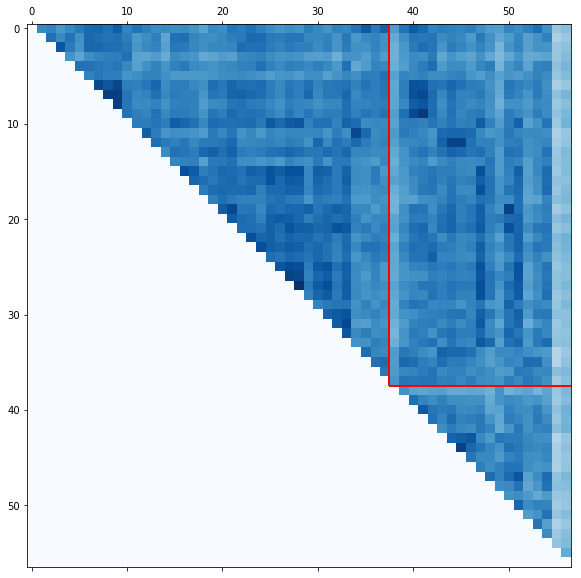

Query 2


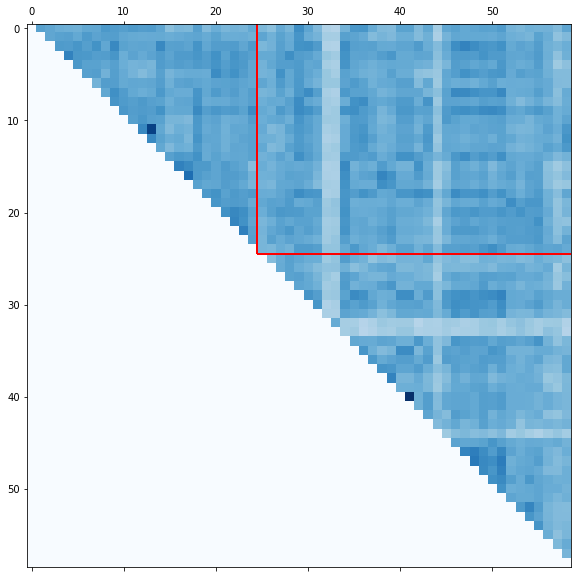

Query 3


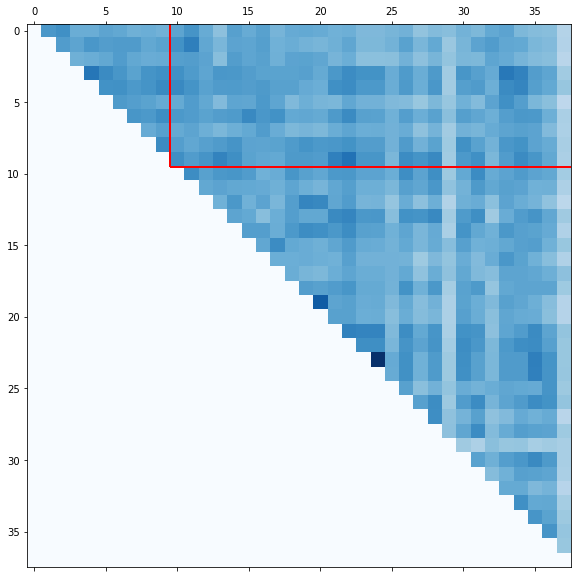

Query 4


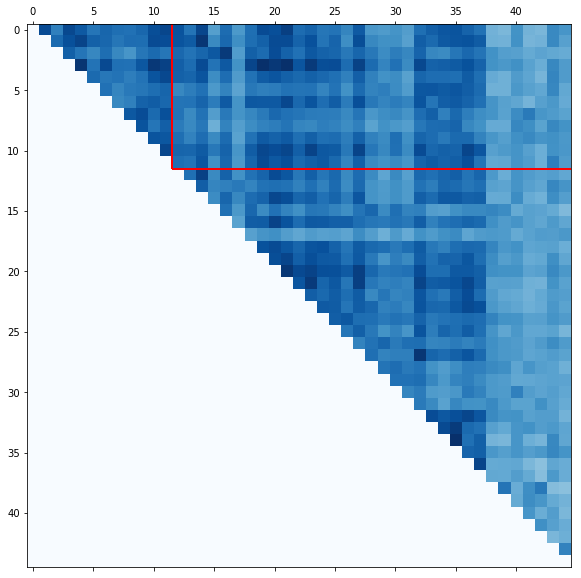

Query 5


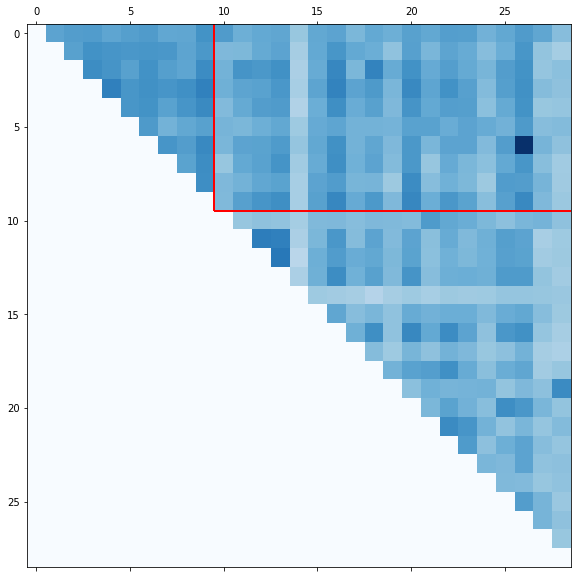

Query 6


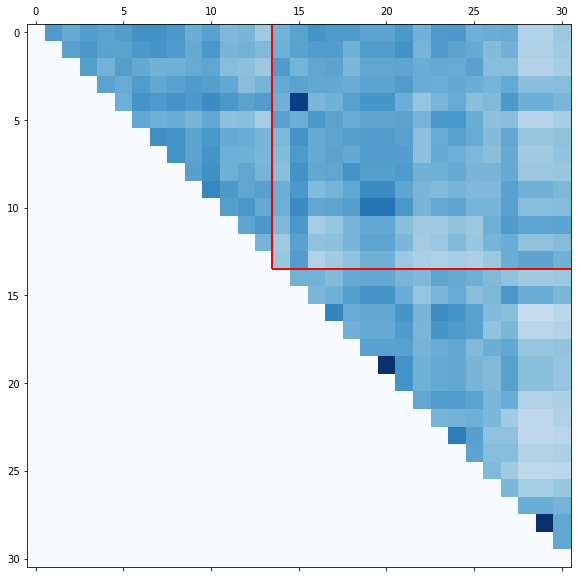

Query 7


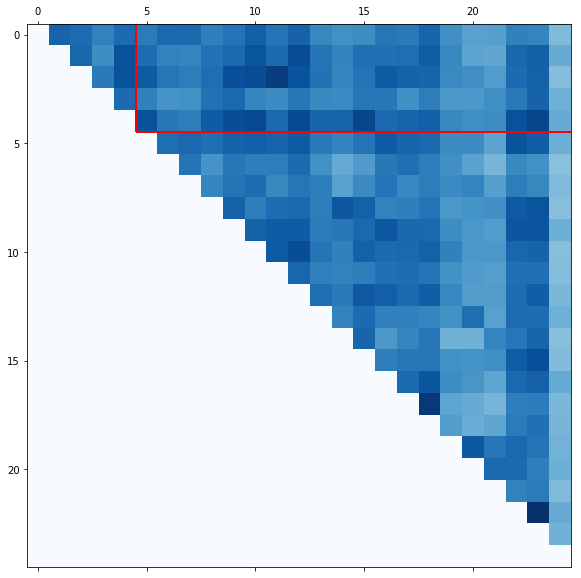

Query 8


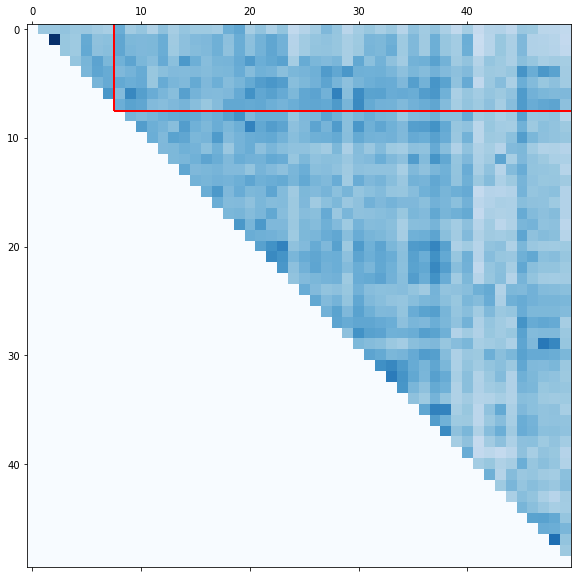

Query 9


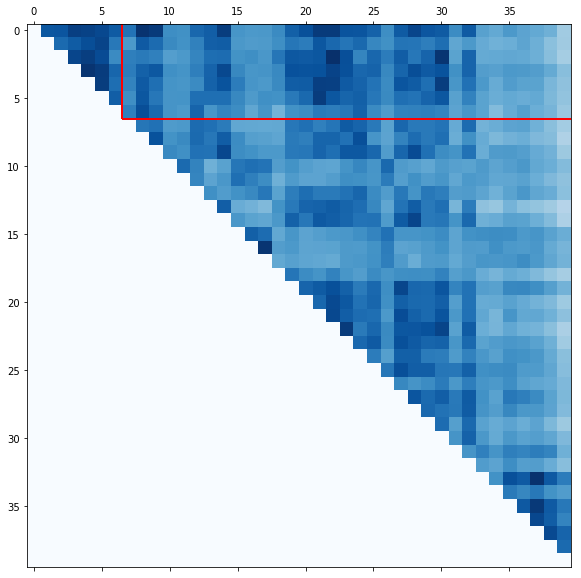

Query 10


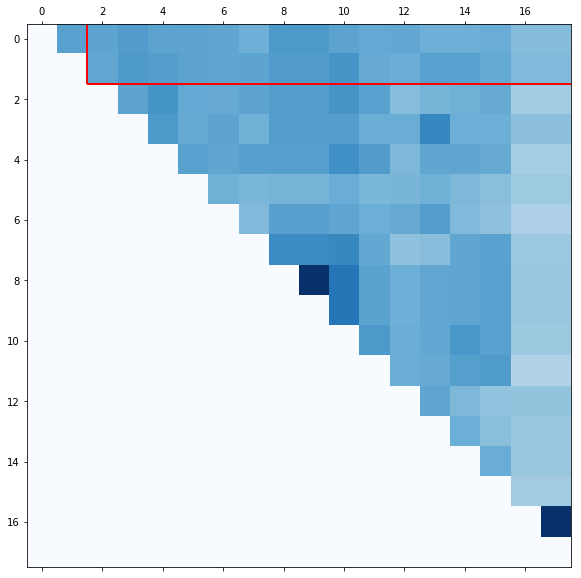

CPU times: user 32.6 s, sys: 2.54 s, total: 35.1 s
Wall time: 32.1 s


In [20]:
%%time
for query in xrange(1, 11):
    sim_matrix(query, gm.hellinger)

In [21]:
queries = [0]
for i in files_to_tokens('LegalAdhocTask/q*.txt'):
    queries.append(i)

In [22]:
for i in queries[1:]:
    x  = lda_model[dictionary.doc2bow(i)]
    x.sort(key = lambda x: -x[1])
    print lda_model.print_topic(x[0][0]) + '\n'

0.017*"can" + 0.016*"one" + 0.012*"reason" + 0.012*"also" + 0.012*"fact" + 0.012*"even" + 0.010*"will" + 0.009*"may" + 0.008*"two" + 0.008*"made"

0.017*"can" + 0.016*"one" + 0.012*"reason" + 0.012*"also" + 0.012*"fact" + 0.012*"even" + 0.010*"will" + 0.009*"may" + 0.008*"two" + 0.008*"made"

0.033*"dr" + 0.024*"x" + 0.024*"injuri" + 0.017*"right" + 0.017*"cm" + 0.015*"doctor" + 0.015*"hospit" + 0.014*"wound" + 0.013*"blood" + 0.013*"caus"

0.017*"can" + 0.016*"one" + 0.012*"reason" + 0.012*"also" + 0.012*"fact" + 0.012*"even" + 0.010*"will" + 0.009*"may" + 0.008*"two" + 0.008*"made"

0.017*"can" + 0.016*"one" + 0.012*"reason" + 0.012*"also" + 0.012*"fact" + 0.012*"even" + 0.010*"will" + 0.009*"may" + 0.008*"two" + 0.008*"made"

0.133*"good" + 0.097*"sale" + 0.068*"manufactur" + 0.051*"trade" + 0.051*"product" + 0.033*"custom" + 0.028*"dealer" + 0.026*"import" + 0.022*"use" + 0.020*"miner"

0.017*"can" + 0.016*"one" + 0.012*"reason" + 0.012*"also" + 0.012*"fact" + 0.012*"even" + 0.010*

In [ ]:

import math
from six import iteritems
from six.moves import xrange



class Lda(object):

    def __init__(self, corpus):
        self.corpus_size = dictionary.num_docs
        s = 0
        for i in corpus:
            for x in i:
                s = s + x[1]
        s = float(s)    
        self.avgdl = s / self.corpus_size
        self.corpus = corpus
        self.df = dictionary.dfs
        self.idf = {}
        self.initialize()

    def initialize(self):
        for word, freq in iteritems(self.df):
            self.idf[word] = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)

    def get_score(self, query, index, average_idf):
        score = 0
        index_doc = dict(self.corpus[index])
        
        for word,freq in query:
            if word not in index_doc:
                continue
            idf = self.idf[word] if self.idf[word] >= 0 else EPSILON * average_idf
            score += freq*((idf * index_doc[word] * (PARAM_K1 + 1)
                      / (index_doc[word] + PARAM_K1 * (1 - PARAM_B + PARAM_B * doc_len[index] / self.avgdl))))
        return score

    def get_scores(self, query, average_idf):
        scores = []
        for index in xrange(self.corpus_size):
            score = self.get_score(query, index, average_idf)
            scores.append(score)
        return scores

